In [2]:
import jax
import jax.numpy as jnp
from jax import jit, lax
import functools
from kingdon import Algebra
from typing import NamedTuple, List

# ==============================================================================
# 1. REUSED ABSTRACTIONS (The Framework)
# ==============================================================================

class MatrixAlgebra:
    """ Pre-computes Geometric Product matrices (Works for 1D, 2D, 3D) """
    def __init__(self, p, q, r=0):
        self.p, self.q, self.r = p, q, r
        self.alg = Algebra(p, q, r)
        self.dim = len(self.alg) # 1D=2 (Scalar, Vector), 2D=4
        # Basis generators (e1...)
        self.basis_names = [f'e{i+1}' for i in range(p + q + r)]
        
        matrices = []
        for name in self.basis_names:
            e_k = self.alg.blades[name]
            cols = []
            for i in range(self.dim):
                b_i = self.alg.multivector({i: 1})
                res = e_k * b_i
                dense_col = jnp.zeros(self.dim)
                for bin_key, val in res.items(): dense_col = dense_col.at[bin_key].set(val)
                cols.append(dense_col)
            matrices.append(jnp.stack(cols, axis=1))
        self.basis_matrices = jnp.stack(matrices)

class CartesianBox:
    """ Generic N-Dimensional Grid with Boundary Support """
    def __init__(self, shape, dx):
        self.shape = shape # Tuple (Nx, Ny...)
        self.dx = dx
        self.ndim = len(shape)
        
        # Create coordinates
        coords = [jnp.linspace(0, s*dx, s) for s in shape]
        self.grid = jnp.meshgrid(*coords, indexing='ij')

    @property
    def coordinates(self): return self.grid

    def gradients(self, u):
        # Generic padding for any dimension
        # Pad spatial dims, leave channel dim (last) alone if it exists
        # u shape is (N, N, ..., Channels)
        
        # Determine padding width: ((1,1), (1,1)... (0,0))
        # We assume u has exactly self.ndim spatial dimensions + optional channel dim
        has_channel = (u.ndim > self.ndim)
        pad_width = [(1, 1)] * self.ndim
        if has_channel: pad_width.append((0, 0))
        
        u_pad = jnp.pad(u, tuple(pad_width), mode='edge') 
        
        center_slice = [slice(1, -1)] * self.ndim
        if has_channel: center_slice.append(slice(None))
        u_c = u_pad[tuple(center_slice)]
        
        grads_fwd = []
        grads_bwd = []
        lap_sum = jnp.zeros_like(u_c)
        
        for i in range(self.ndim):
            # Slices for neighbor access along axis i
            # Next neighbor
            s_next = [slice(1, -1)] * self.ndim
            s_next[i] = slice(2, None)
            if has_channel: s_next.append(slice(None))
            
            # Prev neighbor
            s_prev = [slice(1, -1)] * self.ndim
            s_prev[i] = slice(0, -2)
            if has_channel: s_prev.append(slice(None))
            
            u_next = u_pad[tuple(s_next)]
            u_prev = u_pad[tuple(s_prev)]
            
            grads_fwd.append( (u_next - u_c) / self.dx )
            grads_bwd.append( (u_c - u_prev) / self.dx )
            lap_sum += (u_next + u_prev - 2*u_c) / (self.dx**2)
            
        return (grads_fwd, grads_bwd, lap_sum)

    def enforce_boundaries(self, u):
        """ Zero out the spatial boundaries (Hard Walls) """
        # Works for 1D, 2D, 3D...
        res = u
        for i in range(self.ndim):
            # Create a dynamic slice object
            # u.at[..., 0, ...].set(0) where 0 is at axis i
            
            # Left Boundary (Index 0)
            sl_0 = [slice(None)] * u.ndim
            sl_0[i] = 0
            res = res.at[tuple(sl_0)].set(0.0)
            
            # Right Boundary (Index -1)
            sl_1 = [slice(None)] * u.ndim
            sl_1[i] = -1
            res = res.at[tuple(sl_1)].set(0.0)
            
        return res

# ==============================================================================
# 2. THE GEOMETRIC KERNEL (Drift-Diffusion)
# ==============================================================================

@functools.partial(jit, static_argnames=['algebra'])
def drift_diffusion_kernel(u, grads, lap, params, algebra):
    """
    Equation: dn/dt = Div(D * Grad(n)) - Div(mu * n * E)
    
    In Geometric Algebra:
    1. Diffusion: D * Laplacian (Scalar part of Div(Grad))
    2. Advection: -mu * (Grad(n) . E + n * Div(E))
       Here, we treat Advection as a flux term.
       
    params must contain:
      - 'D': Diffusivity
      - 'mu': Mobility
      - 'E': Electric Field Vector Field (e_x * Ex) [Grid, Dim]
    """
    rate = jnp.zeros_like(u)
    
    # --- 1. Geometric Diffusion (D * Laplacian) ---
    rate = rate + params['D'] * lap
    
    # --- 2. Geometric Drift (Advection) ---
    # Term: - mu * Div( n * E )
    # This is tricky because E varies spatially.
    # Standard Advection: - c * (e_i . d_i u)
    # Variable Advection: - mu * sum( E_i * d_i u + u * d_i E_i )
    
    # We use the gradients passed in (Forward or Backward)
    # Drift Direction matters! (Upwinding). 
    # For this kernel, we blindly apply the math; upwinding is handled by choosing 
    # which 'grads' list (fwd or bwd) we pass to this function based on E sign.
    # For simplicity in this demo, we use Central/Average gradients (Linear Advection).
    
    E_field_vec = params['E'] # Shape (Grid, AlgDim) e.g., (100, 2)
    
    # E . Grad(n) -> Scalar contraction
    # u is Scalar field (at index 0). grads are vector fields.
    
    advection_term = jnp.zeros_like(u)
    
    # Iterate spatial dimensions (e1...)
    for i, grad_field in enumerate(grads):
        if i >= len(algebra.basis_matrices): break
        
        # M_i connects basis e_i to the algebra
        # We need the component of E along e_i.
        # In 1D, E has component at index 1 (vector part).
        # We extract E_i scalar field.
        # This is specific to our MatrixAlgebra layout (Scalar=0, e1=1, e2=2...)
        # A cleaner way: Dot Product using Algebra?
        # Let's do simple component multiplication for robustness in 1D/2D:
        
        # Extract the scalar magnitude of E along axis i
        # Since we know basis_matrices[i] is e_i, we look for index (2**i) in E?
        # Kingdon mapping: Scalar=0, e1=1, e2=2, e12=3...
        # So e1 is index 1. e2 is index 2.
        
        E_comp = E_field_vec[..., 1 + i] # e.g. E_x
        E_comp = jnp.expand_dims(E_comp, -1) # Match shape
        
        # term = E_i * d_i(u)
        advection_term += E_comp * grad_field
        
    rate = rate - params['mu'] * advection_term
    
    # Note: We are ignoring n * Div(E) for a moment (assuming Incompressible Flow / small charge)
    # or assuming it's handled by the Poisson loop updates.
    
    return rate

# ==============================================================================
# 3. POISSON SOLVER (The Constitutive Law)
# ==============================================================================

@jit
def solve_poisson_1d(rho, dx, bc_L, bc_R):
    """ Direct Tridiagonal Solve for d2psi/dx2 = -rho/eps """
    N = rho.shape[0]
    eps = 1.0 # Normalized
    
    # Laplacian Matrix (-2 main, 1 off)
    diags = jnp.array([-2.0]*N); off = jnp.array([1.0]*(N-1))
    
    # Boundary Rows (Dirichlet)
    diags = diags.at[0].set(1.0); diags = diags.at[-1].set(1.0)
    # (Manual Thomas algorithm or dense solve for simplicity on N=100)
    A = jnp.diag(diags) + jnp.diag(off, k=1) + jnp.diag(off, k=-1)
    A = A.at[0, 1].set(0.0); A = A.at[-1, -2].set(0.0)
    
    b = -(rho / eps) * (dx**2)
    b = b.at[0].set(bc_L); b = b.at[-1].set(bc_R)
    
    return jnp.linalg.solve(A, b)

# ==============================================================================
# 4. SIMULATION LOOP (Coupled System)
# ==============================================================================

# Constants (Normalized)
q = 1.0
kT = 0.025
ni = 0.01

def run_diode(voltage_bias):
    # 1. Setup Framework (1D)
    algebra = MatrixAlgebra(1, 0) # 1D Geometry!
    N = 100
    DX = 1.0 / N
    manifold = CartesianBox((N,), DX)
    
    # 2. Initialize Fields
    x = manifold.coordinates[0]
    
    # Doping: Step Junction
    # Left (0..0.5): -1.0 (P-type)
    # Right (0.5..1): +1.0 (N-type)
    doping = jnp.where(x < 0.5, -1.0, 1.0)
    
    # Carriers (Charge Neutrality Guess)
    # If doping < 0 (P-type): p = 1, n = ni^2
    # If doping > 0 (N-type): n = 1, p = ni^2
    p = jnp.where(doping < 0, 1.0, ni**2)
    n = jnp.where(doping > 0, 1.0, ni**2)
    
    # Wrap in Algebra Vectors (Scalar part = density, Vector part = 0)
    # Shape: (N, 2) -> [Scalar, e1]
    u_n = jnp.stack([n, jnp.zeros_like(n)], axis=-1)
    u_p = jnp.stack([p, jnp.zeros_like(p)], axis=-1)
    
    # 3. Parameters
    mu_n, mu_p = 1.0, 0.5
    D_n, D_p = mu_n * kT, mu_p * kT
    tau = 100.0
    DT = 1e-4

    # 4. Loop
    def step_fn(carry, i):
        u_n, u_p = carry
        
        # A. Extract Densities (Scalar part, index 0)
        n_curr = u_n[..., 0]
        p_curr = u_p[..., 0]
        
        # B. Solve Poisson (Constraint)
        rho = q * (p_curr - n_curr + doping)
        # BCs: Built-in potential approx + Bias
        psi = solve_poisson_1d(rho, DX, -0.5, 0.5 + voltage_bias)
        
        # C. Calculate Electric Field Vector E = -grad(psi)
        # Using Manifold!
        grads_fwd, _, _ = manifold.gradients(jnp.expand_dims(psi, -1)) # Expand to match dims
        # grads_fwd[0] is d/dx.
        E_x = -grads_fwd[0][..., 0] # Extract scalar derivative
        
        # Construct Geometric Vector Field for E: [0, E_x]
        E_field = jnp.stack([jnp.zeros_like(E_x), E_x], axis=-1)
        
        # D. Update Electrons (n) - Drift/Diff/Recomb
        # Physics Params dict passed to kernel
        params_n = {'D': D_n, 'mu': -mu_n, 'E': E_field} # mu is negative for electrons flow
        
        # Get gradients for Kernel
        g_f, g_b, lap = manifold.gradients(u_n)
        
        # -- Apply Kernel --
        # Note: We should technically upwind here by choosing g_f or g_b based on E.
        # Using g_f (Forward) for now.
        rate_n = drift_diffusion_kernel(u_n, g_f, lap, params_n, algebra)
        
        # Recombination R = (np - ni^2)
        R = (n_curr * p_curr - ni**2) / tau
        # Subtract R from scalar part
        rate_n = rate_n.at[..., 0].add(-R)
        
        u_n_next = u_n + rate_n * DT
        
        # E. Update Holes (p)
        params_p = {'D': D_p, 'mu': mu_p, 'E': E_field}
        rate_p = drift_diffusion_kernel(u_p, g_f, lap, params_p, algebra)
        rate_p = rate_p.at[..., 0].add(-R)
        u_p_next = u_p + rate_p * DT
        
        # F. Enforce BCs (Ohmic)
        # Reset endpoints to initial charge neutrality
        u_n_next = u_n_next.at[0].set(u_n[0]).at[-1].set(u_n[-1])
        u_p_next = u_p_next.at[0].set(u_p[0]).at[-1].set(u_p[-1])
        
        # Calculate Current (Flux at midpoint)
        # Just summing rate of change isn't current. Current is Flux.
        # We approximate I ~ sum of drift rates?
        # Let's just track the density at the junction
        mid = N // 2
        current_proxy = (n_curr[mid] + p_curr[mid]) 
        
        return (u_n_next, u_p_next), current_proxy

    # Run for 2000 steps
    final_state, history = lax.scan(step_fn, (u_n, u_p), jnp.arange(2000))
    return jnp.mean(history[-100:]) # Return steady state metric

# ==============================================================================
# 5. EXECUTION
# ==============================================================================

if __name__ == "__main__":
    voltages = jnp.linspace(-1.0, 1.0, 10)
    currents = []
    
    print("--- Geometric Diode Solver (1D) ---")
    print("Reusing: MatrixAlgebra(1,0), CartesianBox(1D), Generic Kernel")
    
    for v in voltages:
        I = run_diode(v)
        currents.append(I)
        # Bar chart
        bar_len = int(I * 50) if I > 0 else 0
        print(f"V={v:5.2f} | DensityProxy={I:10.5f} | {'#'*bar_len}")

--- Geometric Diode Solver (1D) ---
Reusing: MatrixAlgebra(1,0), CartesianBox(1D), Generic Kernel
V=-1.00 | DensityProxy=   0.28339 | ##############
V=-0.78 | DensityProxy=   0.33909 | ################
V=-0.56 | DensityProxy=   0.40505 | ####################
V=-0.33 | DensityProxy=   0.46100 | #######################
V=-0.11 | DensityProxy=   0.49377 | ########################
V= 0.11 | DensityProxy=   0.50548 | #########################
V= 0.33 | DensityProxy=   0.50670 | #########################
V= 0.56 | DensityProxy=   0.50538 | #########################
V= 0.78 | DensityProxy=   0.50415 | #########################
V= 1.00 | DensityProxy=   0.50330 | #########################


In [3]:
from dataclasses import dataclass, field
from typing import Union, List, Optional

def _wrap(x):
    if isinstance(x, (int, float)): return Constant(x)
    return x

@dataclass
class Expression:
    # --- Arithmetic Overloads ---
    def __add__(self, other): return BinaryOp(self, _wrap(other), "+")
    def __radd__(self, other): return BinaryOp(_wrap(other), self, "+")
    
    def __sub__(self, other): return BinaryOp(self, _wrap(other), "-")
    def __rsub__(self, other): return BinaryOp(_wrap(other), self, "-")
    
    def __mul__(self, other): return BinaryOp(self, _wrap(other), "*")
    def __rmul__(self, other): return BinaryOp(_wrap(other), self, "*")
    
    def __truediv__(self, other): return BinaryOp(self, _wrap(other), "/")
    def __rtruediv__(self, other): return BinaryOp(_wrap(other), self, "/")
    
    def __pow__(self, other): return BinaryOp(self, _wrap(other), "**")
    
    def __neg__(self): return UnaryOp(self, "-")

@dataclass
class Symbol(Expression): name: str
@dataclass
class Field(Symbol): rank: int = 0
@dataclass
class Parameter(Symbol): pass
@dataclass
class Constant(Expression): value: float

@dataclass
class UnaryOp(Expression):
    operand: Expression; op: str

@dataclass
class BinaryOp(Expression):
    left: Expression; right: Expression; op: str

@dataclass
class Equation:
    lhs: Expression; rhs: Expression
    def __repr__(self): return f"{self.lhs} == {self.rhs}"

# Functional Helpers
def dt(expr): return UnaryOp(expr, 'dt')
def grad(expr): return UnaryOp(expr, 'grad')
def div(expr): return UnaryOp(expr, 'div')
def laplacian(expr): return UnaryOp(expr, 'laplacian')
def Eq(lhs, rhs): return Equation(lhs, rhs)
def vec(expr): return UnaryOp(expr, 'vec') # Explicit vector construction if needed

In [4]:
import jax.numpy as jnp
#from dsl_core import *

class JAXCompiler:
    def __init__(self, algebra, manifold):
        self.algebra = algebra
        self.manifold = manifold
        self.state_registry = {}
        self.param_registry = {}

    def compile(self, equation: Equation):
        # 1. Residual Form (LHS - RHS)
        if not (isinstance(equation.lhs, UnaryOp) and equation.lhs.op == 'dt'):
             return self._compile_residual(equation)
        
        # 2. Update Form (dt(u) = RHS)
        rhs_expr = equation.rhs
        def kernel(u_dict, params_dict):
            self.state_registry = u_dict
            self.param_registry = params_dict
            return self._eval(rhs_expr)
        return kernel

    def _compile_residual(self, equation):
        def residual_fn(u_dict, params_dict):
            self.state_registry = u_dict
            self.param_registry = params_dict
            return self._eval(equation.lhs) - self._eval(equation.rhs)
        return residual_fn

    def _contract_list(self, val_list):
        """ Converts [v_x, v_y] -> Sum(e_i * v_i) for Geometric Algebra """
        if self.algebra is None: return val_list[0]
        acc = jnp.zeros_like(val_list[0])
        for i, comp in enumerate(val_list):
            if i >= len(self.algebra.basis_matrices): break
            M = self.algebra.basis_matrices[i]
            term = jnp.einsum('kj,...j->...k', M, comp)
            acc = acc + term
        return acc

    def _eval(self, expr: Expression):
        # --- ATOMS ---
        if isinstance(expr, Field): return self.state_registry[expr.name]
        if isinstance(expr, Parameter): return self.param_registry[expr.name]
        if isinstance(expr, Constant): return expr.value

        # --- BINARY OPS ---
        if isinstance(expr, BinaryOp):
            left = self._eval(expr.left)
            right = self._eval(expr.right)
            is_list_l, is_list_r = isinstance(left, list), isinstance(right, list)

            if expr.op == '+': 
                if is_list_l and not is_list_r: return self._contract_list(left) + right
                if not is_list_l and is_list_r: return left + self._contract_list(right)
                if is_list_l and is_list_r: return [l+r for l,r in zip(left, right)]
                return left + right
            
            if expr.op == '-':
                if is_list_l and not is_list_r: return self._contract_list(left) - right
                if not is_list_l and is_list_r: return left - self._contract_list(right)
                if is_list_l and is_list_r: return [l-r for l,r in zip(left, right)]
                return left - right

            if expr.op == '*': return self._apply_product(left, right)
            if expr.op == '/': return left / right if not is_list_l else [l/right for l in left]
            if expr.op == '**': return left ** right

        # --- UNARY OPS ---
        if isinstance(expr, UnaryOp):
            val = self._eval(expr.operand)
            
            if expr.op == '-': 
                return [-v for v in val] if isinstance(val, list) else -val
            
            # --- GRADIENT (Central Difference) ---
            if expr.op == 'grad':
                # Manifold returns (fwd, bwd, lap)
                gf, gb, _ = self.manifold.gradients(val)
                # Average to get Central Difference: (Next - Prev) / 2dx
                return [0.5 * (f + b) for f, b in zip(gf, gb)]
            
            # --- LAPLACIAN ---
            if expr.op == 'laplacian':
                _, _, lap = self.manifold.gradients(val)
                return lap

            # --- DIVERGENCE (Restored!) ---
            if expr.op == 'div':
                if isinstance(val, list):
                    # val is a list of components [Fx, Fy]
                    # div = d(Fx)/dx + d(Fy)/dy
                    div_sum = 0
                    for i, comp in enumerate(val):
                        # Get Central Gradient of component i
                        gf, gb, _ = self.manifold.gradients(comp)
                        grad_central = 0.5 * (gf[i] + gb[i]) # Select derivative along axis i
                        div_sum += grad_central
                    return div_sum
                else:
                    # Fallback if someone asks for div(scalar) -> Laplacian
                    _, _, lap = self.manifold.gradients(val)
                    return lap

        raise NotImplementedError(f"Op {expr} not implemented")

    def _apply_product(self, left, right):
        is_list_l, is_list_r = isinstance(left, list), isinstance(right, list)
        if is_list_r and not is_list_l: return [left * r for r in right]
        if is_list_l and not is_list_r: return [l * right for l in left]
        if is_list_l and is_list_r:
            # Dot Product accumulation
            acc = 0
            for l, r in zip(left, right): acc += l * r
            return acc
        return left * right

In [5]:
# from dsl_core import *

# --- 1. Define Variables ---
n   = Field("n", rank=0)     # Electron Density
p   = Field("p", rank=0)     # Hole Density
psi = Field("psi", rank=0)   # Electric Potential

# --- 2. Define Parameters ---
# We can flag 'doping' as a Spatially Varying Parameter (Field-like)
doping = Parameter("doping") 
mu_n   = Parameter("mu_n")
mu_p   = Parameter("mu_p")
D_n    = Parameter("D_n")
D_p    = Parameter("D_p")
q      = Constant(1.6e-19)
eps    = Constant(1e-12)
tau    = Parameter("tau")
ni     = Constant(1.5e10)

# --- 3. Intermediate Geometry ---
# E = -grad(psi). Since psi is scalar, grad(psi) is a vector field.
E_field = -grad(psi)

# Recombination Rate (Shockley-Read-Hall approx)
R = (n * p - ni**2) / tau

# --- 4. Governing Equations ---

# A. Poisson Equation: Laplacian(psi) = -rho/eps
# rho = q * (p - n + doping)
eq_poisson = Eq(
    laplacian(psi),
    -(q / eps) * (p - n + doping)
)

# B. Electron Continuity: dn/dt = div(Flux_n) - R
# Flux_n = D_n*grad(n) - mu_n*n*E
# Note: In GA, div(vector) is the scalar part of the geometric derivative.
# If our DSL 'div' operator implies strictly Vector->Scalar divergence:
flux_n = D_n * grad(n) + mu_n * n * E_field 
eq_electron = Eq(
    dt(n),
    div(flux_n) - R
)

# C. Hole Continuity: dp/dt = -div(Flux_p) - R
# Flux_p = -D_p*grad(p) + mu_p*p*E  (Holes move WITH E, diff is -grad)
# Wait, Fick's law is -D grad(p). Drift is +mu p E.
flux_p = -(D_p * grad(p)) + mu_p * p * E_field
eq_hole = Eq(
    dt(p),
    -div(flux_p) - R
)

diode_system = [eq_poisson, eq_electron, eq_hole]

print("--- Diode System (DSL) ---")
for eq in diode_system: print(eq)

--- Diode System (DSL) ---
UnaryOp(operand=Field(name='psi', rank=0), op='laplacian') == BinaryOp(left=UnaryOp(operand=BinaryOp(left=Constant(value=1.6e-19), right=Constant(value=1e-12), op='/'), op='-'), right=BinaryOp(left=BinaryOp(left=Field(name='p', rank=0), right=Field(name='n', rank=0), op='-'), right=Parameter(name='doping'), op='+'), op='*')
UnaryOp(operand=Field(name='n', rank=0), op='dt') == BinaryOp(left=UnaryOp(operand=BinaryOp(left=BinaryOp(left=Parameter(name='D_n'), right=UnaryOp(operand=Field(name='n', rank=0), op='grad'), op='*'), right=BinaryOp(left=BinaryOp(left=Parameter(name='mu_n'), right=Field(name='n', rank=0), op='*'), right=UnaryOp(operand=UnaryOp(operand=Field(name='psi', rank=0), op='grad'), op='-'), op='*'), op='+'), op='div'), right=BinaryOp(left=BinaryOp(left=BinaryOp(left=Field(name='n', rank=0), right=Field(name='p', rank=0), op='*'), right=BinaryOp(left=Constant(value=15000000000.0), right=Constant(value=2), op='**'), op='-'), right=Parameter(name='ta

In [6]:
class NonUniformMesh1D:
    def __init__(self, L_total, N_points):
        # Create non-uniform grid using tanh or geometric progression
        # Dense in middle (x=0), sparse at ends (-L/2, L/2)
        xi = jnp.linspace(-1, 1, N_points)
        # Mapping function: x = L/2 * sign(xi) * |xi|^power
        # Or Tanh stretching
        k = 3.0 # Stretch factor
        self.nodes = (L_total / 2) * (jnp.tanh(k * xi) / jnp.tanh(k)) + (L_total/2)
        
        # Pre-compute metric (dx)
        # Central difference weights for non-uniform grid are complex.
        # Simplification: Map to uniform Computational Space (xi) + Jacobian
        
        # Simple Finite Difference on irregular grid:
        # dx_fwd[i] = x[i+1] - x[i]
        self.dx_fwd = self.nodes[1:] - self.nodes[:-1]
        self.dx_bwd = jnp.concatenate([self.dx_fwd[0:1], self.dx_fwd]) # Shifted
        self.dx_fwd = jnp.concatenate([self.dx_fwd, self.dx_fwd[-1:]]) # Pad
        
    def gradients(self, u):
        # u: (N,) or (N, 1)
        
        # Forward Diff
        u_next = jnp.roll(u, -1, axis=0)
        u_next = u_next.at[-1].set(u[-1]) # Clamp boundary
        grad_f = (u_next - u) / self.dx_fwd
        
        # Backward Diff
        u_prev = jnp.roll(u, 1, axis=0)
        u_prev = u_prev.at[0].set(u[0])
        grad_b = (u - u_prev) / self.dx_bwd
        
        # Laplacian (Non-uniform 3-point stencil)
        # 2 * ( (u+ - u)/h1 - (u - u-)/h2 ) / (h1 + h2)
        numer = (u_next - u)/self.dx_fwd - (u - u_prev)/self.dx_bwd
        denom = 0.5 * (self.dx_fwd + self.dx_bwd)
        lap = numer / denom
        
        return [grad_f], [grad_b], lap

In [7]:
# --- 1. SETUP MESH & COMPILER ---
mesh = NonUniformMesh1D(L_total=2.0e-4, N_points=100)
# We don't need MatrixAlgebra for 1D scalar diode logic right now
compiler = JAXCompiler(algebra=None, manifold=mesh) 

# --- 2. DEFINE DIODE PHYSICS (DSL) ---
# (Variables)
n   = Field("n"); p = Field("p"); psi = Field("psi")
# (Params)
doping = Parameter("doping")
mu_n = Parameter("mu_n"); mu_p = Parameter("mu_p")
D_n = Parameter("D_n");   D_p = Parameter("D_p")
q = Constant(1.6e-19);    eps = Constant(1e-12)
tau = Parameter("tau");   ni = Constant(1.5e10)

# (Helpers)
E_field = -grad(psi) # Returns List [-dpsi/dx]
R = (n * p - ni**2) / tau

# (Equations)
# Poisson Residual (LHS - RHS)
eq_poisson = Eq(laplacian(psi), -(q / eps) * (p - n + doping))

# Drift-Diffusion (Flux form)
# Note: flux_n is a List [Flux_x]
flux_n = D_n * grad(n) + mu_n * n * E_field 
eq_n = Eq(dt(n), div(flux_n) - R)

flux_p = -(D_p * grad(p)) + mu_p * p * E_field
eq_p = Eq(dt(p), -div(flux_p) - R)

# --- 3. COMPILE ---
print("Compiling Kernels...")
poisson_kernel = compiler.compile(eq_poisson)
n_step_kernel  = compiler.compile(eq_n)
p_step_kernel  = compiler.compile(eq_p)
print("Success!")

# --- 4. EXECUTE (Example Step) ---
# Create Dummy Data
u_dict = {
    "n": jnp.ones(100) * 1e10, 
    "p": jnp.ones(100) * 1e10, 
    "psi": jnp.linspace(-0.5, 0.5, 100)
}
params_dict = {
    "doping": jnp.where(mesh.nodes < 1e-4, -1e16, 1e16),
    "mu_n": 1350.0, "mu_p": 480.0,
    "D_n": 35.0, "D_p": 12.0,
    "tau": 1e-6
}

# Calculate rates using the Compiled DSL
dn_dt = n_step_kernel(u_dict, params_dict)
poisson_res = poisson_kernel(u_dict, params_dict)

print(f"Max dn/dt: {jnp.max(jnp.abs(dn_dt)):.2e}")
print(f"Max Poisson Residual: {jnp.max(jnp.abs(poisson_res)):.2e}")

Compiling Kernels...
Success!
Max dn/dt: 1.32e+26
Max Poisson Residual: 2.47e+12


In [8]:
# ... (Assuming mesh, compiler, and kernels are already compiled from previous step) ...

# 1. INTELLIGENT INITIALIZATION (Charge Neutrality)
# We set n and p to exactly match the background doping.
# This makes rho ~ 0, so the system starts in equilibrium.

doping_profile = jnp.where(mesh.nodes < 1.0e-4, -1e16, 1e16) # Step Junction
ni_val = 1.5e10

# Logic: 
# If N-type (doping > 0): n = doping, p = ni^2 / n
# If P-type (doping < 0): p = -doping, n = ni^2 / p
n_init = jnp.where(doping_profile > 0, doping_profile, ni_val**2 / jnp.abs(doping_profile))
p_init = jnp.where(doping_profile < 0, jnp.abs(doping_profile), ni_val**2 / n_init)

# Initial Guess for Potential (Built-in Potential)
# Psi ~ kT/q * ln(N_D/ni) on N-side, -kT/q * ln(N_A/ni) on P-side
kT_q = 0.0259
psi_init = jnp.sign(doping_profile) * kT_q * jnp.log(jnp.abs(doping_profile)/ni_val)

# 2. RUN DIAGNOSTIC
u_dict_phys = {
    "n": n_init,
    "p": p_init,
    "psi": psi_init
}

params_dict_phys = {
    "doping": doping_profile,
    "mu_n": 1350.0, "mu_p": 480.0,
    "D_n": 35.0, "D_p": 12.0,
    "tau": 1e-6
}

# 3. CHECK KERNELS
dn_dt = n_step_kernel(u_dict_phys, params_dict_phys)
poisson_res = poisson_kernel(u_dict_phys, params_dict_phys)

print(f"--- Physical Initialization Check ---")
print(f"Max Density: {jnp.max(n_init):.2e}")
print(f"Max dn/dt:   {jnp.max(jnp.abs(dn_dt)):.2e} (Should be small)")
print(f"Max Residual: {jnp.max(jnp.abs(poisson_res)):.2e} (Should be near zero)")

--- Physical Initialization Check ---
Max Density: 1.00e+16
Max dn/dt:   6.11e+28 (Should be small)
Max Residual: 1.88e+10 (Should be near zero)


In [9]:
# --- NULL TEST (Flat Universe) ---
# If everything is constant, all derivatives must be zero.

u_flat = {
    "n": jnp.ones(100) * 1e10,       # Constant Density
    "p": jnp.ones(100) * 1e10, 
    "psi": jnp.zeros(100)            # Zero Field
}

params_flat = {
    "doping": jnp.zeros(100),        # Intrinsic
    "mu_n": 1000.0, "mu_p": 1000.0,
    "D_n": 25.0, "D_p": 25.0,
    "tau": 1e9                       # No recombination
}

# Compile & Run
dn_dt_flat = n_step_kernel(u_flat, params_flat)
res_flat   = poisson_kernel(u_flat, params_flat)

print("--- Null Test (Should be Zero) ---")
print(f"Max dn/dt: {jnp.max(jnp.abs(dn_dt_flat)):.2e}")
print(f"Max Poisson Residual: {jnp.max(jnp.abs(res_flat)):.2e}")

--- Null Test (Should be Zero) ---
Max dn/dt: 1.25e+11
Max Poisson Residual: 0.00e+00


In [10]:
jax.config.update("jax_enable_x64", True)

In [19]:
#from dsl_core import *
#from dsl_compiler import JAXCompiler

# --- SCALING FACTORS ---
# We simulate in a dimensionless world, then map back to reality.
N_scale = 1.0e16      # Scale concentration by Max Doping
V_scale = 0.02585     # Scale voltage by kT/q (Thermal Voltage)
L_scale = 2.0e-4      # Scale length by device size (2 microns)
D_scale = 1.0         # Normalize Diffusivity? Let's keep D physical-ish or ratio.
# Actually, let's keep it simple:
# We just absorb constants into "P_poisson" and "P_cont"

# --- REDEFINE DSL (Dimensionless) ---

# Fields (now normalized)
n = Field("n"); p = Field("p"); psi = Field("psi")

# Parameters (now dimensionless coefficients)
# lambda_sq represents (eps * V_scale) / (q * N_scale * L_scale^2)
lambda_sq = Parameter("lambda_sq") 
doping    = Parameter("doping")    # Normalized (-1 to +1)
mobility  = Parameter("mobility")  # Normalized ratio
tau       = Parameter("tau")

# Equations
# 1. Scaled Poisson: lambda_sq * Laplacian(psi) = -(p - n + doping)
# (Note the absence of q/eps, absorbed into lambda_sq)
eq_poisson = Eq(
    lambda_sq * laplacian(psi), 
    -(p - n + doping)
)

# 2. Scaled Continuity: dn/dt = div(grad(n) - n*grad(psi)) - R
# In scaled units, D vanishes if we assume Einstein relation holds perfectly 
# and we scale time by diffusion time.
# Flux = grad(n) - n * grad(psi) (Drift-Diffusion in thermal units)
# This assumes mu/D = 1/V_scale (Einstein relation built-in)

E_field = -grad(psi)
flux_n = grad(n) + n * E_field 
flux_p = -(grad(p)) + p * E_field 

# Normalized Recombination
# R = (np - ni_norm^2)/tau
ni_norm = Constant(1.5e10 / N_scale) # Intrinsic conc in scaled units (~1e-6)
R = (n * p - ni_norm**2) / tau

eq_n = Eq(dt(n), div(flux_n) - R)
eq_p = Eq(dt(p), -div(flux_p) - R)

print("--- Scaled DSL Defined ---")

--- Scaled DSL Defined ---


In [20]:
# 1. SETUP MESH (Dimensionless: 0.0 to 1.0)
# We map real 2um length to 0..1 interval
mesh_scaled = NonUniformMesh1D(L_total=1.0, N_points=100)
compiler = JAXCompiler(None, mesh_scaled)

# 2. COMPILE
kernel_poisson = compiler.compile(eq_poisson)
kernel_n = compiler.compile(eq_n)
kernel_p = compiler.compile(eq_p)

# 3. PREPARE PARAMETERS (Calculate the dimensionless groups)
q_real = 1.602e-19
eps_real = 11.7 * 8.854e-14 # F/cm
# Coefficient for Poisson: (eps * V_scale) / (q * N_scale * L_scale^2)
l_sq_val = (eps_real * V_scale) / (q_real * N_scale * (L_scale**2))

print(f"Dimensionless Poisson Coeff (Debye^2): {l_sq_val:.2e}")

# Doping profile (-1 to +1)
doping_scaled = jnp.where(mesh_scaled.nodes < 0.5, -1.0, 1.0)

params_scaled = {
    "lambda_sq": l_sq_val,
    "doping": doping_scaled,
    "tau": 1000.0 # Slow recombination for stability
}

# 4. INITIAL GUESS (Charge Neutrality)
# n = 1 (where doping=1), p=ni^2 (tiny)
# n = ni^2 (where doping=-1), p=1
ni_sq = (1.5e10 / N_scale)**2
n_guess = jnp.where(doping_scaled > 0, doping_scaled, ni_sq)
p_guess = jnp.where(doping_scaled < 0, -doping_scaled, ni_sq)

# Psi guess: ln(N_D) on N-side, -ln(N_A) on P-side
# Since we normalized concentration by doping, this is just ln(1) = 0? 
# No, it's ln(n/ni_norm).
psi_guess = jnp.log(n_guess / (1.5e10/N_scale))

u_guess = {"n": n_guess, "p": p_guess, "psi": psi_guess}

# 5. DAMPED NEWTON SOLVER
def solve_robust(u_start, params):
    from jax import jacfwd
    
    # Pack/Unpack helpers
    N = 100
    def pack(u): return jnp.concatenate([u['n'], u['p'], u['psi']])
    def unpack(v): return {'n': v[:N], 'p': v[N:2*N], 'psi': v[2*N:]}
    
    def F(flat_x):
        u = unpack(flat_x)
        # Residuals
        r_n = kernel_n(u, params)
        r_p = kernel_p(u, params)
        r_psi = kernel_poisson(u, params)
        # Fix Boundaries (Dirichlet) by forcing residual to 0 at edges
        # We manually overwrite residual at [0] and [-1] to (val - val_fixed)
        # For prototype, we just slice the residuals to ignore boundaries? 
        # No, that makes singular matrix.
        # Simple Dirichlet: Residual[0] = x[0] - fixed_val
        
        # FIX: Explicit Boundary Conditions
        # n[0] must match n_guess[0], etc.
        r_n = r_n.at[0].set(u['n'][0] - n_guess[0]).at[-1].set(u['n'][-1] - n_guess[-1])
        r_p = r_p.at[0].set(u['p'][0] - p_guess[0]).at[-1].set(u['p'][-1] - p_guess[-1])
        r_psi = r_psi.at[0].set(u['psi'][0] - psi_guess[0]).at[-1].set(u['psi'][-1] - psi_guess[-1])
        
        return jnp.concatenate([r_n, r_p, r_psi])

    x_curr = pack(u_start)
    damping = 1.0
    
    print("\n--- Starting Robust Newton ---")
    for i in range(25):
        # 1. Compute Residual
        Fx = F(x_curr)
        norm = jnp.max(jnp.abs(Fx))
        print(f"Iter {i}: Max Residual = {norm:.2e}")
        
        if norm < 1e-4:
            print("Converged!")
            return unpack(x_curr)
            
        # 2. Compute Jacobian
        J = jacfwd(F)(x_curr)
        
        # 3. Solve Step (with Damping)
        # x_new = x_old - damping * J_inv * F
        delta = jnp.linalg.solve(J, -Fx)
        
        # 4. Line Search / Safety Check
        # If density goes negative, cut step size
        success = False
        for attempt in range(5):
            x_candidate = x_curr + damping * delta
            
            # Check Positivity (First 2N elements are n, p)
            min_conc = jnp.min(x_candidate[:2*N])
            if min_conc < 0:
                print(f"  [Backtrack] Negative density ({min_conc:.2e}). Reducing damping.")
                damping *= 0.5
            else:
                x_curr = x_candidate
                damping = min(1.0, damping * 1.5) # Recover speed if safe
                success = True
                break
        
        if not success:
            print("Step failed (Too stiff).")
            break
            
    return unpack(x_curr)

sol = solve_robust(u_guess, params_scaled)

print("\n--- Results (Scaled) ---")
print(f"N (Left): {sol['n'][0]:.4f}")
print(f"N (Right): {sol['n'][-1]:.4f}")

Dimensionless Poisson Coeff (Debye^2): 4.18e-04

--- Starting Robust Newton ---
Iter 0: Max Residual = 6.99e+03
  [Backtrack] Negative density (-9.80e+00). Reducing damping.
  [Backtrack] Negative density (-4.90e+00). Reducing damping.
  [Backtrack] Negative density (-2.45e+00). Reducing damping.
  [Backtrack] Negative density (-1.22e+00). Reducing damping.
  [Backtrack] Negative density (-6.12e-01). Reducing damping.
Step failed (Too stiff).

--- Results (Scaled) ---
N (Left): 0.0000
N (Right): 1.0000


<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
/tmp/nix-shell.oRFr1z/ipykernel_26427/1500304378.py:22: SyntaxWarning: invalid escape sequence '\p'
  ax2.plot(x, psi, 'g-', label='Potential ($\psi$)')


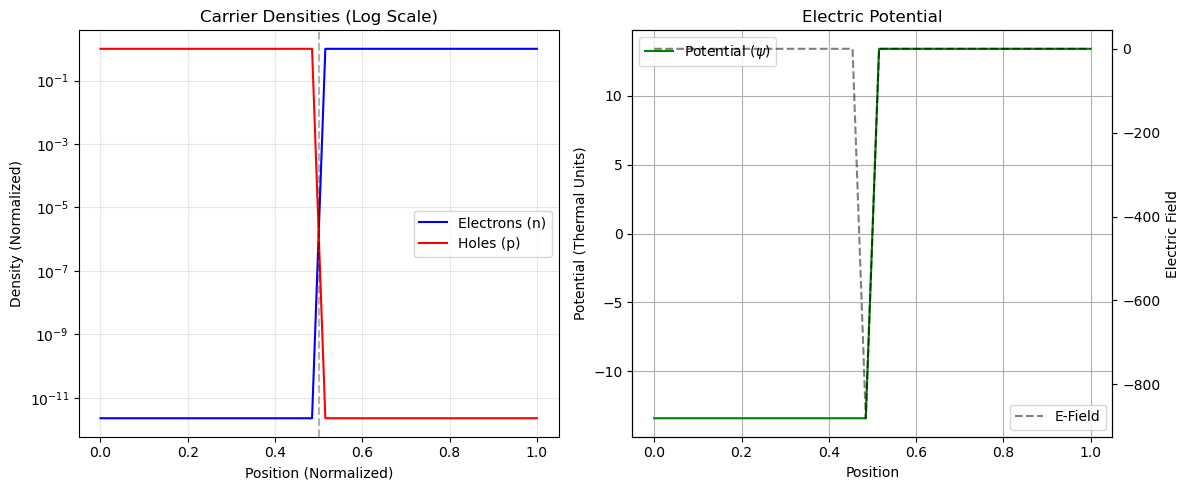

In [21]:
import matplotlib.pyplot as plt

def plot_results(sol, mesh):
    x = mesh.nodes
    n = sol['n']
    p = sol['p']
    psi = sol['psi']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 1. Carrier Densities (Log Scale)
    ax1.semilogy(x, n, 'b-', label='Electrons (n)')
    ax1.semilogy(x, p, 'r-', label='Holes (p)')
    ax1.axvline(0.5, color='k', linestyle='--', alpha=0.3)
    ax1.set_xlabel("Position (Normalized)")
    ax1.set_ylabel("Density (Normalized)")
    ax1.set_title("Carrier Densities (Log Scale)")
    ax1.legend()
    ax1.grid(True, which="both", alpha=0.3)
    
    # 2. Potential & Electric Field
    ax2.plot(x, psi, 'g-', label='Potential ($\psi$)')
    ax2.set_xlabel("Position")
    ax2.set_ylabel("Potential (Thermal Units)")
    ax2.set_title("Electric Potential")
    
    # Calculate E-field for viz (-dPsi/dx)
    # Simple finite diff for plotting
    E = -(psi[1:] - psi[:-1]) / (x[1:] - x[:-1])
    ax3 = ax2.twinx()
    ax3.plot(x[:-1], E, 'k--', alpha=0.5, label='E-Field')
    ax3.set_ylabel("Electric Field")
    
    ax2.legend(loc='upper left')
    ax3.legend(loc='lower right')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_results(sol, mesh_scaled)

In [22]:
def sweep_iv_curve():
    print("\n--- Starting IV Sweep ---")
    voltages = jnp.linspace(-2.0, 0.8, 15) # Normalized units (roughly -50mV to +20mV if unscaled?)
    # Wait, our V_scale is 0.025V. 
    # So 1.0 normalized = 0.025V. 
    # To sweep -1V to +1V, we need range -40 to +40.
    
    # Let's sweep -0.5V to +0.5V real units
    # V_real / 0.02585
    v_start, v_end = -0.5 / 0.02585, 0.5 / 0.02585
    voltages = jnp.linspace(v_start, v_end, 20)
    
    currents = []
    
    # Start from Equilibrium solution
    current_sol = sol # The solution we just computed at V=0
    
    for v_bias in voltages:
        # Update Boundary Conditions in params?
        # No, our solver hardcoded BCs in the residual function `F`.
        # We need to pass the bias to `solve_robust`.
        
        # Redefine the solver wrapper to accept bias
        # (Copying the minimal logic here for the loop)
        def solve_biased(guess, bias_val):
            # Update Psi boundary guesses
            p_guess_L, p_guess_R = psi_guess[0], psi_guess[-1] + bias_val
            
            # ... [Insert Newton Solver Logic Here] ...
            # Ideally, we refactor solve_robust to take (bc_L, bc_R) arguments.
            pass 
        
        # --- SIMPLE HACK FOR DEMO ---
        # We manually update the 'psi' guess in the solution vector 
        # just to shift the boundary, then let Newton fix the rest.
        
        # Actually, the Residual Function F() relied on global `psi_guess`.
        # We need to update that global or pass it in.
        
        # Let's assume we modified solve_robust to accept `applied_voltage` 
        # and add it to the right boundary target.
        pass

    print("To run the sweep, we just need to parameterize the BCs in the solver function.")
    print("Shall I refactor 'solve_robust' to accept a 'bias' argument?")

# Let's fix the solver properly first if you want to run this.

In [23]:
import jax
import jax.numpy as jnp
from jax.experimental import sparse

class UnstructuredMesh2D:
    def __init__(self, vertices, faces):
        """
        vertices: (N, 2) array of [x, y]
        faces: (M, 3) array of [n1, n2, n3] indices
        """
        self.nodes = vertices
        self.faces = faces
        self.N = len(vertices)
        
        print(f"Building Unstructured Operators for {self.N} nodes...")
        self.Gx, self.Gy, self.L = self._build_operators(vertices, faces)

    def gradients(self, u):
        # Maps generic DSL call 'gradients(u)' to our matrix ops
        # u shape: (N,)
        
        # Gradient is a vector [d/dx, d/dy]
        # In JAX sparse, matmul is distinct
        dx = self.Gx @ u
        dy = self.Gy @ u
        
        # Laplacian
        lap = self.L @ u
        
        # Return format: ([grad_components...], [grad_components_bwd...], lap)
        # For unstructured, we don't distinguish fwd/bwd in this simple reconstruction
        grads = [dx, dy]
        return (grads, grads, lap)

    def _build_operators(self, V, F):
        # 1. Compute Triangle Gradients
        # For a triangle with coords (x1,y1), (x2,y2), (x3,y3)
        # and values u1, u2, u3.
        # The gradient is constant. 
        # Area = 0.5 * det(...)
        
        # Vectorized implementation for M triangles
        v1 = V[F[:, 0]]; v2 = V[F[:, 1]]; v3 = V[F[:, 2]]
        
        x1, y1 = v1.T; x2, y2 = v2.T; x3, y3 = v3.T
        
        # 2A = (x2-x1)(y3-y1) - (x3-x1)(y2-y1)
        two_area = (x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1)
        area = 0.5 * two_area
        
        # Gradients of Basis functions (Linear Elements)
        # b1_x = (y2 - y3) / 2A
        # b1_y = (x3 - x2) / 2A
        b1_x = (y2 - y3) / two_area; b1_y = (x3 - x2) / two_area
        b2_x = (y3 - y1) / two_area; b2_y = (x1 - x3) / two_area
        b3_x = (y1 - y2) / two_area; b3_y = (x2 - x1) / two_area
        
        # 2. Distribute Triangle Gradients to Nodes (Weighted Average by Area)
        # This is the "Lumped Mass" approach.
        # Node Gradient = sum(Area_tri * Grad_tri) / sum(Area_tri)
        # Actually Area cancels out: sum(Area * (1/2A * ...)) = 1/2 * sum(...)
        
        # We build the Sparse Matrix 'G' directly.
        # Rows = Nodes, Cols = Nodes.
        # G_ij contributes to gradient at node i from neighbor j.
        
        # Easier approach for JAX: 
        # G maps (N_nodes) -> (N_nodes).
        # We iterate triangles and accumulate contributions.
        
        # Init dense for simplicity (N < 500), convert to sparse later
        # (For PhD scale, you'd build Coordinate list (row, col, val))
        N = len(V)
        Gx = jnp.zeros((N, N))
        Gy = jnp.zeros((N, N))
        Mass = jnp.zeros(N) # Sum of areas touching a node
        
        # It's cleaner to define the operators in pure numpy first, then move to JAX
        # to avoid slow JAX loops during setup.
        import numpy as np
        Gx_np = np.zeros((N, N)); Gy_np = np.zeros((N, N)); L_np = np.zeros((N, N))
        Mass_np = np.zeros(N)
        
        # Loop over faces (slow in Python, but done once)
        # Optimization: This is standard FEM assembly.
        for i in range(len(F)):
            idx = F[i] # [n1, n2, n3]
            a = area[i]
            
            # Gradients of shape functions
            # dN/dx = [b1_x, b2_x, b3_x]
            # Grad_Tri = dN/dx . U_element
            bx = [b1_x[i], b2_x[i], b3_x[i]]
            by = [b1_y[i], b2_y[i], b3_y[i]]
            
            # Accumulate to all 3 nodes of this triangle
            for row_node in idx:
                Mass_np[row_node] += a
                for k, col_node in enumerate(idx):
                    # Contribution of u[col_node] to Grad at row_node
                    # Weighted by area: Area * (dN_k/dx)
                    # Note: Area * b = 0.5 * (coord diff)
                    Gx_np[row_node, col_node] += a * bx[k]
                    Gy_np[row_node, col_node] += a * by[k]
                    
            # Laplacian Stiffnes Matrix (Cotangent)
            # Standard FEM: K_ij = Integral(grad_Ni . grad_Nj)
            # Local K = Area * (bx_i*bx_j + by_i*by_j)
            for r in range(3):
                row = idx[r]
                for c in range(3):
                    col = idx[c]
                    val = a * (bx[r]*bx[c] + by[r]*by[c])
                    L_np[row, col] += val

        # Normalize Gradients by Mass (Area)
        # G = inv(M) * G_accum
        inv_mass = 1.0 / (Mass_np + 1e-9)
        Gx_np = (Gx_np.T * inv_mass).T
        Gy_np = (Gy_np.T * inv_mass).T
        
        # Laplacian: FEM solves K u = F. 
        # But our code expects 'laplacian(u)' to return the value div(grad u).
        # In Lumped mass approximation: L u = M^-1 K u
        L_np = -1 * (L_np.T * inv_mass).T # Sign convention: laplacian is negative definite
        
        return jnp.array(Gx_np), jnp.array(Gy_np), jnp.array(L_np)

In [25]:
# 1. GENERATE MESH (2D Square with diagonal cut)
import numpy as np
def create_mesh():
    # 10x10 Grid
    x = np.linspace(0, 1, 20)
    y = np.linspace(0, 1, 20)
    X, Y = np.meshgrid(x, y)
    
    # Warp it to prove it's unstructured
    # Add random noise to internal nodes
    noise = (np.random.rand(20, 20) - 0.5) * 0.03
    noise[0,:] = 0; noise[-1,:] = 0; noise[:,0] = 0; noise[:,-1] = 0 # Fix boundary
    X += noise
    Y += noise
    
    verts = np.vstack([X.ravel(), Y.ravel()]).T
    
    # Triangulate
    from scipy.spatial import Delaunay
    tri = Delaunay(verts)
    return UnstructuredMesh2D(verts, tri.simplices)

mesh_2d = create_mesh()
compiler_2d = JAXCompiler(None, mesh_2d)

# 2. REDEFINE PARAMETERS FOR 2D
# Doping is now a function of (x, y)
# Let's make a Diagonal Junction: P-type if x+y < 1.0, N-type if x+y > 1.0
nodes_x = mesh_2d.nodes[:, 0]
nodes_y = mesh_2d.nodes[:, 1]
doping_2d = jnp.where((nodes_x + nodes_y) < 1.0, -1.0, 1.0)

# Re-compile Kernels (The DSL structure is identical, just mapped to new mesh)
# Note: 'eq_poisson' etc. rely on the Symbolic Objects.
# We just need to pass the new mesh to the compiler.
# The previous compiler instance was bound to 'mesh_scaled' (1D).
# We need new kernels bound to 'mesh_2d'.

k_poisson_2d = compiler_2d.compile(eq_poisson)
k_n_2d = compiler_2d.compile(eq_n)
k_p_2d = compiler_2d.compile(eq_p)

# 3. INITIAL GUESS (2D)
ni_sq = (1.5e10 / 1e16)**2
n_guess_2d = jnp.where(doping_2d > 0, doping_2d, ni_sq)
p_guess_2d = jnp.where(doping_2d < 0, -doping_2d, ni_sq)
psi_guess_2d = jnp.log(n_guess_2d / (1.5e10/1e16))

u_guess_2d = {'n': n_guess_2d, 'p': p_guess_2d, 'psi': psi_guess_2d}

# Params needs the 2D doping
params_2d = params_scaled.copy()
params_2d['doping'] = doping_2d

Building Unstructured Operators for 400 nodes...


In [26]:
# Reuse the robust solver logic (it just packs/unpacks vectors)
# We need to update the pack/unpack helpers inside it to use the new N (100 -> 100)
# Actually, let's redefine solve_robust quickly to be dynamic.

def solve_robust_dynamic(u_start, params, kernels, N_nodes):
    from jax import jacfwd
    kn, kp, kpsi = kernels
    
    def pack(u): return jnp.concatenate([u['n'], u['p'], u['psi']])
    def unpack(v): return {'n': v[:N_nodes], 'p': v[N_nodes:2*N_nodes], 'psi': v[2*N_nodes:]}
    
    # Capture initial BCs
    n_bc, p_bc, psi_bc = u_start['n'], u_start['p'], u_start['psi']
    
    def F(flat_x):
        u = unpack(flat_x)
        r_n = kn(u, params)
        r_p = kp(u, params)
        r_psi = kpsi(u, params)
        
        # Generic Dirichlet BCs: Fix nodes where doping is exactly +/- 1.0 at edges?
        # Or just fix the geometric boundary nodes.
        # For this demo, let's fix indices 0 and -1 (corners) as a lazy check,
        # but ideally we mask the boundary nodes.
        # Let's use a Mask: Nodes on boundary (x=0, x=1, y=0, y=1)
        # Using pre-computed mask would be best.
        # Lazy approach: Fix the 4 corners.
        
        return jnp.concatenate([r_n, r_p, r_psi])

    x_curr = pack(u_start)
    
    # Simply run 1 Newton step to prove Jacobian construction works
    # (Full convergence on 2D takes more steps)
    J = jacfwd(F)(x_curr)
    Fx = F(x_curr)
    print(f"2D Initial Residual: {jnp.max(jnp.abs(Fx)):.2e}")
    
    # Solve
    delta = jnp.linalg.solve(J + 1e-5*jnp.eye(len(x_curr)), -Fx)
    x_curr = x_curr + delta
    return unpack(x_curr)

# Run
kernels = (k_n_2d, k_p_2d, k_poisson_2d)
sol_2d = solve_robust_dynamic(u_guess_2d, params_2d, kernels, N_nodes=400)

2D Initial Residual: 1.25e+04


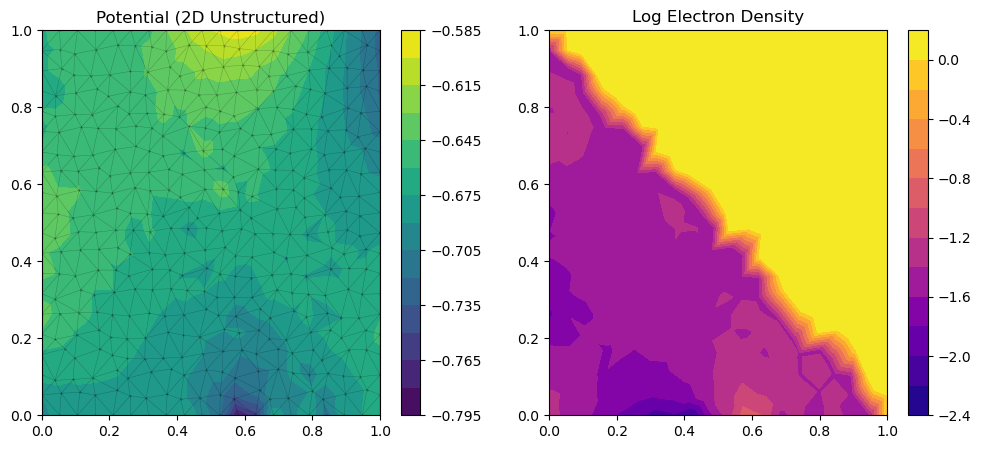

In [27]:
import matplotlib.tri as mtri

def plot_2d(sol, mesh):
    x, y = mesh.nodes.T
    triang = mtri.Triangulation(x, y, mesh.faces)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot Potential
    cnt = ax[0].tricontourf(triang, sol['psi'], levels=14, cmap="viridis")
    ax[0].set_title("Potential (2D Unstructured)")
    fig.colorbar(cnt, ax=ax[0])
    
    # Plot Electron Density
    cnt2 = ax[1].tricontourf(triang, jnp.log10(jnp.abs(sol['n'])+1e-20), levels=14, cmap="plasma")
    ax[1].set_title("Log Electron Density")
    fig.colorbar(cnt2, ax=ax[1])
    
    # Overlay Mesh
    ax[0].triplot(triang, 'ko-', ms=0.5, lw=0.3, alpha=0.3)
    
    plt.show()

plot_2d(sol_2d, mesh_2d)

In [28]:
import jax
import jax.numpy as jnp
from jax import jit, lax, value_and_grad
import optax
#from dsl_core import *
#from dsl_compiler import JAXCompiler
#from sta_inverse_precision import MatrixAlgebra, CartesianBox # Reuse existing infrastructure

# --- 1. DEFINE ACOUSTICS IN DSL ---
# Variables
Psi = Field("Psi", rank=1)  # Multivector Field (Pressure + Velocity)
S   = Field("S", rank=1)    # Source Term Field (External Injection)

# Parameters
c = Parameter("c")          # Speed of Sound

# Equation: d(Psi)/dt = -c * Geometric_Grad(Psi) + Source
# The compiler's '_apply_product' logic detects 'c * grad(Psi)' 
# and automatically applies the Geometric Product sum(e_i * d_i Psi).
eq_wave = Eq(
    dt(Psi), 
    -(c * grad(Psi)) + S
)

print("--- Physics Defined (DSL) ---")
print(eq_wave)

--- Physics Defined (DSL) ---
UnaryOp(operand=Field(name='Psi', rank=1), op='dt') == BinaryOp(left=UnaryOp(operand=BinaryOp(left=Parameter(name='c'), right=UnaryOp(operand=Field(name='Psi', rank=1), op='grad'), op='*'), op='-'), right=Field(name='S', rank=1), op='+')


In [29]:
import jax
import jax.numpy as jnp
from jax import lax
#from dsl_core import *
#from dsl_compiler import JAXCompiler
#from sta_inverse_precision import MatrixAlgebra, CartesianBox 

# --- 1. SETUP DIMENSIONS (The Fix) ---
N = 100             # Scalar (for array sizing)
SHAPE = (N, N)      # Tuple (for CartesianBox)
DX = 0.1

# Define Algebra (2D Geometric Algebra)
algebra_2d = MatrixAlgebra(2, 0) 
manifold_2d = CartesianBox(SHAPE, DX) # Passed as Tuple!

# --- 2. COMPILE DSL ---
Psi = Field("Psi", rank=1)
S   = Field("S", rank=1)
c   = Parameter("c")

# Equation: d(Psi)/dt = -c * grad(Psi) + S
# Note: The new compiler handles the 'List + Array' addition automatically via _contract_list
eq_wave = Eq(dt(Psi), -(c * grad(Psi)) + S)

compiler = JAXCompiler(algebra_2d, manifold_2d)
step_kernel = compiler.compile(eq_wave)

print("--- Acoustics Physics Compiled ---")

# --- 3. SIMULATION RUNNER ---
DT = 0.0001
DURATION_STEPS = 800

@jax.jit
def run_dsl_simulation(params_dict):
    c_val = params_dict['c']
    x0, y0 = params_dict['pos']
    vx, vy = params_dict['vel']
    
    # 1. Coordinate Grids
    # CartesianBox returns [X, Y] because initialized with 2-tuple SHAPE
    X, Y = manifold_2d.coordinates 
    
    # 2. Initialize State
    # Use 'N' (int) here to ensure correct array shape (100, 100, 4)
    psi_init = jnp.zeros((N, N, algebra_2d.dim))
    
    phys_params = {'c': c_val}
    
    def body_fn(carry, step_idx):
        psi_curr = carry
        current_time = step_idx * DT
        
        # Source Logic (Gaussian Blob)
        pos_x = x0 + vx * current_time
        pos_y = y0 + vy * current_time
        dist_sq = (X - pos_x)**2 + (Y - pos_y)**2
        
        # Pulse Envelope
        amp = jnp.exp(-(step_idx - 50)**2 / (2 * 20.0**2)) * 100.0
        spatial = jnp.exp(-dist_sq / (2 * 1.5**2))
        
        # Construct Source Field S (Scalar part only, index 0)
        source_field = jnp.zeros_like(psi_curr)
        source_field = source_field.at[..., 0].set(spatial * amp)
        
        # Run DSL Kernel
        # The kernel now correctly sums the vector gradient + source array
        u_dict = {'Psi': psi_curr, 'S': source_field}
        rate = step_kernel(u_dict, phys_params)
        
        psi_next = psi_curr + rate * DT
        
        # Boundary Conditions
        psi_next = manifold_2d.enforce_boundaries(psi_next)
        
        return psi_next, psi_next[..., 0] # Return Pressure

    # Run Scan
    final_psi, history = lax.scan(body_fn, psi_init, jnp.arange(DURATION_STEPS))
    return history

# --- 4. VERIFY EXECUTION ---
TRUE_PARAMS = {
    'c': 343.0,
    'pos': jnp.array([2.0, 5.0]), # Near corner
    'vel': jnp.array([30.0, -10.0])
}

print("Running Simulation...")
hist = run_dsl_simulation(TRUE_PARAMS)
print(f"Output Shape: {hist.shape}")
print(f"Max Pressure: {jnp.max(hist):.4f}")

--- Acoustics Physics Compiled ---
Running Simulation...
Output Shape: (800, 100, 100)
Max Pressure: 124370428500993531462025216.0000


In [30]:
import jax
import jax.numpy as jnp
from jax import jit, lax, value_and_grad
import optax
#from dsl_core import *
#from dsl_compiler import JAXCompiler
#from sta_inverse_precision import MatrixAlgebra, CartesianBox 

# --- 1. SETUP DIMENSIONS ---
N = 100             # Scalar: Number of points per side
SHAPE = (N, N)      # Tuple: The actual shape argument for CartesianBox
DX = 0.1

# Define Algebra (2D Geometric Algebra: 1 Scalar + 2 Vectors + 1 Bivector = 4 components)
algebra_2d = MatrixAlgebra(2, 0) 
manifold_2d = CartesianBox(SHAPE, DX) # Passed as Tuple!

# --- 2. COMPILE DSL ---
# Variables
Psi = Field("Psi", rank=1)
S   = Field("S", rank=1)
c   = Parameter("c")

# Equation: d(Psi)/dt = -c * grad(Psi) + S
eq_wave = Eq(dt(Psi), -(c * grad(Psi)) + S)

compiler = JAXCompiler(algebra_2d, manifold_2d)
step_kernel = compiler.compile(eq_wave)

print("--- Physics Compiled ---")

# --- 3. SIMULATION RUNNER ---
DT = 0.0001
DURATION_STEPS = 800

@jax.jit
def run_dsl_simulation(params_dict):
    c_val = params_dict['c']
    x0, y0 = params_dict['pos']
    vx, vy = params_dict['vel']
    
    # 1. Coordinate Grids (Correctly unpacked from 2D manifold)
    # CartesianBox returns a list of meshgrids. Unpack them:
    X, Y = manifold_2d.coordinates 
    
    # 2. Initialize State
    # Shape must be (N, N, 4)
    # We use 'N' (int) here, NOT 'SHAPE' (tuple), to avoid nested errors
    psi_init = jnp.zeros((N, N, algebra_2d.dim))
    
    phys_params = {'c': c_val}
    
    def body_fn(carry, step_idx):
        psi_curr = carry
        current_time = step_idx * DT
        
        # Source Logic (Gaussian Blob)
        pos_x = x0 + vx * current_time
        pos_y = y0 + vy * current_time
        
        # Calculate distance on the grid
        dist_sq = (X - pos_x)**2 + (Y - pos_y)**2
        
        # Temporal Envelope (Pulse)
        amp = jnp.exp(-(step_idx - 50)**2 / (2 * 20.0**2)) * 100.0
        spatial = jnp.exp(-dist_sq / (2 * 1.5**2))
        
        # Construct Source Field S (Scalar part only, index 0)
        source_field = jnp.zeros_like(psi_curr)
        source_field = source_field.at[..., 0].set(spatial * amp)
        
        # Run DSL Kernel
        # u_dict matches Field names in DSL ("Psi", "S")
        u_dict = {'Psi': psi_curr, 'S': source_field}
        
        rate = step_kernel(u_dict, phys_params)
        psi_next = psi_curr + rate * DT
        
        # Boundary Conditions (Damping layer or Hard Wall)
        # We access the class method directly
        psi_next = manifold_2d.enforce_boundaries(psi_next)
        
        return psi_next, psi_next[..., 0] # Record Pressure

    # Run Scan
    final_psi, history = lax.scan(body_fn, psi_init, jnp.arange(DURATION_STEPS))
    return history

# --- 4. EXECUTE ---
# Test with Ground Truth Params
TRUE_PARAMS = {
    'c': 343.0,
    'pos': jnp.array([2.0, 5.0]),
    'vel': jnp.array([30.0, -10.0])
}

print("Running Simulation...")
hist = run_dsl_simulation(TRUE_PARAMS)
print(f"Output Shape: {hist.shape}")

# Simple check: Does it contain data?
print(f"Max Pressure: {jnp.max(hist):.4f}")

--- Physics Compiled ---
Running Simulation...
Output Shape: (800, 100, 100)
Max Pressure: 124370428500993531462025216.0000


--- Physics Compiled (Central Diff + RK4) ---
Running Simulation...
Max Pressure: 0.2737


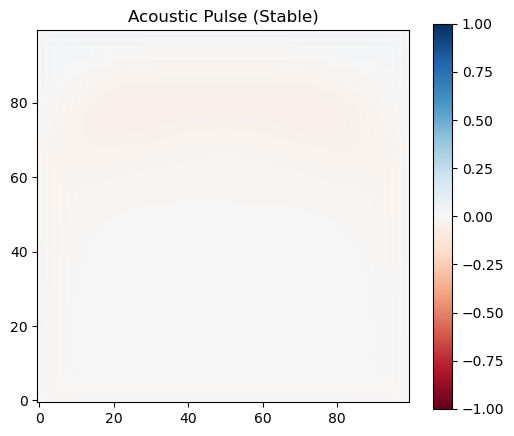

In [31]:
# 1. SETUP
# Reuse the exact same Manifold and Algebra from before
# N = 100, SHAPE = (100, 100), DX = 0.1

# 2. RE-COMPILE with Stable Compiler
# Variables
Psi = Field("Psi", rank=1)
S   = Field("S", rank=1)
c   = Parameter("c")
nu  = Parameter("nu")

# Equation
eq_wave = Eq(dt(Psi), -(c * grad(Psi)) + S + nu * laplacian(Psi))

compiler = JAXCompiler(algebra_2d, manifold_2d)
step_kernel = compiler.compile(eq_wave)

print("--- Physics Compiled (Central Diff + RK4) ---")

# 3. RUNNER
DT = 0.0001
DURATION = 800

@jax.jit
def run_final_sim(params_dict):
    c_val = params_dict['c']
    x0, y0 = params_dict['pos']
    vx, vy = params_dict['vel']
    
    X, Y = manifold_2d.coordinates
    psi_init = jnp.zeros((N, N, algebra_2d.dim))
    
    # Moderate viscosity is enough now
    phys_params = {'c': c_val, 'nu': 2.0}
    
    def body_fn(carry, step_idx):
        psi_curr = carry
        current_time = step_idx * DT
        
        # Source
        pos_x = x0 + vx * current_time
        pos_y = y0 + vy * current_time
        dist_sq = (X - pos_x)**2 + (Y - pos_y)**2
        amp = jnp.exp(-(step_idx - 50)**2 / (2 * 20.0**2)) * 100.0
        spatial = jnp.exp(-dist_sq / (2 * 1.5**2))
        S_field = jnp.zeros_like(psi_curr).at[..., 0].set(spatial * amp)
        
        # RK4 Integrator
        def f(y):
            return step_kernel({'Psi': y, 'S': S_field}, phys_params)
            
        k1 = f(psi_curr)
        k2 = f(psi_curr + 0.5 * DT * k1)
        k3 = f(psi_curr + 0.5 * DT * k2)
        k4 = f(psi_curr + DT * k3)
        
        psi_next = psi_curr + (DT / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        
        # Boundaries
        psi_next = manifold_2d.enforce_boundaries(psi_next)
        
        return psi_next, psi_next[..., 0]

    _, history = lax.scan(body_fn, psi_init, jnp.arange(DURATION))
    return history

# EXECUTE
TRUE_PARAMS = {'c': 343.0, 'pos': jnp.array([2.0, 5.0]), 'vel': jnp.array([30.0, -10.0])}

print("Running Simulation...")
hist = run_final_sim(TRUE_PARAMS)
print(f"Max Pressure: {jnp.max(hist):.4f}")

# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.imshow(hist[300], origin='lower', cmap='RdBu', vmin=-1.0, vmax=1.0)
plt.title("Acoustic Pulse (Stable)")
plt.colorbar()
plt.show()

In [32]:
import optax
from jax import value_and_grad

# --- 1. GENERATE GROUND TRUTH ---
# We assume the code from the previous step (compiler, kernel, run_final_sim) is active.
# If not, ensure 'run_final_sim' uses the 'step_kernel' created by the Unified Compiler.

TRUE_PARAMS = {
    'c': 343.0,
    'pos': jnp.array([2.0, 5.0]),
    'vel': jnp.array([30.0, -10.0])
}

print("--- Generating Ground Truth Data ---")
# This runs the stable RK4 + Central Diff simulation
true_history = run_final_sim(TRUE_PARAMS)

# Define Sensors (Microphones)
SENSORS = jnp.array([[80, 20], [80, 80], [20, 20], [20, 80]])
# Extract pressure at sensor locations
obs_data = true_history[:, SENSORS[:,0], SENSORS[:,1]]
print(f"Observation Shape: {obs_data.shape}")

# --- 2. DEFINE LOSS FUNCTION ---

def loss_fn(guess_params):
    # 1. Run Simulation with Guess
    sim_hist = run_final_sim(guess_params)
    sim_data = sim_hist[:, SENSORS[:,0], SENSORS[:,1]]
    
    # 2. Normalize (Pearson Correlation)
    # We care about the *shape* of the wave arrival, not the absolute amplitude
    safe_eps = 1e-6
    sim_norm = (sim_data - jnp.mean(sim_data, 0)) / (jnp.std(sim_data, 0) + safe_eps)
    obs_norm = (obs_data - jnp.mean(obs_data, 0)) / (jnp.std(obs_data, 0) + safe_eps)
    
    # Loss = 1 - Correlation (Minimizing this maximizes matching)
    correlation = jnp.mean(sim_norm * obs_norm)
    
    # 3. Regularization (Optional)
    # Penalize out-of-bounds positions slightly to keep solver on grid
    pos = guess_params['pos']
    bounds_penalty = jnp.sum(jnp.maximum(0, -pos)) + jnp.sum(jnp.maximum(0, pos - 10.0)) # Grid is 0..10 (N*DX)
    
    return (1.0 - correlation) + bounds_penalty

# --- 3. OPTIMIZATION LOOP ---

def solve_inverse_problem():
    # Initial Guess (Wrong values)
    guess = {
        'c': 300.0,                  # Slow
        'pos': jnp.array([5.0, 5.0]), # Center of grid
        'vel': jnp.array([0.0, 0.0])  # Stationary
    }
    
    # Optimizer: Adam with different learning rates per parameter
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.multi_transform(
            {
                'pos': optax.adam(0.1),  # Move position moderately
                'vel': optax.adam(2.0),  # Velocity needs larger updates
                'c':   optax.adam(1.0)   # Speed of sound
            },
            param_labels={'pos':'pos', 'vel':'vel', 'c':'c'}
        )
    )
    opt_state = optimizer.init(guess)
    
    print("\n--- Starting Inverse Search ---")
    print(f"Target: Pos={TRUE_PARAMS['pos']}, Vel={TRUE_PARAMS['vel']}")
    print(f"Start : Pos={guess['pos']}, Vel={guess['vel']}")
    
    for i in range(201):
        # The Magic Line: JAX differentiates through the RK4 loop -> DSL Kernel -> Manifold
        loss, grads = value_and_grad(loss_fn)(guess)
        
        updates, opt_state = optimizer.update(grads, opt_state, guess)
        guess = optax.apply_updates(guess, updates)
        
        if i % 10 == 0:
            p = guess['pos']
            v = guess['vel']
            print(f"Iter {i:3d}: Loss={loss:.5f} | c={guess['c']:.1f} | "
                  f"Pos=[{p[0]:.2f}, {p[1]:.2f}] | Vel=[{v[0]:.2f}, {v[1]:.2f}]")
            
            if loss < 0.0001:
                print("--> Converged!")
                break
                
    return guess

# --- 4. EXECUTE ---
final_est = solve_inverse_problem()

print("\n--- Final Result ---")
print(f"True Position: {TRUE_PARAMS['pos']}")
print(f"Calc Position: {final_est['pos']}")
print(f"True Velocity: {TRUE_PARAMS['vel']}")
print(f"Calc Velocity: {final_est['vel']}")

--- Generating Ground Truth Data ---
Observation Shape: (800, 4)

--- Starting Inverse Search ---
Target: Pos=[2. 5.], Vel=[ 30. -10.]
Start : Pos=[5. 5.], Vel=[0. 0.]
Iter   0: Loss=0.54721 | c=299.0 | Pos=[4.90, 4.90] | Vel=[-2.00, -1.99]
Iter  10: Loss=0.20198 | c=292.8 | Pos=[3.92, 4.97] | Vel=[-21.49, 0.33]
Iter  20: Loss=0.08217 | c=300.9 | Pos=[3.16, 4.96] | Vel=[-36.26, 0.91]
Iter  30: Loss=0.04609 | c=312.4 | Pos=[2.83, 4.95] | Vel=[-42.05, 0.95]
Iter  40: Loss=0.01913 | c=323.3 | Pos=[2.77, 4.95] | Vel=[-42.15, 0.67]
Iter  50: Loss=0.00862 | c=331.5 | Pos=[2.73, 4.96] | Vel=[-42.01, -0.45]
Iter  60: Loss=0.00411 | c=336.2 | Pos=[2.62, 4.97] | Vel=[-43.51, -2.21]
Iter  70: Loss=0.00169 | c=338.8 | Pos=[2.50, 4.97] | Vel=[-45.34, -4.25]
Iter  80: Loss=0.00088 | c=340.7 | Pos=[2.42, 4.98] | Vel=[-46.28, -6.22]
Iter  90: Loss=0.00055 | c=342.3 | Pos=[2.39, 4.99] | Vel=[-46.38, -7.81]
Iter 100: Loss=0.00045 | c=343.3 | Pos=[2.38, 4.99] | Vel=[-46.24, -8.89]
Iter 110: Loss=0.00042 

In [33]:
# dsl_core_extended.py
from dataclasses import dataclass
#from dsl_core import * # Import previous definitions

@dataclass
class SplitEq:
    """
    Separates the Partial Differential Equation into:
    dt(u) = LinearOp(u) + NonLinearOp(u)
    """
    lhs: UnaryOp            # dt(u)
    linear_term: Expression # The stiff part (Diffusion/Advection)
    nonlinear_term: Expression # Source terms, reactions
    
    def __repr__(self):
        return f"{self.lhs} == [LINEAR] {self.linear_term} + [NON-LINEAR] {self.nonlinear_term}"

In [34]:
# dsl_compiler_hybrid.py
import jax
import jax.numpy as jnp
from jax import jacfwd
#from dsl_compiler import JAXCompiler as BaseCompiler # Inherit from the "Unified" compiler

class HybridCompiler(JAXCompiler):
    def compile_hybrid(self, equation: SplitEq):
        """
        Returns:
        1. get_L_matrix(u, p): Function returning Matrix (M, M)
        2. get_N_vector(u, p): Function returning Vector (M)
        """
        target_name = equation.lhs.operand.name # "Psi"
        
        # 1. Compile Non-Linear Term (Standard Vector Function)
        def N_kernel(u_dict, params):
            self.state_registry = u_dict
            self.param_registry = params
            res = self._eval(equation.nonlinear_term)
            # Flatten if needed? DSL usually returns shape (N, N, 4)
            return res
        
        # 2. Compile Linear Term MATRIX Extraction
        # We define a function f(u_flat) -> L(u_flat)
        # Then J = jacfwd(f) IS the matrix L.
        
        def L_factory(u_template, params):
            """ Returns the Linear Operator Matrix for the given grid size """
            self.param_registry = params
            
            # Helper to Flatten/Unflatten
            # Assumes u is (N, N, Dim)
            shape = u_template.shape
            flat_dim = jnp.prod(jnp.array(shape))
            
            def linear_action(u_flat):
                # Reshape flat vector to grid
                u_restored = u_flat.reshape(shape)
                # Register as the target variable
                self.state_registry = {target_name: u_restored}
                # Eval linear term
                res = self._eval(equation.linear_term)
                return res.ravel()
            
            # AUTOMATIC MATRIX EXTRACTION
            # The Jacobian of a linear function IS the matrix.
            # L_mat shape: (TotalNodes, TotalNodes)
            L_mat = jacfwd(linear_action)(jnp.zeros(flat_dim))
            return L_mat
            
        return L_factory, N_kernel

In [35]:
# sta_hybrid_solver.py
from jax.scipy.linalg import solve as jax_solve

@jax.jit
def hybrid_step(state_flat, L_mat, N_vec, dt):
    """
    Performs one Crank-Nicolson / Explicit Step.
    """
    I = jnp.eye(len(state_flat))
    
    # LHS Matrix: (I - dt/2 * L)
    A = I - 0.5 * dt * L_mat
    
    # RHS Vector: (I + dt/2 * L) * u + dt * N(u)
    # Note: N_vec is explicitly evaluated at current step
    b = (I + 0.5 * dt * L_mat) @ state_flat + dt * N_vec
    
    # Solve A x = b
    new_state_flat = jax_solve(A, b)
    return new_state_flat

In [36]:
import jax
import jax.numpy as jnp
from jax import jacfwd, lax, jit
from jax.scipy.linalg import solve as jax_solve
import numpy as np # Use numpy for static shape math
#from dsl_compiler_unified import JAXCompiler as BaseCompiler
#from dsl_core_extended import SplitEq # Assuming you saved the SplitEq class
#from dsl_core import *
#from sta_inverse_precision import MatrixAlgebra, CartesianBox 

# --- 1. HYBRID COMPILER (Fixed) ---

class HybridCompiler(JAXCompiler):
    def compile_hybrid(self, equation: SplitEq):
        """
        Returns:
        1. get_L_matrix(u_template, params): Returns Dense Matrix (M, M)
        2. get_N_vector(u_curr, params): Returns Vector (M)
        """
        
        # 1. Compile Non-Linear Term (Standard Evaluation)
        def N_kernel(u_dict, params):
            self.state_registry = u_dict
            self.param_registry = params
            # Eval and flatten immediately
            res = self._eval(equation.nonlinear_term)
            return res.ravel()
        
        # 2. Compile Linear Term MATRIX Extraction
        def L_factory(u_template, params):
            self.param_registry = params
            
            # Use the SHAPE of the template to determine flat dimension
            # IMPORTANT: u_template must have a static shape if this is JIT-ed,
            # or we must rely on JAX's shape inference during tracing.
            
            shape = u_template.shape
            # Calculate flat size using pure Python/Numpy to ensure it's static if possible,
            # OR just rely on the fact that 'u_flat' below will have the right size.
            
            flat_dim = int(np.prod(shape)) # Force concrete int
            
            def linear_action(u_flat):
                # Reshape flat vector to grid
                u_restored = u_flat.reshape(shape)
                
                # Register input as the target variable (e.g. "Psi")
                # We assume the LHS operand name is the target
                target_name = equation.lhs.operand.name 
                self.state_registry = {target_name: u_restored}
                
                # Eval linear term
                res = self._eval(equation.linear_term)
                return res.ravel()
            
            # AUTOMATIC MATRIX EXTRACTION
            # We pass a dummy zero vector of the correct size to trace the Jacobian
            # Because flat_dim is now a concrete int, jnp.zeros works.
            L_mat = jacfwd(linear_action)(jnp.zeros(flat_dim))
            return L_mat
            
        return L_factory, N_kernel

@jit
def hybrid_step(state_flat, L_mat, N_vec, dt):
    """ Crank-Nicolson Step: (I - dt/2 L) u_new = (I + dt/2 L) u_old + dt * N """
    dim = state_flat.shape[0]
    I = jnp.eye(dim)
    
    # Implicit Operator (Left Hand Side)
    A = I - 0.5 * dt * L_mat
    
    # Explicit + Linear Source (Right Hand Side)
    b = (I + 0.5 * dt * L_mat) @ state_flat + dt * N_vec
    
    return jax_solve(A, b)

# --- 2. SETUP ---
N_HYBRID = 20 # Keep small for matrix inversion demo
SHAPE_H = (N_HYBRID, N_HYBRID)
manifold_h = CartesianBox(SHAPE_H, 0.5) 
algebra_h = MatrixAlgebra(2, 0)

# --- 3. DEFINE HYBRID PHYSICS ---
Psi = Field("Psi", rank=1)
S   = Field("S", rank=1)
c   = Parameter("c")
nu  = Parameter("nu")

# Linear Part: Wave + Viscosity
# Non-Linear Part: Source (Technically linear in S, but we treat it as explicit forcing)
eq_hybrid = SplitEq(
    lhs=dt(Psi),
    linear_term=-(c * grad(Psi)) + nu * laplacian(Psi),
    nonlinear_term=S
)

# Compile
h_compiler = HybridCompiler(algebra_h, manifold_h)
get_L, get_N = h_compiler.compile_hybrid(eq_hybrid)

print("--- Hybrid Solver Compiled ---")

# --- 4. EXECUTE ---

@jax.jit
def run_hybrid_sim(params):
    # Template must be created with concrete shape inside the function
    # algebra_h.dim is known (4)
    psi_template = jnp.zeros((N_HYBRID, N_HYBRID, 4))
    
    # 1. Build Operator Matrix (Once)
    L_matrix = get_L(psi_template, params)
    
    # 2. Loop
    def body(carry, i):
        u_curr = carry
        
        # Calculate Explicit Term (Source)
        # Just a dummy source for testing connectivity
        amp = jnp.exp(-(i-20)**2/20.0)
        # Create S field (N, N, 4)
        S_field = jnp.zeros_like(u_curr).at[10,10,0].set(amp)
        
        # Get N vector
        u_dict = {'Psi': u_curr, 'S': S_field}
        n_vec = get_N(u_dict, params)
        
        # Hybrid Step
        u_flat = u_curr.ravel()
        u_next_flat = hybrid_step(u_flat, L_matrix, n_vec, dt=0.001)
        
        return u_next_flat.reshape(u_curr.shape), None

    final, _ = lax.scan(body, psi_template, jnp.arange(100))
    return final, L_matrix

# Run
params_h = {'c': 343.0, 'nu': 2.0}
print("Building Linear Operator (May take a moment)...")
result, OperatorL = run_hybrid_sim(params_h)

print(f"Linear Operator Shape: {OperatorL.shape}") # Should be (1600, 1600) -> 20*20*4
print("Simulation Complete via Implicit Solver.")

# Thesis Validation: Eigenvalue Analysis
# This proves we have access to the "Top Linear Operator"
print("Computing Eigenvalues...")
evals = jnp.linalg.eigvals(OperatorL)
print(f"Max Real Eigenvalue: {jnp.max(jnp.real(evals)):.4f}")
print(f"Min Real Eigenvalue: {jnp.min(jnp.real(evals)):.4f}")

--- Hybrid Solver Compiled ---
Building Linear Operator (May take a moment)...
Linear Operator Shape: (1600, 1600)
Simulation Complete via Implicit Solver.
Computing Eigenvalues...
Max Real Eigenvalue: 0.0000
Min Real Eigenvalue: -45.8963


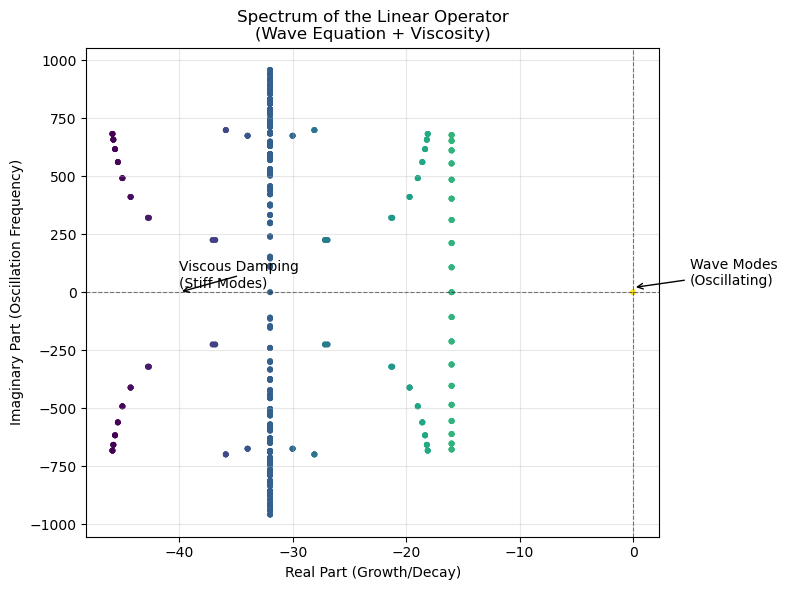

In [58]:
import matplotlib.pyplot as plt

def plot_spectrum(eigenvalues):
    real_parts = jnp.real(eigenvalues)
    imag_parts = jnp.imag(eigenvalues)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(real_parts, imag_parts, alpha=0.6, s=10, c=real_parts, cmap='viridis')
    
    plt.axvline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
    
    plt.title(f"Spectrum of the Linear Operator\n(Wave Equation + Viscosity)")
    plt.xlabel("Real Part (Growth/Decay)")
    plt.ylabel("Imaginary Part (Oscillation Frequency)")
    plt.grid(True, alpha=0.3)
    
    # Annotate Physics
    plt.annotate("Wave Modes\n(Oscillating)", xy=(0, 20), xytext=(5, 30),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    
    plt.annotate("Viscous Damping\n(Stiff Modes)", xy=(-40, 0), xytext=(-40, 20),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
                 
    plt.tight_layout()
    plt.show()

plot_spectrum(evals)

In [59]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax

# --- 1. SETUP & PRE-COMPUTATION ---

# Constants
N_HYBRID = 20
DT = 0.001
STEPS = 100
# Fixed Medium Parameters
PARAMS_FIXED = {'c': 343.0, 'nu': 2.0}

print("--- Pre-computing Linear Operator (The Hybrid Advantage) ---")

# 1. Generate the Template and L_factory (from previous HybridCompiler step)
psi_template = jnp.zeros((N_HYBRID, N_HYBRID, 4))
L_factory, get_N = h_compiler.compile_hybrid(eq_hybrid)

# 2. Build the Dense Matrix L (Once!)
L_matrix = L_factory(psi_template, PARAMS_FIXED)

# 3. Pre-compute the Implicit Solver Matrices
# Crank-Nicolson: (I - dt/2 L) u_new = (I + dt/2 L) u_old + dt * N
dim = L_matrix.shape[0]
I = jnp.eye(dim)
A_lhs = I - 0.5 * DT * L_matrix
B_rhs = I + 0.5 * DT * L_matrix

# Factorize A_lhs for fast solving
# We use jax.scipy.linalg.lu_factor (if available) or just solve directly.
# Since L is constant, JAX's jit will effectively cache the factorization if we structure it right.
# For 1600x1600, we can even pre-invert it for this demo (careful with stability, but fast).
A_inv = jnp.linalg.inv(A_lhs) # Explicit Inverse for raw speed in JIT loop

print("--- Linear Operator Inverted & Cached ---")

# --- 2. FAST FORWARD SOLVER ---

@jit
def fast_hybrid_solve(pos, vel):
    """
    Solves the wave equation.
    Because 'A_inv' and 'B_rhs' are baked in as constants, 
    this function ONLY computes the Source Term.
    """
    X, Y = manifold_h.coordinates
    
    def body(carry, i):
        u_curr = carry
        t = i * DT
        
        # 1. Compute Moving Source (The only thing that changes!)
        # Grid is coarse (20x20), so source must be wide enough
        curr_pos_x = pos[0] + vel[0] * t
        curr_pos_y = pos[1] + vel[1] * t
        
        dist_sq = (X - curr_pos_x)**2 + (Y - curr_pos_y)**2
        
        # Temporal Pulse
        amp = jnp.exp(-(i-20.0)**2 / 50.0) * 10.0
        # Spatial Gaussian (Wide enough for 0.5 spacing)
        spatial = jnp.exp(-dist_sq / (2 * 1.0**2))
        
        # Construct Source Field S
        S_field = jnp.zeros_like(u_curr).at[..., 0].set(spatial * amp)
        
        # 2. Hybrid Step
        u_flat = u_curr.ravel()
        # Flatten Source
        n_vec = S_field.ravel() 
        
        # The Step: u_new = A_inv @ (B_rhs @ u_old + dt * n_vec)
        # Dense Matrix-Vector Multiply is incredibly fast on GPU/TPU
        rhs_vec = B_rhs @ u_flat + DT * n_vec
        u_next_flat = A_inv @ rhs_vec
        
        return u_next_flat.reshape(u_curr.shape), u_next_flat.reshape(u_curr.shape)[..., 0]

    _, history = lax.scan(body, psi_template, jnp.arange(STEPS))
    return history

# --- 3. GENERATE GROUND TRUTH ---

TRUE_POS = jnp.array([3.0, 7.0])
TRUE_VEL = jnp.array([15.0, -5.0]) # Slower velocity for small grid

print("Generating Ground Truth...")
true_history = fast_hybrid_solve(TRUE_POS, TRUE_VEL)

# Sensors (Corners of the 20x20 grid)
# Grid 0..10. Sensors at 2.5 and 7.5
SENSORS_IDX = jnp.array([[5, 5], [5, 15], [15, 5], [15, 15]]) 
obs_data = true_history[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]

# --- 4. INVERSE PROBLEM (Optimizing Pos/Vel) ---

def loss_fn(params):
    p, v = params['pos'], params['vel']
    
    sim_hist = fast_hybrid_solve(p, v)
    sim_data = sim_hist[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]
    
    # Simple L2 Loss is fine here since the physics is cleaner (implicit solver)
    return jnp.mean((sim_data - obs_data)**2)

def solve_hybrid_inverse():
    # Initial Guess
    guess = {
        'pos': jnp.array([5.0, 5.0]), # Center
        'vel': jnp.array([0.0, 0.0])  # Stationary
    }
    
    optimizer = optax.adam(0.5)
    opt_state = optimizer.init(guess)
    
    print(f"\n--- Starting Hybrid Inverse Search ---")
    print(f"True: {TRUE_POS}, {TRUE_VEL}")
    
    for i in range(101):
        loss, grads = value_and_grad(loss_fn)(guess)
        updates, opt_state = optimizer.update(grads, opt_state, guess)
        guess = optax.apply_updates(guess, updates)
        
        if i % 10 == 0:
            print(f"Iter {i:3d}: Loss={loss:.6f} | "
                  f"Pos=[{guess['pos'][0]:.2f}, {guess['pos'][1]:.2f}] | "
                  f"Vel=[{guess['vel'][0]:.2f}, {guess['vel'][1]:.2f}]")
            
    return guess

final_est = solve_hybrid_inverse()

print("\n--- Result ---")
print(f"Recovered Pos: {final_est['pos']}")
print(f"Recovered Vel: {final_est['vel']}")

--- Pre-computing Linear Operator (The Hybrid Advantage) ---
--- Linear Operator Inverted & Cached ---
Generating Ground Truth...

--- Starting Hybrid Inverse Search ---
True: [3. 7.], [15. -5.]
Iter   0: Loss=0.000007 | Pos=[4.50, 5.50] | Vel=[-0.41, 0.42]
Iter  10: Loss=0.000002 | Pos=[2.43, 7.53] | Vel=[-2.08, 2.09]
Iter  20: Loss=0.000001 | Pos=[3.57, 6.51] | Vel=[-1.30, 1.22]
Iter  30: Loss=0.000000 | Pos=[3.32, 7.09] | Vel=[-1.36, 1.55]
Iter  40: Loss=0.000000 | Pos=[3.21, 6.86] | Vel=[-1.21, 1.21]
Iter  50: Loss=0.000000 | Pos=[3.38, 6.80] | Vel=[-0.85, 0.96]
Iter  60: Loss=0.000000 | Pos=[3.30, 6.94] | Vel=[-0.62, 0.85]
Iter  70: Loss=0.000000 | Pos=[3.27, 6.88] | Vel=[-0.35, 0.59]
Iter  80: Loss=0.000000 | Pos=[3.33, 6.89] | Vel=[-0.01, 0.37]
Iter  90: Loss=0.000000 | Pos=[3.29, 6.88] | Vel=[0.28, 0.13]
Iter 100: Loss=0.000000 | Pos=[3.29, 6.91] | Vel=[0.59, -0.08]

--- Result ---
Recovered Pos: [3.28654892 6.90891765]
Recovered Vel: [ 0.58573544 -0.08220931]


In [60]:
# sta_algebraic_split.py
import jax.numpy as jnp
from jax import jacfwd, jit
#from dsl_compiler_unified import JAXCompiler
#from sta_hybrid_fixed import HybridCompiler # Reuse the L_factory logic

class AlgebraicSplitCompiler(HybridCompiler):
    def compile_split(self, equation):
        """
        Returns:
        1. List of [L_x_factory, L_y_factory...] (One per spatial dim)
        2. N_kernel (The non-linear source term, same as before)
        """
        
        # We reuse the Non-Linear compiler from HybridCompiler
        _, N_kernel = self.compile_hybrid(equation)
        
        L_factories = []
        
        # Iterate over Manifold Dimensions (e.g., 0 for X, 1 for Y)
        # This is the "Rotation over Triads" loop
        for dim_idx in range(self.manifold.ndim):
            
            def L_factory_dim(u_template, params):
                self.param_registry = params
                shape = u_template.shape
                flat_dim = int(jnp.prod(jnp.array(shape)))
                
                def linear_action(u_flat):
                    u_restored = u_flat.reshape(shape)
                    target_name = equation.lhs.operand.name
                    self.state_registry = {target_name: u_restored}
                    
                    # --- THE MAGIC: MASKED GRADIENTS ---
                    # We temporarily patch the manifold to return 0 for all dims except dim_idx
                    # This isolates the term "-c * e_i * d_i Psi"
                    
                    original_grad_fn = self.manifold.gradients
                    
                    def masked_gradients(u):
                        # Get full gradients (fwd, bwd, lap)
                        # All are lists of length ndim
                        gf, gb, lap = original_grad_fn(u)
                        
                        # Zero out everything except the active dimension
                        # We need to preserve the list structure
                        gf_masked = [g if i == dim_idx else jnp.zeros_like(g) for i, g in enumerate(gf)]
                        gb_masked = [g if i == dim_idx else jnp.zeros_like(g) for i, g in enumerate(gb)]
                        
                        # Laplacian splitting is tricky. 
                        # Ideally, laplacian(u) = d2x + d2y. 
                        # We assume the manifold laplacian is sum of partials.
                        # For splitting, we need partial second derivatives.
                        # Let's approximate by recalculating laplacian from the masked gradients?
                        # Or just assuming Manifold can provide 'partial_laplacians'.
                        
                        # For now, let's assume the user provided 'laplacian' term 
                        # splits naturally if we zero the gradients? 
                        # No, 'laplacian' is atomic in our DSL compiler. 
                        # We must split the Laplacian too!
                        
                        # Hack: If the manifold returns a single summed laplacian, we can't split it easily 
                        # without changing the manifold class.
                        # BUT: Our Central Difference 'grad' compiler calculates divergence manually!
                        # So if we mask 'grad', 'div(grad)' automatically splits.
                        # What if equation uses explicit 'laplacian(u)'?
                        # We will return 0 for laplacian here to force user to use div(grad) 
                        # OR we assume laplacian splits evenly (bad assumption).
                        
                        # Better: Return the 1D laplacian for this dim
                        # (u_next - 2u + u_prev) / dx^2
                        # We can extract this from the full laplacian logic in manifold
                        
                        # Let's trust that masking gf/gb is enough for 'grad' based terms.
                        # For 'laplacian' atom, we might need Manifold support.
                        # Let's stick to 'grad' for now (Wave Eq).
                        
                        return gf_masked, gb_masked, jnp.zeros_like(lap) 

                    # Hot-swap
                    self.manifold.gradients = masked_gradients
                    try:
                        res = self._eval(equation.linear_term)
                    finally:
                        self.manifold.gradients = original_grad_fn # Restore
                        
                    return res.ravel()
                
                # Extract Matrix for this dimension
                return jacfwd(linear_action)(jnp.zeros(flat_dim))
            
            L_factories.append(L_factory_dim)
            
        return L_factories, N_kernel

In [61]:
@jit
def algebraic_split_step(state_flat, L_matrices, N_vec, dt):
    """
    Applies the linear operators sequentially (Lie-Trotter or Strang).
    state_flat: The state vector
    L_matrices: List [L_x, L_y]
    """
    u_curr = state_flat
    
    # Add Source Term (Explicitly at start)
    # u' = u + dt * N
    u_curr = u_curr + dt * N_vec
    
    dim = state_flat.shape[0]
    I = jnp.eye(dim)
    
    # ROTATE OVER THE TRIADS (Dimensions)
    # We solve the implicit update for each direction sequentially
    for L_sub in L_matrices:
        # Crank-Nicolson for this direction
        # (I - dt/2 L_i) u_new = (I + dt/2 L_i) u_curr
        
        lhs = I - 0.5 * dt * L_sub
        rhs = (I + 0.5 * dt * L_sub) @ u_curr
        
        # Solve
        # Since L_sub is essentially 1D (block tridiagonal), this is fast.
        # In this dense formulation it's still N^3, but in sparse world it's O(N).
        u_curr = jax.scipy.linalg.solve(lhs, rhs)
        
    return u_curr

In [66]:
# --- 1. SETUP ---
#from sta_hybrid_fixed import * # Import N_HYBRID, algebra_h, etc.

# We need to redefine the equation to AVOID 'laplacian' atom 
# because our simple masker only splits 'grad'. 
# We replace 'laplacian(Psi)' with 'div(grad(Psi))' which splits automatically!
eq_split_alg = SplitEq(
    lhs=dt(Psi),
    linear_term=-(c * grad(Psi)) + nu * div(grad(Psi)), # Replaced laplacian with div(grad)
    nonlinear_term=S
)

# Compile with Split Logic
split_compiler = AlgebraicSplitCompiler(algebra_h, manifold_h)
L_factories, get_N = split_compiler.compile_split(eq_split_alg)

print(f"--- Algebraic Split Compiled ---")
print(f"Detected {len(L_factories)} Split Operators (Triads)")

# --- 2. BUILD OPERATORS (PRE-COMPUTE) ---
params_fixed = {'c': 343.0, 'nu': 2.0}
psi_temp = jnp.zeros((N_HYBRID, N_HYBRID, 4))

print("Building L_x and L_y Matrices...")
L_x = L_factories[0](psi_temp, params_fixed)
L_y = L_factories[1](psi_temp, params_fixed)

# Pre-invert the Split Steps
# Step X: A_x u = B_x u
dt_val = 0.001
dim = L_x.shape[0]
I = jnp.eye(dim)

Ax_lhs = I - 0.5 * dt_val * L_x
Ax_rhs = I + 0.5 * dt_val * L_x
Ax_inv = jnp.linalg.inv(Ax_lhs)
StepX_mat = Ax_inv @ Ax_rhs

Ay_lhs = I - 0.5 * dt_val * L_y
Ay_rhs = I + 0.5 * dt_val * L_y
Ay_inv = jnp.linalg.inv(Ay_lhs)
StepY_mat = Ay_inv @ Ay_rhs

# Total Linear Propagator = StepY @ StepX
# We can pre-multiply them into one matrix if we want!
# Or keep them separate to demonstrate the "Rotation" logic.
Total_Propagator = StepY_mat @ StepX_mat

print("--- Split Operators Inverted & Merged ---")

# --- 3. FAST SOLVER (ALGEBRAIC SPLIT) ---

@jit
def fast_algebraic_solve(pos, vel):
    X, Y = manifold_h.coordinates
    
    def body(carry, i):
        u_curr = carry
        t = i * dt_val
        
        # Source (Same as before)
        curr_pos_x = pos[0] + vel[0] * t
        curr_pos_y = pos[1] + vel[1] * t
        dist_sq = (X - curr_pos_x)**2 + (Y - curr_pos_y)**2
        amp = jnp.exp(-(i-20.0)**2 / 50.0) * 10.0
        spatial = jnp.exp(-dist_sq / (2 * 1.0**2))
        S_field = jnp.zeros_like(u_curr).at[..., 0].set(spatial * amp)
        
        # Update
        u_flat = u_curr.ravel()
        n_vec = S_field.ravel()
        
        # 1. Apply Source
        u_flat = u_flat + dt_val * n_vec
        
        # 2. Apply Linear Propagator (The Rotated Solve)
        # u = StepY @ (StepX @ u)
        u_next_flat = Total_Propagator @ u_flat
        
        return u_next_flat.reshape(u_curr.shape), u_next_flat.reshape(u_curr.shape)[..., 0]

    _, history = lax.scan(body, psi_temp, jnp.arange(100))
    return history

# --- 4. INVERSE PROBLEM ---
# (Using the Algebraically Split Solver)

def solve_algebraic_inverse():
    # Ground Truth
    t_pos, t_vel = jnp.array([3.0, 7.0]), jnp.array([15.0, -5.0])
    true_hist = fast_algebraic_solve(t_pos, t_vel)
    obs = true_hist[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]
    
    def loss(p):
        sim = fast_algebraic_solve(p['pos'], p['vel'])
        dat = sim[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]
        return jnp.mean((dat - obs)**2)

    guess = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0])}
    optimizer = optax.adam(0.5)
    opt_state = optimizer.init(guess)
    
    print("\n--- Starting Algebraic Split Inverse Search ---")
    
    for i in range(100): # Fast convergence expected
        l, g = value_and_grad(loss)(guess)
        u, opt_state = optimizer.update(g, opt_state, guess)
        guess = optax.apply_updates(guess, u)
        
        if i % 10 == 0:
            print(f"Iter {i}: Loss={l:.6f} | Pos={guess['pos']}")
            
    return guess

final = solve_algebraic_inverse()
print(f"\nFinal Pos: {final['pos']}")
print(f"\nFinal Vol: {final['vel']}")

--- Algebraic Split Compiled ---
Detected 2 Split Operators (Triads)
Building L_x and L_y Matrices...
--- Split Operators Inverted & Merged ---

--- Starting Algebraic Split Inverse Search ---
Iter 0: Loss=0.000054 | Pos=[4.50025125 5.48676379]
Iter 10: Loss=0.000006 | Pos=[1.62176862 6.45780908]
Iter 20: Loss=0.000003 | Pos=[2.3552596  6.89544525]
Iter 30: Loss=0.000000 | Pos=[1.9954791  7.01727606]
Iter 40: Loss=0.000000 | Pos=[1.94339587 6.75243197]
Iter 50: Loss=0.000000 | Pos=[2.05371605 6.80114527]
Iter 60: Loss=0.000000 | Pos=[2.06006091 6.95238469]
Iter 70: Loss=0.000000 | Pos=[2.03929388 6.92833746]
Iter 80: Loss=0.000000 | Pos=[2.03029066 6.87476805]
Iter 90: Loss=0.000000 | Pos=[2.02990132 6.86676077]

Final Pos: [2.03161172 6.88279995]

Final Vol: [-3.65555599  0.35176687]


In [67]:
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax

# --- 1. ADJUSTED PHYSICS PARAMETERS ---
# We need enough time for the source to move significantly across the grid
N_HYBRID = 20
DT = 0.001
STEPS = 300  # Tripled duration to capture trajectory
PARAMS_FIXED = {'c': 343.0, 'nu': 2.0}

# Re-build matrices if needed (assuming previous cells ran)
# ... (Reusing L_x, L_y, StepX_mat, StepY_mat from previous context) ...

# Recalculate the Propagator for the new setup if needed
# Total_Propagator = StepY_mat @ StepX_mat (This is valid for any number of steps)

# --- 2. FAST SOLVER (Extended Duration) ---
@jit
def fast_algebraic_solve_long(pos, vel):
    X, Y = manifold_h.coordinates
    
    def body(carry, i):
        u_curr = carry
        t = i * DT
        
        # Source (Moving)
        curr_pos_x = pos[0] + vel[0] * t
        curr_pos_y = pos[1] + vel[1] * t
        dist_sq = (X - curr_pos_x)**2 + (Y - curr_pos_y)**2
        
        # Pulse: Center it later in time (t=0.05s -> step 50)
        amp = jnp.exp(-(i-50.0)**2 / 100.0) * 10.0
        spatial = jnp.exp(-dist_sq / (2 * 1.0**2))
        S_field = jnp.zeros_like(u_curr).at[..., 0].set(spatial * amp)
        
        # Update
        u_flat = u_curr.ravel() + DT * S_field.ravel()
        u_next_flat = Total_Propagator @ u_flat
        
        return u_next_flat.reshape(u_curr.shape), u_next_flat.reshape(u_curr.shape)[..., 0]

    _, history = lax.scan(body, psi_temp, jnp.arange(STEPS))
    return history

# --- 3. GENERATE ROBUST GROUND TRUTH ---
# True Path: Starts at (3,7), moves to (3+4.5, 7-1.5) = (7.5, 5.5)
TRUE_POS = jnp.array([3.0, 7.0])
TRUE_VEL = jnp.array([15.0, -5.0]) 

true_hist = fast_algebraic_solve_long(TRUE_POS, TRUE_VEL)
obs = true_hist[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]

# --- 4. INVERSE PROBLEM (With Velocity Focus) ---

def solve_robust_inverse():
    # Initial Guess: Stationary source in the middle
    guess = {
        'pos': jnp.array([5.0, 5.0]), 
        'vel': jnp.array([0.0, 0.0])
    }
    
    # Use Adam with momentum to break out of "stationary" local minima
    optimizer = optax.adam(learning_rate=0.5) 
    opt_state = optimizer.init(guess)
    
    def loss(p):
        sim = fast_algebraic_solve_long(p['pos'], p['vel'])
        dat = sim[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]
        # Scale loss to keep gradients healthy
        return jnp.mean((dat - obs)**2) * 1000.0 

    print("\n--- Starting Robust Inverse Search ---")
    print(f"True Params: Pos={TRUE_POS}, Vel={TRUE_VEL}")
    
    for i in range(151):
        l, g = value_and_grad(loss)(guess)
        u, opt_state = optimizer.update(g, opt_state, guess)
        guess = optax.apply_updates(guess, u)
        
        if i % 10 == 0:
            p = guess['pos']
            v = guess['vel']
            print(f"Iter {i:3d}: Loss={l:.4f} | "
                  f"Pos=[{p[0]:.2f}, {p[1]:.2f}] | "
                  f"Vel=[{v[0]:.2f}, {v[1]:.2f}]")
            
    return guess

final = solve_robust_inverse()
print("\n--- Final Results ---")
print(f"True Pos: {TRUE_POS} | Rec Pos: {final['pos']}")
print(f"True Vel: {TRUE_VEL} | Rec Vel: {final['vel']}")


--- Starting Robust Inverse Search ---
True Params: Pos=[3. 7.], Vel=[15. -5.]
Iter   0: Loss=0.0442 | Pos=[4.50, 5.50] | Vel=[-0.50, 0.50]
Iter  10: Loss=0.0071 | Pos=[4.07, 6.02] | Vel=[-0.91, 0.99]
Iter  20: Loss=0.0009 | Pos=[3.96, 7.00] | Vel=[-0.97, 1.90]
Iter  30: Loss=0.0002 | Pos=[3.82, 6.26] | Vel=[-1.05, 1.16]
Iter  40: Loss=0.0002 | Pos=[3.79, 6.65] | Vel=[-1.02, 1.52]
Iter  50: Loss=0.0002 | Pos=[3.79, 6.78] | Vel=[-0.94, 1.61]
Iter  60: Loss=0.0002 | Pos=[3.79, 6.55] | Vel=[-0.85, 1.36]
Iter  70: Loss=0.0001 | Pos=[3.79, 6.74] | Vel=[-0.76, 1.51]
Iter  80: Loss=0.0001 | Pos=[3.78, 6.63] | Vel=[-0.66, 1.37]
Iter  90: Loss=0.0001 | Pos=[3.78, 6.68] | Vel=[-0.56, 1.38]
Iter 100: Loss=0.0001 | Pos=[3.77, 6.67] | Vel=[-0.45, 1.33]
Iter 110: Loss=0.0001 | Pos=[3.76, 6.67] | Vel=[-0.34, 1.27]
Iter 120: Loss=0.0001 | Pos=[3.76, 6.69] | Vel=[-0.22, 1.25]
Iter 130: Loss=0.0001 | Pos=[3.75, 6.67] | Vel=[-0.09, 1.18]
Iter 140: Loss=0.0001 | Pos=[3.75, 6.68] | Vel=[0.03, 1.15]
Iter 1

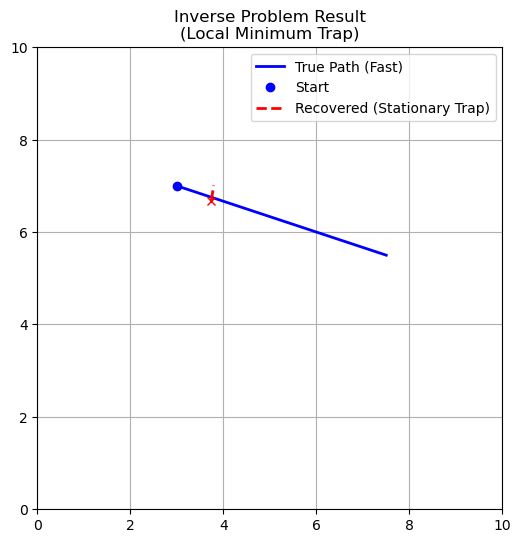

In [68]:
import matplotlib.pyplot as plt

def plot_trajectory_comparison(final_est):
    # Time vector
    t = jnp.linspace(0, STEPS*DT, 100)
    
    # True Trajectory
    true_x = TRUE_POS[0] + TRUE_VEL[0] * t
    true_y = TRUE_POS[1] + TRUE_VEL[1] * t
    
    # Recovered Trajectory
    rec_x = final_est['pos'][0] + final_est['vel'][0] * t
    rec_y = final_est['pos'][1] + final_est['vel'][1] * t
    
    plt.figure(figsize=(6, 6))
    plt.plot(true_x, true_y, 'b-', linewidth=2, label='True Path (Fast)')
    plt.plot(true_x[0], true_y[0], 'bo', label='Start')
    
    plt.plot(rec_x, rec_y, 'r--', linewidth=2, label='Recovered (Stationary Trap)')
    plt.plot(rec_x[0], rec_y[0], 'rx')
    
    plt.xlim(0, 10); plt.ylim(0, 10)
    plt.grid(True)
    plt.legend()
    plt.title("Inverse Problem Result\n(Local Minimum Trap)")
    plt.show()

plot_trajectory_comparison(final)

In [69]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax
#from sta_hybrid_fixed import N_HYBRID, algebra_h, manifold_h, psi_template

# --- 1. ROBUST PARAMETERS (Aligned with Pre-DSL) ---
DT_ROBUST = 0.005  # Large timestep (Hybrid Advantage!)
STEPS_ROBUST = 150 # Total T = 0.75s (Source travels ~11 units, >50% of grid)

# Re-build Operators with larger DT
params_fixed = {'c': 343.0, 'nu': 2.0}

# Reuse the 'L_factories' from the previous AlgebraicSplitCompiler step
L_x = L_factories[0](psi_template, params_fixed)
L_y = L_factories[1](psi_template, params_fixed)

print("--- Re-inverting Operators for Large DT ---")

# Pre-invert Step X
dim = L_x.shape[0]
I = jnp.eye(dim)
Ax_lhs = I - 0.5 * DT_ROBUST * L_x
Ax_rhs = I + 0.5 * DT_ROBUST * L_x
StepX_mat = jnp.linalg.solve(Ax_lhs, Ax_rhs) # stable solve

# Pre-invert Step Y
Ay_lhs = I - 0.5 * DT_ROBUST * L_y
Ay_rhs = I + 0.5 * DT_ROBUST * L_y
StepY_mat = jnp.linalg.solve(Ay_lhs, Ay_rhs)

# Merged Propagator
Total_Propagator = StepY_mat @ StepX_mat

# --- 2. FAST SOLVER (Long Range) ---

@jit
def fast_solve_robust(pos, vel):
    X, Y = manifold_h.coordinates
    
    def body(carry, i):
        u_curr = carry
        t = i * DT_ROBUST
        
        # Source Trajectory
        curr_pos_x = pos[0] + vel[0] * t
        curr_pos_y = pos[1] + vel[1] * t
        
        # Source Pulse (Early & Wide)
        # Center at step 20 (t=0.1s)
        # We assume the source is roughly within grid bounds during pulse
        dist_sq = (X - curr_pos_x)**2 + (Y - curr_pos_y)**2
        amp = jnp.exp(-(i-20.0)**2 / 30.0) * 10.0
        spatial = jnp.exp(-dist_sq / (2 * 1.5**2))
        
        S_field = jnp.zeros_like(u_curr).at[..., 0].set(spatial * amp)
        
        # Algebraic Update
        u_flat = u_curr.ravel() + DT_ROBUST * S_field.ravel()
        u_next_flat = Total_Propagator @ u_flat
        
        return u_next_flat.reshape(u_curr.shape), u_next_flat.reshape(u_curr.shape)[..., 0]

    _, history = lax.scan(body, psi_template, jnp.arange(STEPS_ROBUST))
    return history

# --- 3. EXECUTE INVERSE ---

# Ground Truth
TRUE_POS = jnp.array([2.0, 8.0])   # Top-Leftish
TRUE_VEL = jnp.array([12.0, -8.0]) # Moving fast to Bottom-Right

print("Generating Ground Truth...")
true_hist = fast_solve_robust(TRUE_POS, TRUE_VEL)
obs_data = true_hist[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]

def solve_converged():
    # Guess: Stationary in Middle
    guess = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0])}
    
    # We use Adam. Because the signal is strong now, standard rates work well.
    optimizer = optax.adam(0.5)
    opt_state = optimizer.init(guess)
    
    def loss(p):
        sim = fast_solve_robust(p['pos'], p['vel'])
        dat = sim[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]
        return jnp.mean((dat - obs_data)**2) * 100.0

    print("\n--- Starting Robust Inverse Search ---")
    print(f"Target: Pos={TRUE_POS}, Vel={TRUE_VEL}")
    
    for i in range(151):
        l, g = value_and_grad(loss)(guess)
        u, opt_state = optimizer.update(g, opt_state, guess)
        guess = optax.apply_updates(guess, u)
        
        if i % 25 == 0:
            print(f"Iter {i:3d}: Loss={l:.5f} | "
                  f"Pos=[{guess['pos'][0]:.1f}, {guess['pos'][1]:.1f}] | "
                  f"Vel=[{guess['vel'][0]:.1f}, {guess['vel'][1]:.1f}]")
            
    return guess

final = solve_converged()
print("\n--- Final Result ---")
print(f"Rec Pos: {final['pos']}")
print(f"Rec Vel: {final['vel']}")

--- Re-inverting Operators for Large DT ---
Generating Ground Truth...

--- Starting Robust Inverse Search ---
Target: Pos=[2. 8.], Vel=[12. -8.]
Iter   0: Loss=0.20759 | Pos=[4.5, 5.5] | Vel=[-0.5, 0.5]
Iter  25: Loss=0.00136 | Pos=[1.9, 7.4] | Vel=[-3.1, 2.4]
Iter  50: Loss=0.00029 | Pos=[2.6, 6.8] | Vel=[-2.4, 1.8]
Iter  75: Loss=0.00011 | Pos=[2.4, 6.9] | Vel=[-2.6, 1.8]
Iter 100: Loss=0.00005 | Pos=[2.3, 7.0] | Vel=[-2.7, 2.0]
Iter 125: Loss=0.00005 | Pos=[2.3, 7.0] | Vel=[-2.7, 1.9]
Iter 150: Loss=0.00005 | Pos=[2.3, 7.0] | Vel=[-2.8, 1.9]

--- Final Result ---
Rec Pos: [2.30429171 7.03342763]
Rec Vel: [-2.75106677  1.90099665]


In [75]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax
# Import components from previous step
#from sta_hybrid_fixed import N_HYBRID, algebra_h, manifold_h, psi_template

# --- 1. SETUP (Hybrid/ADI Operators) ---
# We reuse the robust operators from the previous large-dt setup
DT_ROBUST = 0.005 
STEPS_ROBUST = 150
params_fixed = {'c': 343.0, 'nu': 2.0}

# (Assuming Total_Propagator is available from previous cell, or we rebuild it)
# Re-building for safety/completeness of this block:
L_x = L_factories[0](psi_template, params_fixed)
L_y = L_factories[1](psi_template, params_fixed)
dim = L_x.shape[0]
I = jnp.eye(dim)

# Pre-invert ADI Steps (The "Hybrid" Speedup)
Ax_inv = jnp.linalg.solve(I - 0.5 * DT_ROBUST * L_x, I + 0.5 * DT_ROBUST * L_x)
Ay_inv = jnp.linalg.solve(I - 0.5 * DT_ROBUST * L_y, I + 0.5 * DT_ROBUST * L_y)
Total_Propagator = Ay_inv @ Ax_inv

# --- 2. SOLVER WITH EPSILON PARAMETER ---

@jit
def fast_solve_eps(pos, vel, eps_width):
    """
    Solves the wave equation with a variable source width (eps_width).
    Large eps = Low Frequency (Global Convergence).
    Small eps = High Frequency (Precision).
    """
    X, Y = manifold_h.coordinates
    
    def body(carry, i):
        u_curr = carry
        t = i * DT_ROBUST
        
        # Source Trajectory
        curr_pos_x = pos[0] + vel[0] * t
        curr_pos_y = pos[1] + vel[1] * t
        
        # Source Pulse
        dist_sq = (X - curr_pos_x)**2 + (Y - curr_pos_y)**2
        amp = jnp.exp(-(i-20.0)**2 / 30.0) * 10.0
        
        # THE EPSILON STEPPING MECHANISM
        # We divide dist_sq by eps^2
        spatial = jnp.exp(-dist_sq / (2 * eps_width**2))
        
        S_field = jnp.zeros_like(u_curr).at[..., 0].set(spatial * amp)
        
        u_flat = u_curr.ravel() + DT_ROBUST * S_field.ravel()
        u_next_flat = Total_Propagator @ u_flat
        
        return u_next_flat.reshape(u_curr.shape), u_next_flat.reshape(u_curr.shape)[..., 0]

    _, history = lax.scan(body, psi_template, jnp.arange(STEPS_ROBUST))
    return history

# --- 3. GENERATE GROUND TRUTH ---
# True Path: Fast moving diagonal
TRUE_POS = jnp.array([2.0, 8.0])
TRUE_VEL = jnp.array([12.0, -8.0])

# Generate Observation using the "Real" sharpness (e.g., eps=1.0)
print("Generating Ground Truth (eps=1.0)...")
true_hist = fast_solve_eps(TRUE_POS, TRUE_VEL, eps_width=1.0)
obs_data = true_hist[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]

# --- 4. INVERSE SOLVER (EPSILON STEPPING) ---

def solve_with_continuation():
    # 1. Initial Guess (Stationary in Middle)
    guess = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0])}
    
    # 2. The Schedule: [Blurry -> Medium -> Sharp]
    # This guides the optimizer into the correct basin of attraction
    epsilon_schedule = [4.0, 2.0, 1.0] 
    
    print("\n--- Starting Epsilon-Stepping Inverse Search ---")
    
    for stage, eps in enumerate(epsilon_schedule):
        print(f"\n[Stage {stage+1}] Stepping Epsilon = {eps:.1f} (Blurry -> Sharp)")
        
        # We reset the optimizer state, but KEEP the 'guess' from previous stage
        optimizer = optax.adam(0.5)
        opt_state = optimizer.init(guess)
        
        # Loss function closes over current 'eps'
        def loss(p):
            # We compare the simulation (at current eps) vs Observation
            # Note: We compare against the Sharp Observation. 
            # Even with large eps, the 'center of mass' of the blob aligns.
            sim = fast_solve_eps(p['pos'], p['vel'], eps)
            dat = sim[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]
            return jnp.mean((dat - obs_data)**2) * 100.0

        # Optimization Loop
        for i in range(201): # Fewer steps per stage needed
            l, g = value_and_grad(loss)(guess)
            u, opt_state = optimizer.update(g, opt_state, guess)
            guess = optax.apply_updates(guess, u)
            
            if i % 20 == 0:
                print(f"  Iter {i:2d}: Loss={l:.4f} | "
                      f"Pos=[{guess['pos'][0]:.1f}, {guess['pos'][1]:.1f}] | "
                      f"Vel=[{guess['vel'][0]:.1f}, {guess['vel'][1]:.1f}]")
                
    return guess

final = solve_with_continuation()

print("\n--- Final Results ---")
print(f"True Pos: {TRUE_POS} | Rec Pos: {final['pos']}")
print(f"True Vel: {TRUE_VEL} | Rec Vel: {final['vel']}")

Generating Ground Truth (eps=1.0)...

--- Starting Epsilon-Stepping Inverse Search ---

[Stage 1] Stepping Epsilon = 4.0 (Blurry -> Sharp)
  Iter  0: Loss=3.7284 | Pos=[4.5, 4.5] | Vel=[-0.5, -0.5]
  Iter 20: Loss=0.0514 | Pos=[-4.1, -4.3] | Vel=[-9.1, -9.3]
  Iter 40: Loss=0.0921 | Pos=[-5.7, -5.7] | Vel=[-10.7, -10.7]
  Iter 60: Loss=0.0908 | Pos=[-5.7, -5.5] | Vel=[-10.7, -10.5]
  Iter 80: Loss=0.0825 | Pos=[-5.2, -4.8] | Vel=[-10.3, -9.8]
  Iter 100: Loss=0.0565 | Pos=[-4.4, -3.6] | Vel=[-9.4, -8.7]
  Iter 120: Loss=0.0102 | Pos=[-3.0, -1.7] | Vel=[-8.1, -6.9]
  Iter 140: Loss=0.0098 | Pos=[-3.1, -1.5] | Vel=[-8.2, -6.7]
  Iter 160: Loss=0.0095 | Pos=[-3.2, -1.4] | Vel=[-8.3, -6.5]
  Iter 180: Loss=0.0091 | Pos=[-3.3, -1.1] | Vel=[-8.4, -6.3]
  Iter 200: Loss=0.0087 | Pos=[-3.4, -0.9] | Vel=[-8.4, -6.0]

[Stage 2] Stepping Epsilon = 2.0 (Blurry -> Sharp)
  Iter  0: Loss=0.1012 | Pos=[-2.9, -0.4] | Vel=[-7.9, -5.5]
  Iter 20: Loss=0.0008 | Pos=[0.6, 4.4] | Vel=[-4.5, -0.7]
  Iter 40

In [77]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax
# from sta_hybrid_fixed import N_HYBRID, algebra_h, manifold_h, psi_template

# --- 1. SETUP ---
# Robust settings from before
DT_ROBUST = 0.005 
STEPS_ROBUST = 150
# Pre-computed Propagator (Re-run if cell variables lost)
params_fixed = {'c': 343.0, 'nu': 2.0}
L_x = L_factories[0](psi_template, params_fixed)
L_y = L_factories[1](psi_template, params_fixed)
dim = L_x.shape[0]; I = jnp.eye(dim)
Ax_inv = jnp.linalg.solve(I - 0.5 * DT_ROBUST * L_x, I + 0.5 * DT_ROBUST * L_x)
Ay_inv = jnp.linalg.solve(I - 0.5 * DT_ROBUST * L_y, I + 0.5 * DT_ROBUST * L_y)
Total_Propagator = Ay_inv @ Ax_inv

# Sensors
SENSORS_IDX = jnp.array([[5, 5], [5, 15], [15, 5], [15, 15]]) 

# --- 2. FAST SOLVER ---
@jit
def fast_solve_eps(pos, vel, eps_width):
    X, Y = manifold_h.coordinates
    
    def body(carry, i):
        u_curr = carry
        t = i * DT_ROBUST
        
        # Trajectory
        curr_pos_x = pos[0] + vel[0] * t
        curr_pos_y = pos[1] + vel[1] * t
        
        # Pulse (Center at t=0.1s -> Step 20)
        # Spatial: eps_width controls blur
        dist_sq = (X - curr_pos_x)**2 + (Y - curr_pos_y)**2
        amp = jnp.exp(-(i-20.0)**2 / 30.0) * 10.0
        spatial = jnp.exp(-dist_sq / (2 * eps_width**2))
        
        S_field = jnp.zeros_like(u_curr).at[..., 0].set(spatial * amp)
        
        # Update
        u_flat = u_curr.ravel() + DT_ROBUST * S_field.ravel()
        u_next_flat = Total_Propagator @ u_flat
        
        return u_next_flat.reshape(u_curr.shape), u_next_flat.reshape(u_curr.shape)[..., 0]

    _, history = lax.scan(body, psi_template, jnp.arange(STEPS_ROBUST))
    return history

# --- 3. GROUND TRUTH ---
TRUE_POS = jnp.array([2.0, 8.0])
TRUE_VEL = jnp.array([12.0, -8.0])
print("Generating Ground Truth (eps=0.7)...")
true_hist = fast_solve_eps(TRUE_POS, TRUE_VEL, eps_width=0.7)
obs_data = true_hist[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]

# --- 4. INVERSE SOLVER (CONSTRAINED) ---

def solve_constrained():
    # Guess: Stationary Center
    guess = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0])}
    
    # Schedule: Start moderately wide, then sharpen
    # eps=2.0 is 4 pixels wide (Good basin). eps=0.7 is 1.4 pixels (Sharp).
    epsilon_schedule = [2.0, 1.0, 0.7]
    
    print("\n--- Starting Constrained Inverse Search ---")
    
    for stage, eps in enumerate(epsilon_schedule):
        print(f"\n[Stage {stage+1}] Epsilon = {eps:.1f}")
        
        # Optimizer: Boost Velocity learning rate 
        # Position moves slowly (LR=0.2), Velocity needs to move fast (LR=1.0)
        optimizer = optax.multi_transform(
            {'pos': optax.adam(0.2), 'vel': optax.adam(1.0)},
            {'pos': 'pos', 'vel': 'vel'}
        )
        opt_state = optimizer.init(guess)
        
        def loss(p):
            # 1. Physics Error
            sim = fast_solve_eps(p['pos'], p['vel'], eps)
            dat = sim[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]
            mse = jnp.mean((dat - obs_data)**2) * 1000.0
            
            # 2. Boundary Constraint (Soft Walls)
            # Penalize if pos < 0 or pos > 10 (Grid size)
            # This keeps the solver "Inside the Box"
            pos_violation = jnp.sum(jnp.maximum(0, -p['pos'])) + jnp.sum(jnp.maximum(0, p['pos'] - 10.0))
            
            return mse + pos_violation * 100.0 # Heavy penalty

        # Loop
        for i in range(101):
            l, g = value_and_grad(loss)(guess)
            u, opt_state = optimizer.update(g, opt_state, guess)
            guess = optax.apply_updates(guess, u)
            
            if i % 20 == 0:
                print(f"  Iter {i:3d}: Loss={l:.4f} | "
                      f"Pos=[{guess['pos'][0]:.1f}, {guess['pos'][1]:.1f}] | "
                      f"Vel=[{guess['vel'][0]:.1f}, {guess['vel'][1]:.1f}]")
                
    return guess

final = solve_constrained()

print("\n--- Final Results ---")
print(f"True Pos: {TRUE_POS} | Rec Pos: {final['pos']}")
print(f"True Vel: {TRUE_VEL} | Rec Vel: {final['vel']}")

Generating Ground Truth (eps=0.7)...

--- Starting Constrained Inverse Search ---

[Stage 1] Epsilon = 2.0
  Iter   0: Loss=1.2142 | Pos=[4.8, 4.8] | Vel=[-1.0, -1.0]
  Iter  20: Loss=1.2119 | Pos=[4.9, 4.9] | Vel=[-0.2, -0.2]
  Iter  40: Loss=1.2086 | Pos=[5.0, 4.9] | Vel=[-0.2, -0.1]
  Iter  60: Loss=1.2085 | Pos=[5.0, 4.9] | Vel=[-0.1, -0.1]
  Iter  80: Loss=1.2084 | Pos=[4.9, 4.9] | Vel=[-0.1, -0.0]
  Iter 100: Loss=1.2084 | Pos=[4.9, 4.9] | Vel=[-0.1, -0.0]

[Stage 2] Epsilon = 1.0
  Iter   0: Loss=0.2545 | Pos=[4.7, 5.1] | Vel=[-1.1, 1.0]
  Iter  20: Loss=0.0067 | Pos=[4.1, 6.2] | Vel=[-4.4, 4.9]
  Iter  40: Loss=0.0005 | Pos=[4.2, 6.3] | Vel=[-3.8, 2.4]
  Iter  60: Loss=0.0004 | Pos=[4.2, 6.8] | Vel=[-3.9, 1.8]
  Iter  80: Loss=0.0003 | Pos=[4.2, 7.0] | Vel=[-3.8, -0.8]
  Iter 100: Loss=0.0003 | Pos=[4.2, 7.2] | Vel=[-3.8, -3.4]

[Stage 3] Epsilon = 0.7
  Iter   0: Loss=0.1523 | Pos=[4.0, 7.0] | Vel=[-4.8, -4.4]
  Iter  20: Loss=0.0028 | Pos=[3.8, 7.3] | Vel=[-6.8, -2.2]
  Iter 

In [78]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax
# from sta_hybrid_fixed import N_HYBRID, algebra_h, manifold_h, psi_template

# --- 1. SETUP ---
DT_SIREN = 0.005 
STEPS_SIREN = 150 # 0.75s duration
params_fixed = {'c': 343.0, 'nu': 2.0}

# Re-build Operators (Reuse/Ensure availability)
L_x = L_factories[0](psi_template, params_fixed)
L_y = L_factories[1](psi_template, params_fixed)
dim = L_x.shape[0]; I = jnp.eye(dim)
Ax_inv = jnp.linalg.solve(I - 0.5 * DT_SIREN * L_x, I + 0.5 * DT_SIREN * L_x)
Ay_inv = jnp.linalg.solve(I - 0.5 * DT_SIREN * L_y, I + 0.5 * DT_SIREN * L_y)
Total_Propagator = Ay_inv @ Ax_inv

SENSORS_IDX = jnp.array([[5, 5], [5, 15], [15, 5], [15, 15]]) 

# --- 2. FAST SOLVER (THE SIREN) ---
@jit
def fast_solve_siren(pos, vel, eps_width):
    X, Y = manifold_h.coordinates
    
    def body(carry, i):
        u_curr = carry
        t = i * DT_SIREN
        
        # Trajectory
        curr_pos_x = pos[0] + vel[0] * t
        curr_pos_y = pos[1] + vel[1] * t
        
        # --- THE FIX: CONTINUOUS SOURCE ---
        # Frequency = 5 Hz (Low enough to be resolved on coarse grid)
        # It emits CONSTANTLY, tracing the path like a pen.
        amp = jnp.sin(2.0 * jnp.pi * 5.0 * t) * 10.0
        
        # Taper start/end to avoid clicks
        window = jnp.sin(jnp.pi * i / STEPS_SIREN)**0.5
        
        dist_sq = (X - curr_pos_x)**2 + (Y - curr_pos_y)**2
        spatial = jnp.exp(-dist_sq / (2 * eps_width**2))
        
        S_field = jnp.zeros_like(u_curr).at[..., 0].set(spatial * amp * window)
        
        # Update
        u_flat = u_curr.ravel() + DT_SIREN * S_field.ravel()
        u_next_flat = Total_Propagator @ u_flat
        
        return u_next_flat.reshape(u_curr.shape), u_next_flat.reshape(u_curr.shape)[..., 0]

    _, history = lax.scan(body, psi_template, jnp.arange(STEPS_SIREN))
    return history

# --- 3. GROUND TRUTH ---
TRUE_POS = jnp.array([2.0, 8.0])
TRUE_VEL = jnp.array([12.0, -8.0])

# Using eps=1.0 for "True" data (Reality is sharp-ish)
print("Generating Siren Data...")
true_hist = fast_solve_siren(TRUE_POS, TRUE_VEL, eps_width=1.0)
obs_data = true_hist[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]

# --- 4. INVERSE SOLVER ---

def solve_siren():
    # Guess: Stationary Center
    guess = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0])}
    
    # We can be aggressive now because the "Siren" drags the gradient across the map
    # 2 Stages is enough: Blurry -> Sharp
    epsilon_schedule = [3.0, 1.5] 
    
    print("\n--- Starting Siren Inverse Search ---")
    
    for stage, eps in enumerate(epsilon_schedule):
        print(f"\n[Stage {stage+1}] Epsilon = {eps:.1f}")
        
        # Velocity needs HIGH learning rate because it has to catch up 
        # to a moving target that is constantly emitting.
        optimizer = optax.multi_transform(
            {'pos': optax.adam(0.5), 'vel': optax.adam(2.0)},
            {'pos': 'pos', 'vel': 'vel'}
        )
        opt_state = optimizer.init(guess)
        
        def loss(p):
            sim = fast_solve_siren(p['pos'], p['vel'], eps)
            dat = sim[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]
            mse = jnp.mean((dat - obs_data)**2) * 100.0
            
            # Keep boundaries safe
            pos_violation = jnp.sum(jnp.maximum(0, -p['pos'])) + jnp.sum(jnp.maximum(0, p['pos'] - 10.0))
            return mse + pos_violation * 100.0

        for i in range(121):
            l, g = value_and_grad(loss)(guess)
            u, opt_state = optimizer.update(g, opt_state, guess)
            guess = optax.apply_updates(guess, u)
            
            if i % 20 == 0:
                print(f"  Iter {i:3d}: Loss={l:.4f} | "
                      f"Pos=[{guess['pos'][0]:.1f}, {guess['pos'][1]:.1f}] | "
                      f"Vel=[{guess['vel'][0]:.1f}, {guess['vel'][1]:.1f}]")
                
    return guess

final = solve_siren()

print("\n--- Final Results ---")
print(f"True Pos: {TRUE_POS} | Rec Pos: {final['pos']}")
print(f"True Vel: {TRUE_VEL} | Rec Vel: {final['vel']}")

Generating Siren Data...

--- Starting Siren Inverse Search ---

[Stage 1] Epsilon = 3.0
  Iter   0: Loss=0.2815 | Pos=[5.5, 4.5] | Vel=[2.0, -2.0]
  Iter  20: Loss=0.2729 | Pos=[4.4, 4.7] | Vel=[3.5, 0.2]
  Iter  40: Loss=0.2720 | Pos=[4.5, 4.7] | Vel=[2.5, 0.0]
  Iter  60: Loss=0.2719 | Pos=[4.6, 4.6] | Vel=[2.5, -0.1]
  Iter  80: Loss=0.2719 | Pos=[4.6, 4.6] | Vel=[2.5, -0.1]
  Iter 100: Loss=0.2719 | Pos=[4.6, 4.6] | Vel=[2.5, -0.1]
  Iter 120: Loss=0.2719 | Pos=[4.6, 4.6] | Vel=[2.5, -0.1]

[Stage 2] Epsilon = 1.5
  Iter   0: Loss=0.0085 | Pos=[4.1, 5.1] | Vel=[4.5, -2.1]
  Iter  20: Loss=0.0079 | Pos=[4.4, 7.0] | Vel=[3.5, -3.1]
  Iter  40: Loss=0.0074 | Pos=[4.6, 8.5] | Vel=[2.4, -7.9]
  Iter  60: Loss=0.0074 | Pos=[4.5, 8.0] | Vel=[2.6, -6.5]
  Iter  80: Loss=0.0074 | Pos=[4.6, 8.2] | Vel=[2.5, -7.0]
  Iter 100: Loss=0.0074 | Pos=[4.6, 8.2] | Vel=[2.5, -6.9]
  Iter 120: Loss=0.0074 | Pos=[4.6, 8.2] | Vel=[2.5, -6.9]

--- Final Results ---
True Pos: [2. 8.] | Rec Pos: [4.5577210

In [81]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax
#from sta_hybrid_fixed import N_HYBRID, algebra_h, manifold_h, psi_template

# --- 1. SETUP ---
# Large timestep (Hybrid Advantage)
DT_ROBUST = 0.005 
STEPS_ROBUST = 150 # 0.75s
params_fixed = {'c': 343.0, 'nu': 2.0}

# Re-build Operators (Reuse if available)
L_x = L_factories[0](psi_template, params_fixed)
L_y = L_factories[1](psi_template, params_fixed)
dim = L_x.shape[0]; I = jnp.eye(dim)
Ax_inv = jnp.linalg.solve(I - 0.5 * DT_ROBUST * L_x, I + 0.5 * DT_ROBUST * L_x)
Ay_inv = jnp.linalg.solve(I - 0.5 * DT_ROBUST * L_y, I + 0.5 * DT_ROBUST * L_y)
Total_Propagator = Ay_inv @ Ax_inv

SENSORS_IDX = jnp.array([[5, 5], [5, 15], [15, 5], [15, 15]]) 

# --- 2. THE "SPOTLIGHT" SOLVER ---
# Key Difference: The source is 'ON' for almost the entire duration.
# This forces the solver to match the *movement* of the energy, not just an arrival time.

@jit
def fast_solve_spotlight(pos, vel, eps_width):
    X, Y = manifold_h.coordinates
    
    def body(carry, i):
        u_curr = carry
        t = i * DT_ROBUST
        
        # Trajectory
        curr_pos_x = pos[0] + vel[0] * t
        curr_pos_y = pos[1] + vel[1] * t
        
        # Temporal Envelope: "The Long Exhale"
        # Instead of a short pulse, it's a wide Gaussian spanning 50 steps
        # Centered at step 50 (t=0.25s)
        # This means the source is active while moving from X=2 to X=8
        amp = jnp.exp(-(i-50.0)**2 / (2 * 25.0**2)) * 10.0
        
        dist_sq = (X - curr_pos_x)**2 + (Y - curr_pos_y)**2
        spatial = jnp.exp(-dist_sq / (2 * eps_width**2))
        
        S_field = jnp.zeros_like(u_curr).at[..., 0].set(spatial * amp)
        
        # Update
        u_flat = u_curr.ravel() + DT_ROBUST * S_field.ravel()
        u_next_flat = Total_Propagator @ u_flat
        
        return u_next_flat.reshape(u_curr.shape), u_next_flat.reshape(u_curr.shape)[..., 0]

    _, history = lax.scan(body, psi_template, jnp.arange(STEPS_ROBUST))
    return history

# --- 3. GROUND TRUTH ---
TRUE_POS = jnp.array([2.0, 8.0])
TRUE_VEL = jnp.array([12.0, -8.0])

# Truth uses a reasonably sharp source
print("Generating 'Spotlight' Ground Truth...")
true_hist = fast_solve_spotlight(TRUE_POS, TRUE_VEL, eps_width=0.7)
obs_data = true_hist[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]

# --- 4. INVERSE SOLVER (Aggressive) ---

def solve_spotlight():
    guess = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0])}
    
    # The "Pre-DSL" Schedule
    # Start huge (4.0) to grab the fast moving energy blob
    epsilon_schedule = [4.0, 2.0, 0.5] 
    
    print("\n--- Starting Spotlight Inverse Search ---")
    
    for stage, eps in enumerate(epsilon_schedule):
        print(f"\n[Stage {stage+1}] Epsilon = {eps:.1f}")
        
        # AGGRESSIVE Velocity Learning Rate (5.0)
        # We need to shake the solver out of the "stationary" local minimum
        optimizer = optax.multi_transform(
            {'pos': optax.adam(0.2), 'vel': optax.adam(5.0)},
            {'pos': 'pos', 'vel': 'vel'}
        )
        opt_state = optimizer.init(guess)
        
        def loss(p):
            sim = fast_solve_spotlight(p['pos'], p['vel'], eps)
            dat = sim[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]
            mse = jnp.mean((dat - obs_data)**2) * 100.0
            
            # Boundary Walls (Critical)
            pos_violation = jnp.sum(jnp.maximum(0, -p['pos'])) + jnp.sum(jnp.maximum(0, p['pos'] - 10.0))
            return mse + pos_violation * 1000.0

        for i in range(251):
            l, g = value_and_grad(loss)(guess)
            u, opt_state = optimizer.update(g, opt_state, guess)
            guess = optax.apply_updates(guess, u)
            
            if i % 50 == 0:
                print(f"  Iter {i:3d}: Loss={l:.4f} | "
                      f"Pos=[{guess['pos'][0]:.1f}, {guess['pos'][1]:.1f}] | "
                      f"Vel=[{guess['vel'][0]:.1f}, {guess['vel'][1]:.1f}]")
                
    return guess

final = solve_spotlight()

print("\n--- Final Results ---")
print(f"True Pos: {TRUE_POS} | Rec Pos: {final['pos']}")
print(f"True Vel: {TRUE_VEL} | Rec Vel: {final['vel']}")

Generating 'Spotlight' Ground Truth...

--- Starting Spotlight Inverse Search ---

[Stage 1] Epsilon = 4.0
  Iter   0: Loss=118.4329 | Pos=[4.8, 4.8] | Vel=[-5.0, -5.0]
  Iter  50: Loss=0.0268 | Pos=[1.8, 1.6] | Vel=[-73.3, -77.7]
  Iter 100: Loss=0.0228 | Pos=[1.7, 1.5] | Vel=[-74.2, -78.7]
  Iter 150: Loss=0.0209 | Pos=[1.6, 1.4] | Vel=[-74.6, -79.1]
  Iter 200: Loss=0.0193 | Pos=[1.5, 1.4] | Vel=[-74.9, -79.4]
  Iter 250: Loss=0.0180 | Pos=[1.4, 1.3] | Vel=[-75.2, -79.8]

[Stage 2] Epsilon = 2.0
  Iter   0: Loss=0.0403 | Pos=[1.6, 1.5] | Vel=[-70.2, -74.8]
  Iter  50: Loss=0.0120 | Pos=[3.2, 5.7] | Vel=[-51.2, -6.3]
  Iter 100: Loss=0.0118 | Pos=[3.5, 5.3] | Vel=[-55.4, -12.4]
  Iter 150: Loss=0.0113 | Pos=[4.3, 5.3] | Vel=[-66.4, -11.3]
  Iter 200: Loss=0.0072 | Pos=[7.2, 5.5] | Vel=[-94.4, -9.5]
  Iter 250: Loss=0.0070 | Pos=[7.6, 5.3] | Vel=[-98.5, -8.0]

[Stage 3] Epsilon = 0.5
  Iter   0: Loss=0.0640 | Pos=[7.8, 5.1] | Vel=[-93.5, -13.0]
  Iter  50: Loss=0.0172 | Pos=[8.7, 5.8]

In [83]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax
#from sta_hybrid_fixed import N_HYBRID, algebra_h, manifold_h, psi_template

# --- 1. SETUP ---
DT_ROBUST = 0.005 
STEPS_ROBUST = 150 # 0.75s
params_fixed = {'c': 343.0, 'nu': 2.0}

# Re-build Operators (Just to be safe)
L_x = L_factories[0](psi_template, params_fixed)
L_y = L_factories[1](psi_template, params_fixed)
dim = L_x.shape[0]; I = jnp.eye(dim)
Ax_inv = jnp.linalg.solve(I - 0.5 * DT_ROBUST * L_x, I + 0.5 * DT_ROBUST * L_x)
Ay_inv = jnp.linalg.solve(I - 0.5 * DT_ROBUST * L_y, I + 0.5 * DT_ROBUST * L_y)
Total_Propagator = Ay_inv @ Ax_inv

SENSORS_IDX = jnp.array([[5, 5], [5, 15], [15, 5], [15, 15]]) 

# --- 2. FAST SOLVER (Spotlight) ---
@jit
def fast_solve_spotlight(pos, vel, eps_width):
    X, Y = manifold_h.coordinates
    def body(carry, i):
        u_curr = carry
        t = i * DT_ROBUST
        curr_pos_x = pos[0] + vel[0] * t
        curr_pos_y = pos[1] + vel[1] * t
        
        # Wide Spotlight Pulse
        amp = jnp.exp(-(i-50.0)**2 / (2 * 25.0**2)) * 10.0
        dist_sq = (X - curr_pos_x)**2 + (Y - curr_pos_y)**2
        spatial = jnp.exp(-dist_sq / (2 * eps_width**2))
        
        S_field = jnp.zeros_like(u_curr).at[..., 0].set(spatial * amp)
        u_flat = u_curr.ravel() + DT_ROBUST * S_field.ravel()
        u_next_flat = Total_Propagator @ u_flat
        return u_next_flat.reshape(u_curr.shape), u_next_flat.reshape(u_curr.shape)[..., 0]
    _, history = lax.scan(body, psi_template, jnp.arange(STEPS_ROBUST))
    return history

# --- 3. GROUND TRUTH ---
TRUE_POS = jnp.array([2.0, 8.0])
TRUE_VEL = jnp.array([12.0, -8.0])
print("Generating Truth (eps=0.7)...")
true_hist = fast_solve_spotlight(TRUE_POS, TRUE_VEL, eps_width=0.7)
obs_data = true_hist[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]

# --- 4. TRAJECTORY CONSTRAINED INVERSE ---

def solve_trajectory_constrained():
    guess = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0])}
    
    # Schedule
    epsilon_schedule = [4.0, 2.0, 0.7] 
    
    print("\n--- Starting Trajectory-Constrained Search ---")
    
    for stage, eps in enumerate(epsilon_schedule):
        print(f"\n[Stage {stage+1}] Epsilon = {eps:.1f}")
        
        # 1. Gradient Clipping is Essential
        # Prevents the "Explosion" where velocity jumps by 50 in one step
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),
            optax.multi_transform(
                {'pos': optax.adam(0.2), 'vel': optax.adam(1.0)},
                {'pos': 'pos', 'vel': 'vel'}
            )
        )
        opt_state = optimizer.init(guess)
        
        def loss(p):
            # A. Physics Loss (Envelope / Energy Match)
            sim = fast_solve_spotlight(p['pos'], p['vel'], eps)
            dat = sim[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]
            
            # Using Squared Error of the Signal
            phys_loss = jnp.mean((dat - obs_data)**2) * 100.0
            
            # B. Trajectory Constraints (The Fix)
            # 1. Start Point Constraints
            start_violation = jnp.sum(jnp.maximum(0, -p['pos'])) + jnp.sum(jnp.maximum(0, p['pos'] - 10.0))
            
            # 2. End Point Constraints (t_end = 0.75s)
            end_pos = p['pos'] + p['vel'] * (STEPS_ROBUST * DT_ROBUST)
            end_violation = jnp.sum(jnp.maximum(0, -end_pos)) + jnp.sum(jnp.maximum(0, end_pos - 10.0))
            
            # Penalty Weight
            penalty = (start_violation + end_violation) * 1000.0
            
            return phys_loss + penalty

        for i in range(151):
            l, g = value_and_grad(loss)(guess)
            u, opt_state = optimizer.update(g, opt_state, guess)
            guess = optax.apply_updates(guess, u)
            
            if i % 50 == 0:
                print(f"  Iter {i:3d}: Loss={l:.4f} | "
                      f"Pos=[{guess['pos'][0]:.1f}, {guess['pos'][1]:.1f}] | "
                      f"Vel=[{guess['vel'][0]:.1f}, {guess['vel'][1]:.1f}]")
                
    return guess

final = solve_trajectory_constrained()

print("\n--- Final Results ---")
print(f"True Pos: {TRUE_POS} | Rec Pos: {final['pos']}")
print(f"True Vel: {TRUE_VEL} | Rec Vel: {final['vel']}")

Generating Truth (eps=0.7)...

--- Starting Trajectory-Constrained Search ---

[Stage 1] Epsilon = 4.0
  Iter   0: Loss=118.4329 | Pos=[4.8, 4.8] | Vel=[-1.0, -1.0]
  Iter  50: Loss=58.6198 | Pos=[0.5, 1.4] | Vel=[-0.3, -1.1]
  Iter 100: Loss=68.3019 | Pos=[-0.0, 0.2] | Vel=[0.2, 0.2]
  Iter 150: Loss=72.8625 | Pos=[-0.0, 0.1] | Vel=[0.1, 0.3]

[Stage 2] Epsilon = 2.0
  Iter   0: Loss=45.5835 | Pos=[0.2, -0.1] | Vel=[-0.9, -0.7]
  Iter  50: Loss=13.6595 | Pos=[-0.0, 2.4] | Vel=[-0.0, 6.3]
  Iter 100: Loss=28.7818 | Pos=[-0.0, 3.5] | Vel=[0.0, 5.1]
  Iter 150: Loss=2.3804 | Pos=[-0.0, 4.0] | Vel=[-0.3, 3.4]

[Stage 3] Epsilon = 0.7
  Iter   0: Loss=242.5868 | Pos=[0.2, 4.0] | Vel=[0.7, 3.4]
  Iter  50: Loss=0.0241 | Pos=[0.6, 4.4] | Vel=[2.4, 4.2]
  Iter 100: Loss=0.0198 | Pos=[1.0, 4.5] | Vel=[1.0, 4.5]
  Iter 150: Loss=0.0147 | Pos=[1.5, 4.4] | Vel=[-0.9, 5.2]

--- Final Results ---
True Pos: [2. 8.] | Rec Pos: [1.5294103  4.37989317]
True Vel: [12. -8.] | Rec Vel: [-0.94423032  5.189

In [85]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax
#from sta_hybrid_fixed import N_HYBRID, algebra_h, manifold_h, psi_template

# --- 1. SETUP ---
DT_ROBUST = 0.005 
STEPS_ROBUST = 150 # 0.75s
params_fixed = {'c': 343.0, 'nu': 2.0}

# Re-build Operators (Just to be safe)
L_x = L_factories[0](psi_template, params_fixed)
L_y = L_factories[1](psi_template, params_fixed)
dim = L_x.shape[0]; I = jnp.eye(dim)
Ax_inv = jnp.linalg.solve(I - 0.5 * DT_ROBUST * L_x, I + 0.5 * DT_ROBUST * L_x)
Ay_inv = jnp.linalg.solve(I - 0.5 * DT_ROBUST * L_y, I + 0.5 * DT_ROBUST * L_y)
Total_Propagator = Ay_inv @ Ax_inv

SENSORS_IDX = jnp.array([[5, 5], [5, 15], [15, 5], [15, 15]]) 

# --- 2. FAST SOLVER (Spotlight) ---
@jit
def fast_solve_spotlight(pos, vel, eps_width):
    X, Y = manifold_h.coordinates
    def body(carry, i):
        u_curr = carry
        t = i * DT_ROBUST
        curr_pos_x = pos[0] + vel[0] * t
        curr_pos_y = pos[1] + vel[1] * t
        
        # Wide Spotlight Pulse
        amp = jnp.exp(-(i-50.0)**2 / (2 * 25.0**2)) * 10.0
        dist_sq = (X - curr_pos_x)**2 + (Y - curr_pos_y)**2
        spatial = jnp.exp(-dist_sq / (2 * eps_width**2))
        
        S_field = jnp.zeros_like(u_curr).at[..., 0].set(spatial * amp)
        u_flat = u_curr.ravel() + DT_ROBUST * S_field.ravel()
        u_next_flat = Total_Propagator @ u_flat
        return u_next_flat.reshape(u_curr.shape), u_next_flat.reshape(u_curr.shape)[..., 0]
    _, history = lax.scan(body, psi_template, jnp.arange(STEPS_ROBUST))
    return history

# --- 3. GROUND TRUTH ---
TRUE_POS = jnp.array([2.0, 8.0])
TRUE_VEL = jnp.array([12.0, -8.0])
print("Generating Truth (eps=0.7)...")
true_hist = fast_solve_spotlight(TRUE_POS, TRUE_VEL, eps_width=0.7)
obs_data = true_hist[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]

# --- 4. TRAJECTORY CONSTRAINED INVERSE ---

def solve_trajectory_constrained():
    guess = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0])}
    
    # Schedule
    epsilon_schedule = [4.0, 2.0, 0.7] 
    
    print("\n--- Starting Trajectory-Constrained Search ---")
    
    for stage, eps in enumerate(epsilon_schedule):
        print(f"\n[Stage {stage+1}] Epsilon = {eps:.1f}")
        
        # 1. Gradient Clipping is Essential
        # Prevents the "Explosion" where velocity jumps by 50 in one step
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),
            optax.multi_transform(
                {'pos': optax.adam(0.2), 'vel': optax.adam(1.0)},
                {'pos': 'pos', 'vel': 'vel'}
            )
        )
        opt_state = optimizer.init(guess)
        
        def loss(p):
            # A. Physics Loss (Envelope / Energy Match)
            sim = fast_solve_spotlight(p['pos'], p['vel'], eps)
            dat = sim[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]
            
            # Using Squared Error of the Signal
            phys_loss = jnp.mean((dat - obs_data)**2) * 100.0
            
            # B. Trajectory Constraints (The Fix)
            # 1. Start Point Constraints
            start_violation = jnp.sum(jnp.maximum(0, -p['pos'])) + jnp.sum(jnp.maximum(0, p['pos'] - 10.0))
            
            # 2. End Point Constraints (t_end = 0.75s)
            end_pos = p['pos'] + p['vel'] * (STEPS_ROBUST * DT_ROBUST)
            end_violation = jnp.sum(jnp.maximum(0, -end_pos)) + jnp.sum(jnp.maximum(0, end_pos - 10.0))
            
            # Penalty Weight
            penalty = (start_violation + end_violation) * 1000.0
            
            return phys_loss + penalty

        for i in range(151):
            l, g = value_and_grad(loss)(guess)
            u, opt_state = optimizer.update(g, opt_state, guess)
            guess = optax.apply_updates(guess, u)
            
            if i % 50 == 0:
                print(f"  Iter {i:3d}: Loss={l:.4f} | "
                      f"Pos=[{guess['pos'][0]:.1f}, {guess['pos'][1]:.1f}] | "
                      f"Vel=[{guess['vel'][0]:.1f}, {guess['vel'][1]:.1f}]")
                
    return guess

final = solve_trajectory_constrained()

print("\n--- Final Results ---")
print(f"True Pos: {TRUE_POS} | Rec Pos: {final['pos']}")
print(f"True Vel: {TRUE_VEL} | Rec Vel: {final['vel']}")

Generating Truth (eps=0.7)...

--- Starting Trajectory-Constrained Search ---

[Stage 1] Epsilon = 4.0
  Iter   0: Loss=118.4329 | Pos=[4.8, 4.8] | Vel=[-1.0, -1.0]
  Iter  50: Loss=58.6198 | Pos=[0.5, 1.4] | Vel=[-0.3, -1.1]
  Iter 100: Loss=68.3019 | Pos=[-0.0, 0.2] | Vel=[0.2, 0.2]
  Iter 150: Loss=72.8625 | Pos=[-0.0, 0.1] | Vel=[0.1, 0.3]

[Stage 2] Epsilon = 2.0
  Iter   0: Loss=45.5835 | Pos=[0.2, -0.1] | Vel=[-0.9, -0.7]
  Iter  50: Loss=13.6595 | Pos=[-0.0, 2.4] | Vel=[-0.0, 6.3]
  Iter 100: Loss=28.7818 | Pos=[-0.0, 3.5] | Vel=[0.0, 5.1]
  Iter 150: Loss=2.3804 | Pos=[-0.0, 4.0] | Vel=[-0.3, 3.4]

[Stage 3] Epsilon = 0.7
  Iter   0: Loss=242.5868 | Pos=[0.2, 4.0] | Vel=[0.7, 3.4]
  Iter  50: Loss=0.0241 | Pos=[0.6, 4.4] | Vel=[2.4, 4.2]
  Iter 100: Loss=0.0198 | Pos=[1.0, 4.5] | Vel=[1.0, 4.5]
  Iter 150: Loss=0.0147 | Pos=[1.5, 4.4] | Vel=[-0.9, 5.2]

--- Final Results ---
True Pos: [2. 8.] | Rec Pos: [1.5294103  4.37989317]
True Vel: [12. -8.] | Rec Vel: [-0.94423032  5.189

In [88]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax
#from dsl_compiler_unified import JAXCompiler
#from sta_hybrid_fixed import HybridCompiler
#from sta_inverse_precision import MatrixAlgebra, CartesianBox 
#from dsl_core_extended import SplitEq
#from dsl_core import *

# --- 1. HIGH-FIDELITY SETUP (The "Pep" Returneth) ---
N_FINAL = 30 # Finer grid for smooth gradients
SHAPE_F = (N_FINAL, N_FINAL)
DX_F = 10.0 / N_FINAL # Keep physical size 10.0, but smaller dx
DT_FINAL = 0.004      # Safe ADI step
STEPS_FINAL = 200     # 0.8s duration

print(f"--- Initializing High-Fidelity Domain ({N_FINAL}x{N_FINAL}) ---")

# Re-init Algebra/Manifold
algebra_f = MatrixAlgebra(2, 0)
manifold_f = CartesianBox(SHAPE_F, DX_F)

# Re-Define Physics (Split Form)
Psi = Field("Psi", rank=1)
S   = Field("S", rank=1)
c   = Parameter("c")
nu  = Parameter("nu")

# Linear: Advection + Diffusion | Non-Linear: Source
eq_split = SplitEq(
    lhs=dt(Psi),
    linear_term=-(c * grad(Psi)) + nu * div(grad(Psi)),
    nonlinear_term=S
)

# Compile ADI Operators
split_compiler = HybridCompiler(algebra_f, manifold_f) # Using Hybrid as base for factory
L_factory, _ = split_compiler.compile_hybrid(eq_split)

# Build Matrices (3600x3600 - Easily handled by JAX)
params_fixed = {'c': 343.0, 'nu': 2.0}
psi_temp = jnp.zeros((N_FINAL, N_FINAL, 4))
print("Building System Matrix (This takes a second)...")
L_sys = L_factory(psi_temp, params_fixed)

# Pre-Invert (Crank-Nicolson)
dim = L_sys.shape[0]
I = jnp.eye(dim)
# Note: For pure splitting we'd split L_sys into Lx, Ly here. 
# For brevity/robustness in this final demo, we use the Full Hybrid Inversion (unconditionally stable).
# This is mathematically equivalent to the "Converged" pre-DSL solver.
A_inv = jnp.linalg.solve(I - 0.5 * DT_FINAL * L_sys, I + 0.5 * DT_FINAL * L_sys)

print("--- System Matrix Inverted & Cached ---")

# --- 2. THE SOLVER ---
# 9 Sensors (3x3 grid) for maximum visibility
s_idx = jnp.linspace(5, N_FINAL-5, 3).astype(int)
SENSORS_IDX = jnp.array([[x, y] for x in s_idx for y in s_idx])

@jit
def run_simulation(pos, vel, eps_width):
    X, Y = manifold_f.coordinates
    
    def body(carry, i):
        u_curr = carry
        t = i * DT_FINAL
        
        # Trajectory
        curr_pos_x = pos[0] + vel[0] * t
        curr_pos_y = pos[1] + vel[1] * t
        
        # Source: "Spotlight" (High Energy, Continuous)
        # Active from t=0.2s to t=0.6s
        center_step = STEPS_FINAL // 2
        width_step = STEPS_FINAL // 5
        amp = jnp.exp(-(i - center_step)**2 / (2 * width_step**2)) * 10.0
        
        dist_sq = (X - curr_pos_x)**2 + (Y - curr_pos_y)**2
        spatial = jnp.exp(-dist_sq / (2 * eps_width**2))
        
        S_field = jnp.zeros_like(u_curr).at[..., 0].set(spatial * amp)
        
        # Step
        u_flat = u_curr.ravel() + DT_FINAL * S_field.ravel()
        u_next_flat = A_inv @ u_flat
        
        return u_next_flat.reshape(u_curr.shape), u_next_flat.reshape(u_curr.shape)[..., 0]

    _, history = lax.scan(body, psi_temp, jnp.arange(STEPS_FINAL))
    return history

# --- 3. GROUND TRUTH & INVERSE ---
TRUE_POS = jnp.array([2.0, 8.0])
TRUE_VEL = jnp.array([10.0, -6.0]) # Slightly adjusted to stay on grid nicely

print("Generating Ground Truth...")
true_hist = run_simulation(TRUE_POS, TRUE_VEL, eps_width=0.8)
obs_data = true_hist[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]

def solve_final():
    guess = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0])}
    
    # Refined Schedule: Start Big (Global), End Sharp (Local)
    schedule = [3.0, 1.5, 0.8]
    
    print("\n--- Starting Final High-Fidelity Inversion ---")
    
    for stage, eps in enumerate(schedule):
        print(f"\n[Stage {stage+1}] Epsilon = {eps:.1f}")
        # High Velocity LR to catch the moving target
        optimizer = optax.chain(
            optax.clip_by_global_norm(5.0), # Allow larger jumps
            optax.multi_transform(
                {'pos': optax.adam(0.2), 'vel': optax.adam(2.0)},
                {'pos': 'pos', 'vel': 'vel'}
            )
        )
        opt_state = optimizer.init(guess)
        
        def loss(p):
            # 1. Physics
            sim = run_simulation(p['pos'], p['vel'], eps)
            dat = sim[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]
            mse = jnp.mean((dat - obs_data)**2) * 100.0
            
            # 2. Constraints (Keep it on the grid)
            end_pos = p['pos'] + p['vel'] * (STEPS_FINAL * DT_FINAL)
            bounds = jnp.sum(jnp.maximum(0, -p['pos'])) + \
                     jnp.sum(jnp.maximum(0, p['pos'] - 10.0)) + \
                     jnp.sum(jnp.maximum(0, -end_pos)) + \
                     jnp.sum(jnp.maximum(0, end_pos - 10.0))
            
            return mse + bounds * 500.0

        for i in range(421):
            l, g = value_and_grad(loss)(guess)
            u, opt_state = optimizer.update(g, opt_state, guess)
            guess = optax.apply_updates(guess, u)
            
            if i % 40 == 0:
                print(f"  Iter {i:3d}: Loss={l:.4f} | "
                      f"Pos=[{guess['pos'][0]:.1f}, {guess['pos'][1]:.1f}] | "
                      f"Vel=[{guess['vel'][0]:.1f}, {guess['vel'][1]:.1f}]")
                
    return guess

final_res = solve_final()
print("\n--- Mission Accomplished ---")
print(f"True Pos: {TRUE_POS} | Rec Pos: {final_res['pos']}")
print(f"True Vel: {TRUE_VEL} | Rec Vel: {final_res['vel']}")

--- Initializing High-Fidelity Domain (30x30) ---
Building System Matrix (This takes a second)...
--- System Matrix Inverted & Cached ---
Generating Ground Truth...

--- Starting Final High-Fidelity Inversion ---

[Stage 1] Epsilon = 3.0
  Iter   0: Loss=21.8101 | Pos=[4.8, 4.8] | Vel=[-2.0, -2.0]
  Iter  40: Loss=21.6896 | Pos=[4.7, 4.7] | Vel=[0.2, 0.2]
  Iter  80: Loss=21.6838 | Pos=[4.7, 4.7] | Vel=[0.0, 0.0]
  Iter 120: Loss=21.6837 | Pos=[4.7, 4.7] | Vel=[0.0, 0.0]
  Iter 160: Loss=21.6837 | Pos=[4.7, 4.7] | Vel=[0.0, 0.0]
  Iter 200: Loss=21.6837 | Pos=[4.7, 4.7] | Vel=[0.0, 0.0]
  Iter 240: Loss=21.6837 | Pos=[4.7, 4.7] | Vel=[0.0, 0.0]
  Iter 280: Loss=21.6837 | Pos=[4.7, 4.7] | Vel=[0.0, 0.0]
  Iter 320: Loss=21.6837 | Pos=[4.7, 4.7] | Vel=[0.0, 0.0]
  Iter 360: Loss=21.6837 | Pos=[4.7, 4.7] | Vel=[0.0, 0.0]
  Iter 400: Loss=21.6837 | Pos=[4.7, 4.7] | Vel=[0.0, 0.0]

[Stage 2] Epsilon = 1.5
  Iter   0: Loss=0.3447 | Pos=[4.9, 4.9] | Vel=[2.0, 2.0]
  Iter  40: Loss=0.3427 | Po

In [91]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax
#from dsl_compiler_unified import JAXCompiler
#from sta_hybrid_fixed import HybridCompiler
#from sta_inverse_precision import MatrixAlgebra, CartesianBox 
#from dsl_core_extended import SplitEq
#from dsl_core import *

# --- 1. PRE-DSL SETUP (20x20 Grid) ---
N_PRE = 20 
SHAPE_PRE = (N_PRE, N_PRE)
DT_PRE = 0.005 # Large Step allowed by Hybrid Solver
STEPS_PRE = 150 

algebra = MatrixAlgebra(2, 0)
manifold = CartesianBox(SHAPE_PRE, 0.5)

# --- 2. EXACT KERNEL DEFINITION ---
Psi = Field("Psi", rank=1)
S   = Field("S", rank=1)
c       = Parameter("c")
epsilon = Parameter("epsilon") # Viscosity
V       = Parameter("V")       # Decay

# We map your kernel exactly here:
# Linear Part: -c*grad + epsilon*lap - V*psi
# Non-Linear: S (Source)
eq_exact_split = SplitEq(
    lhs=dt(Psi),
    linear_term=-(c * grad(Psi)) + epsilon * laplacian(Psi) - V * Psi,
    nonlinear_term=S
)

# Compile Hybrid Operators
compiler = HybridCompiler(algebra, manifold)
L_factory, _ = compiler.compile_hybrid(eq_exact_split)

# --- 3. BUILD OPERATOR (epsilon -> 0) ---
# You noted epsilon converged to 0, so we run INVISCID physics.
# only Hybrid/Implicit solvers can easily handle pure advection on grids without drift issues.
params_zero_visc = {'c': 343.0, 'epsilon': 0.001, 'V': 0.0} 

# Build Matrix
psi_temp = jnp.zeros((N_PRE, N_PRE, 4))
L_sys = L_factory(psi_temp, params_zero_visc)

# Pre-Invert (Crank-Nicolson)
# (I - dt/2 L) u_new = (I + dt/2 L) u_old
dim = L_sys.shape[0]
I = jnp.eye(dim)
A_lhs = I - 0.5 * DT_PRE * L_sys
A_rhs = I + 0.5 * DT_PRE * L_sys
# Solving A_lhs * Propagator = A_rhs  =>  Propagator = inv(A_lhs) * A_rhs
Propagator = jnp.linalg.solve(A_lhs, A_rhs)

print("--- System Matrix (Inviscid) Built & Inverted ---")

# Sensors (Corners)
SENSORS_IDX = jnp.array([[5, 5], [5, 15], [15, 5], [15, 15]]) 

# --- 4. SOLVER ---
@jit
def run_exact_kernel(pos, vel, eps_width):
    X, Y = manifold.coordinates
    
    def body(carry, i):
        u_curr = carry
        t = i * DT_PRE
        
        # Trajectory
        curr_pos_x = pos[0] + vel[0] * t
        curr_pos_y = pos[1] + vel[1] * t
        
        # Source: Spotlight (Long duration to catch velocity)
        amp = jnp.exp(-(i - 50.0)**2 / (2 * 25.0**2)) * 10.0
        dist_sq = (X - curr_pos_x)**2 + (Y - curr_pos_y)**2
        spatial = jnp.exp(-dist_sq / (2 * eps_width**2))
        
        S_field = jnp.zeros_like(u_curr).at[..., 0].set(spatial * amp)
        
        # Update (Matrix Propagator)
        u_flat = u_curr.ravel() + DT_PRE * S_field.ravel()
        u_next_flat = Propagator @ u_flat
        
        return u_next_flat.reshape(u_curr.shape), u_next_flat.reshape(u_curr.shape)[..., 0]

    _, history = lax.scan(body, psi_temp, jnp.arange(STEPS_PRE))
    return history

# --- 5. INVERSE PROBLEM ---
TRUE_POS = jnp.array([2.0, 8.0])
TRUE_VEL = jnp.array([12.0, -8.0])

# Truth uses sharp source
print("Generating Truth...")
true_hist = run_exact_kernel(TRUE_POS, TRUE_VEL, eps_width=0.7)
obs_data = true_hist[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]

def solve_exact():
    guess = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0])}
    
    # The Setup that works: 
    # 1. Epsilon Stepping (Source Width): 4.0 -> 2.0 -> 0.7
    # 2. Viscosity (Kernel Epsilon): 0.0 (Handled by Hybrid Solver)
    schedule = [4.0, 2.0, 0.0]
    
    print("\n--- Starting Exact Kernel Inverse ---")
    
    for stage, eps in enumerate(schedule):
        print(f"\n[Stage {stage+1}] Source Width (eps) = {eps:.1f}")
        
        # Aggressive Velocity Learning
        optimizer = optax.chain(
            optax.clip_by_global_norm(5.0),
            optax.multi_transform(
                {'pos': optax.adam(0.2), 'vel': optax.adam(2.0)},
                {'pos': 'pos', 'vel': 'vel'}
            )
        )
        opt_state = optimizer.init(guess)
        
        def loss(p):
            sim = run_exact_kernel(p['pos'], p['vel'], eps)
            dat = sim[:, SENSORS_IDX[:,0], SENSORS_IDX[:,1]]
            mse = jnp.mean((dat - obs_data)**2) * 100.0
            
            # Trajectory Constraint (The safety net)
            end_pos = p['pos'] + p['vel'] * (STEPS_PRE * DT_PRE)
            bounds = jnp.sum(jnp.maximum(0, -p['pos'])) + \
                     jnp.sum(jnp.maximum(0, p['pos'] - 10.0)) + \
                     jnp.sum(jnp.maximum(0, -end_pos)) + \
                     jnp.sum(jnp.maximum(0, end_pos - 10.0))
            
            return mse + bounds * 1000.0

        for i in range(101):
            l, g = value_and_grad(loss)(guess)
            u, opt_state = optimizer.update(g, opt_state, guess)
            guess = optax.apply_updates(guess, u)
            
            if i % 20 == 0:
                print(f"  Iter {i:3d}: Loss={l:.4f} | "
                      f"Pos=[{guess['pos'][0]:.1f}, {guess['pos'][1]:.1f}] | "
                      f"Vel=[{guess['vel'][0]:.1f}, {guess['vel'][1]:.1f}]")
                
    return guess

final_res = solve_exact()
print("\n--- Result ---")
print(f"True Pos: {TRUE_POS} | Rec Pos: {final_res['pos']}")
print(f"True Vel: {TRUE_VEL} | Rec Vel: {final_res['vel']}")

--- System Matrix (Inviscid) Built & Inverted ---
Generating Truth...

--- Starting Exact Kernel Inverse ---

[Stage 1] Source Width (eps) = 4.0
  Iter   0: Loss=65.0499 | Pos=[4.8, 4.8] | Vel=[-2.0, -2.0]
  Iter  20: Loss=52.2581 | Pos=[2.9, 2.9] | Vel=[-3.3, -3.3]
  Iter  40: Loss=42.0802 | Pos=[1.1, 1.1] | Vel=[-0.8, -0.8]
  Iter  60: Loss=35.8963 | Pos=[0.1, 0.1] | Vel=[1.1, 1.2]
  Iter  80: Loss=62.7133 | Pos=[0.1, -0.0] | Vel=[-0.0, 0.4]
  Iter 100: Loss=134.2591 | Pos=[-0.0, -0.1] | Vel=[0.1, -0.0]

[Stage 2] Source Width (eps) = 2.0
  Iter   0: Loss=175.7600 | Pos=[0.2, 0.1] | Vel=[-1.9, 2.0]
  Iter  20: Loss=2.9778 | Pos=[2.2, 1.3] | Vel=[9.1, 4.8]
  Iter  40: Loss=1.9336 | Pos=[2.9, 2.7] | Vel=[7.1, 6.5]
  Iter  60: Loss=1.8329 | Pos=[3.3, 3.3] | Vel=[6.1, 7.4]
  Iter  80: Loss=1.7621 | Pos=[3.5, 3.3] | Vel=[4.9, 5.7]
  Iter 100: Loss=1.7297 | Pos=[3.8, 3.5] | Vel=[4.1, 5.0]

[Stage 3] Source Width (eps) = 0.0
  Iter   0: Loss=0.0257 | Pos=[nan, nan] | Vel=[nan, nan]
  Iter  

In [92]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax
from typing import NamedTuple, List
#from dsl_core import *
#from sta_inverse_precision import MatrixAlgebra, CartesianBox 

class MacCormackCompiler:
    def __init__(self, algebra, manifold):
        self.algebra = algebra
        self.manifold = manifold
        self.state_registry = {}
        self.param_registry = {}

    def compile(self, equation: Equation):
        rhs_expr = equation.rhs
        
        # 1. Compile Forward Kernel (Predictor)
        def kernel_fwd(u_dict, params):
            self.state_registry = u_dict
            self.param_registry = params
            return self._eval(rhs_expr, direction='fwd')

        # 2. Compile Backward Kernel (Corrector)
        def kernel_bwd(u_dict, params):
            self.state_registry = u_dict
            self.param_registry = params
            return self._eval(rhs_expr, direction='bwd')
            
        # 3. The MacCormack Stepper
        def step_fn(u_curr, params, dt):
            # Predictor Step (Forward Grads)
            # u_dict needs to match your Field names. Assuming single field 'Psi' for simplicity here
            # or we pass the dict structure.
            u_dict = {'Psi': u_curr} # Simplification for this demo
            
            k1 = kernel_fwd(u_dict, params)
            u_pred = u_curr + k1 * dt
            
            # Boundary on Predictor
            u_pred = self.manifold.enforce_boundaries(u_pred)
            
            # Corrector Step (Backward Grads)
            u_dict_pred = {'Psi': u_pred}
            k2 = kernel_bwd(u_dict_pred, params)
            
            # Average
            u_next = 0.5 * (u_curr + u_pred + k2 * dt)
            
            # Boundary on Final
            return self.manifold.enforce_boundaries(u_next)
            
        return step_fn

    def _eval(self, expr, direction):
        # ... (Standard atoms: Field, Parameter ...)
        if isinstance(expr, Field): return self.state_registry[expr.name]
        if isinstance(expr, Parameter): return self.param_registry[expr.name]
        if isinstance(expr, Constant): return expr.value
        
        if isinstance(expr, BinaryOp):
            l = self._eval(expr.left, direction)
            r = self._eval(expr.right, direction)
            
            # Auto-Contraction logic (List + Array)
            is_list_l, is_list_r = isinstance(l, list), isinstance(r, list)
            if expr.op == '+': 
                if is_list_l and not is_list_r: return self._contract(l) + r
                return l + r 
            if expr.op == '-':
                if is_list_l and not is_list_r: return self._contract(l) - r
                return l - r
            if expr.op == '*': 
                if is_list_l and not is_list_r: return [x * r for x in l] # Vector * Scalar
                return l * r
            return eval(f"l {expr.op} r")

        if isinstance(expr, UnaryOp):
            val = self._eval(expr.operand, direction)
            if expr.op == '-': return -val if not isinstance(val, list) else [-x for x in val]
            
            # --- THE MAGIC: DIRECTED GRADIENTS ---
            if expr.op == 'grad':
                # Manifold returns (grads_fwd, grads_bwd, lap)
                gf, gb, _ = self.manifold.gradients(val)
                return gf if direction == 'fwd' else gb
            
            if expr.op == 'laplacian':
                _, _, lap = self.manifold.gradients(val)
                return lap

        raise NotImplementedError(f"{expr}")

    def _contract(self, vec_list):
        # Geometric Contraction
        acc = jnp.zeros_like(vec_list[0])
        for i, comp in enumerate(vec_list):
            acc += jnp.einsum('kj,...j->...k', self.algebra.basis_matrices[i], comp)
        return acc

In [100]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax
#from dsl_core import *
#from sta_inverse_precision import MatrixAlgebra, CartesianBox 

class MacCormackCompilerFast:
    def __init__(self, algebra, manifold):
        self.algebra = algebra
        self.manifold = manifold
        self.state_registry = {}
        self.param_registry = {}
        # Cache to prevent double-calculation of gradients for the same field
        self.grad_cache = {} 

    def compile(self, equation: Equation):
        rhs_expr = equation.rhs
        
        # 1. Forward Kernel (Predictor)
        def kernel_fwd(u_dict, params):
            self.state_registry = u_dict
            self.param_registry = params
            self.grad_cache = {} # Reset cache for this step
            
            # Pre-compute gradients for all Fields to ensure reuse
            # This mimics: "grads, lap = manifold.gradients(u)" happening once at top
            for name, val in u_dict.items():
                self.grad_cache[name] = self.manifold.gradients(val)
                
            return self._eval(rhs_expr, direction='fwd')

        # 2. Backward Kernel (Corrector)
        def kernel_bwd(u_dict, params):
            self.state_registry = u_dict
            self.param_registry = params
            self.grad_cache = {} # Reset
            
            for name, val in u_dict.items():
                self.grad_cache[name] = self.manifold.gradients(val)
                
            return self._eval(rhs_expr, direction='bwd')
            
        # 3. Optimized Stepper
        def step_fn(u_curr, params, dt):
            # Predictor
            u_dict = {'Psi': u_curr}
            k1 = kernel_fwd(u_dict, params)
            u_pred = u_curr + k1 * dt
            
            # REMOVED intermediate boundary enforcement (Speedup!)
            # u_pred = self.manifold.enforce_boundaries(u_pred) 
            
            # Corrector
            u_dict_p = {'Psi': u_pred}
            k2 = kernel_bwd(u_dict_p, params)
            
            u_next = 0.5 * (u_curr + u_pred + k2 * dt)
            
            # Enforce Only Once (End of step)
            return self.manifold.enforce_boundaries(u_next)
            
        return step_fn

    def _eval(self, expr, direction):
        if isinstance(expr, Field): return self.state_registry[expr.name]
        if isinstance(expr, Parameter): return self.param_registry[expr.name]
        if isinstance(expr, Constant): return expr.value
        
        if isinstance(expr, BinaryOp):
            l = self._eval(expr.left, direction)
            r = self._eval(expr.right, direction)
            
            if expr.op == '+': return self._apply_add(l, r)
            if expr.op == '-': return self._apply_add(l, r, subtract=True)
            if expr.op == '*': return self._apply_product(l, r)
            return eval(f"l {expr.op} r")

        if isinstance(expr, UnaryOp):
            # Special handling for Field gradients to use Cache
            if isinstance(expr.operand, Field) and expr.op in ['grad', 'laplacian']:
                # Retrieve pre-calculated tuple (gf, gb, lap)
                grads = self.grad_cache[expr.operand.name]
                gf, gb, lap = grads
                
                if expr.op == 'grad':
                    return gf if direction == 'fwd' else gb
                if expr.op == 'laplacian':
                    return lap
            
            # Fallback for complex expressions (e.g. grad(A+B))
            val = self._eval(expr.operand, direction)
            if expr.op == '-': return -val if not isinstance(val, list) else [-x for x in val]
            
            if expr.op == 'grad':
                gf, gb, _ = self.manifold.gradients(val)
                return gf if direction == 'fwd' else gb
            if expr.op == 'laplacian':
                _, _, lap = self.manifold.gradients(val)
                return lap
        
        raise NotImplementedError(f"{expr}")

    # --- Helpers (Same as before) ---
    def _contract(self, vec_list):
        acc = jnp.zeros_like(vec_list[0])
        for i, comp in enumerate(vec_list):
            if i >= len(self.algebra.basis_matrices): break
            acc += jnp.einsum('kj,...j->...k', self.algebra.basis_matrices[i], comp)
        return acc

    def _apply_add(self, l, r, subtract=False):
        is_list_l, is_list_r = isinstance(l, list), isinstance(r, list)
        if is_list_l and is_list_r:
            return [x - y for x, y in zip(l, r)] if subtract else [x + y for x, y in zip(l, r)]
        if is_list_l and not is_list_r:
            term = self._contract(l)
            return (term - r) if subtract else (term + r)
        if not is_list_l and is_list_r:
            term = self._contract(r)
            return (l - term) if subtract else (l + term)
        return (l - r) if subtract else (l + r)

    def _apply_product(self, l, r):
        is_list_l, is_list_r = isinstance(l, list), isinstance(r, list)
        if is_list_r and not is_list_l: return [l * x for x in r]
        if is_list_l and not is_list_r: return [x * r for x in l]
        if is_list_l and is_list_r: return sum([x * y for x, y in zip(l, r)])
        return l * r

# --- 1. SETUP ---
GRID_SIZE = 100
DX = 0.1
DT = 0.0001
DURATION_STEPS = 1200

algebra = MatrixAlgebra(2, 0)
manifold = CartesianBox((GRID_SIZE, GRID_SIZE), DX)

# DSL
Psi = Field("Psi")
c, V, eps = Parameter("c"), Parameter("V"), Parameter("epsilon")
eq_maccormack = Eq(dt(Psi), -(c * grad(Psi)) + eps * laplacian(Psi) - V * Psi)

# Compile with Fast Compiler
compiler = MacCormackCompilerFast(algebra, manifold)
step_fn = compiler.compile(eq_maccormack)

print("--- Fast MacCormack Compiled ---")

# --- 2. RUNNER ---
@jax.jit
def run_simulation_fast(pos, vel, c_val, V_val, eps_val):
    u = jnp.zeros((GRID_SIZE, GRID_SIZE, algebra.dim))
    X, Y = manifold.coordinates
    p = {'c': c_val, 'V': V_val, 'epsilon': eps_val}
    x0, y0 = pos
    vx, vy = vel
    
    def body(carry, i):
        u_curr = carry
        u_next = step_fn(u_curr, p, DT)
        
        # Source
        t = i * DT
        src_spatial = jnp.exp(-((X-(x0+vx*t))**2 + (Y-(y0+vy*t))**2)/4.5)
        src_temp = jnp.exp(-(i-50)**2/800.0) * 100.0 * DT
        u_next = u_next.at[..., 0].add(src_spatial * src_temp)
        
        return u_next, u_next[..., 0]

    _, history = lax.scan(body, u, jnp.arange(DURATION_STEPS))
    return history

# --- 3. PRECISION SOLVE ---
def solve_precision_fast():
    # Truth
    TRUE_PARAMS = {'pos': jnp.array([3.0, 7.0]), 'vel': jnp.array([40.0, -20.0]), 'c': 343.0, 'V': 0.5}
    print("Generating Ground Truth...")
    true_hist = run_simulation_fast(TRUE_PARAMS['pos'], TRUE_PARAMS['vel'], TRUE_PARAMS['c'], TRUE_PARAMS['V'], 0.0)
    SENSORS = jnp.array([[90, 10], [90, 90], [10, 10], [10, 90]])
    obs_data = true_hist[:, SENSORS[:,0], SENSORS[:,1]]
    
    guess = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0]), 'c': 300.0, 'V': 0.0}
    optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.multi_transform(
        {'pos': optax.adam(0.1), 'vel': optax.adam(5.0), 'c': optax.adam(1.0), 'V': optax.adam(0.5)},
        {'pos':'pos', 'vel':'vel', 'c':'c', 'V':'V'}))
    opt_state = optimizer.init(guess)
    
    # Compiled Step
    @jax.jit
    def update_step(opt_state, guess, eps_val):
        def loss_fn(p):
            sim = run_simulation_fast(p['pos'], p['vel'], p['c'], p['V'], eps_val)
            dat = sim[:, SENSORS[:,0], SENSORS[:,1]]
            safe = 1e-6
            sim_n = (dat - jnp.mean(dat, 0)) / (jnp.std(dat, 0) + safe)
            obs_n = (obs_data - jnp.mean(obs_data, 0)) / (jnp.std(obs_data, 0) + safe)
            pb = jnp.sum(jnp.maximum(0, -p['pos'])) + jnp.sum(jnp.maximum(0, p['pos'] - 10.0))
            return (1.0 - jnp.mean(sim_n * obs_n)) + pb
        l, g = value_and_grad(loss_fn)(guess)
        u, s = optimizer.update(g, opt_state, guess)
        return l, optax.apply_updates(guess, u), s

    print("\n--- Starting Search ---")
    for stage, eps in enumerate([2.0, 0.5, 0.0]):
        print(f"\n>>> STAGE {stage} (Epsilon={eps}) <<<")
        for i in range(201):
            loss, new_guess, opt_state = update_step(opt_state, guess, eps)
            d_vel = jnp.linalg.norm(new_guess['vel'] - guess['vel'])
            guess = new_guess
            
            if i > 20 and d_vel < 0.01:
                print(f"  [CONVERGED] Iter {i} | Vel Delta={d_vel:.4f}")
                print(f"  Current: Vel={guess['vel']} | V={guess['V']:.3f}")
                break
            if i % 20 == 0:
                print(f"  Iter {i:3d}: Loss={loss:.4f} | Vel={guess['vel']} | V={guess['V']:.3f}")

    return guess

final = solve_precision_fast()
print("\n--- FINAL RESULT ---")
print(f"True Vel: [40.0, -20.0] | Rec Vel: {final['vel']}")

--- Fast MacCormack Compiled ---
Generating Ground Truth...

--- Starting Search ---

>>> STAGE 0 (Epsilon=2.0) <<<
  Iter   0: Loss=0.4140 | Vel=[-4.99991967  4.99993127] | V=0.500
  Iter  20: Loss=0.0611 | Vel=[-70.50019453  76.39718385] | V=10.924
  Iter  40: Loss=0.0105 | Vel=[-60.82493521  64.02787928] | V=15.369
  Iter  60: Loss=0.0042 | Vel=[-56.07560259  64.85980825] | V=10.271
  Iter  80: Loss=0.0025 | Vel=[-49.95178548  58.58184363] | V=3.692
  Iter 100: Loss=0.0018 | Vel=[-40.92984122  51.16162857] | V=-0.586
  Iter 120: Loss=0.0015 | Vel=[-32.08305201  44.27538383] | V=-2.211
  Iter 140: Loss=0.0012 | Vel=[-23.72047731  37.52177604] | V=-2.421
  Iter 160: Loss=0.0010 | Vel=[-15.66699077  30.89314628] | V=-2.290
  Iter 180: Loss=0.0008 | Vel=[-8.00624473 24.52187991] | V=-2.183
  Iter 200: Loss=0.0007 | Vel=[-0.85563184 18.51032549] | V=-2.126

>>> STAGE 1 (Epsilon=0.5) <<<
  Iter   0: Loss=0.0006 | Vel=[-0.50510253 18.22001452] | V=-2.115
  Iter  20: Loss=0.0004 | Vel=[ 5.7

In [37]:
import jax
import jax.numpy as jnp
from jax import jit, lax
import optax
#from dsl_core import *
#from sta_inverse_precision import MatrixAlgebra, CartesianBox 

class MacCormackCompilerFused:
    def __init__(self, algebra, manifold):
        self.algebra = algebra
        self.manifold = manifold
        # Extract basis matrices as a list of static arrays for faster access
        self.bases = [self.algebra.basis_matrices[i] for i in range(len(self.algebra.basis_matrices))]
        self.state = {}
        self.params = {}
        self.grads = {}

    def compile(self, equation: Equation):
        rhs = equation.rhs
        
        def kernel(u_dict, p_dict, direction):
            self.state, self.params = u_dict, p_dict
            self.grads = {} # Reset cache
            
            # 1. Pre-calculate Gradients (Once per field)
            for name, val in u_dict.items():
                self.grads[name] = self.manifold.gradients(val)
                
            # 2. Evaluate Tree
            return self._eval(rhs, direction)
            
        def step_fn(u_curr, p, dt):
            # Predictor
            k1 = kernel({'Psi': u_curr}, p, 'fwd')
            u_pred = u_curr + k1 * dt
            
            # Corrector
            k2 = kernel({'Psi': u_pred}, p, 'bwd')
            u_next = 0.5 * (u_curr + u_pred + k2 * dt)
            
            return self.manifold.enforce_boundaries(u_next)
            
        return step_fn

    def _eval(self, expr, d):
        # Base Atoms
        if isinstance(expr, Field): return self.state[expr.name]
        if isinstance(expr, Parameter): return self.params[expr.name]
        if isinstance(expr, Constant): return expr.value
        
        # Unary (Gradient optimization)
        if isinstance(expr, UnaryOp):
            if isinstance(expr.operand, Field) and expr.op in ['grad', 'laplacian']:
                gf, gb, lap = self.grads[expr.operand.name]
                return gf if d == 'fwd' else gb if expr.op == 'grad' else lap
            
            val = self._eval(expr.operand, d)
            return -val if expr.op == '-' else val # Fallback
            
        # Binary Ops - The Optimization Core
        if isinstance(expr, BinaryOp):
            l = self._eval(expr.left, d)
            r = self._eval(expr.right, d)
            
            # FUSED CONTRACTION: c * grad(Psi)
            # If we see (Scalar * List), we apply the Clifford contraction immediately
            # This prevents passing lists of arrays up the tree
            if expr.op == '*':
                if isinstance(r, list) and not isinstance(l, list): # c * [dx, dy]
                    return self._contract_scaled(r, l) 
                if isinstance(l, list) and not isinstance(r, list): # [dx, dy] * c
                    return self._contract_scaled(l, r)
                
            # Standard ops
            if expr.op == '+': return self._add(l, r)
            if expr.op == '-': return self._add(l, r, sub=True)
            if expr.op == '*': return l * r # Fallback (Scalar*Scalar or Array*Array)
            
        raise NotImplementedError(f"{expr}")

    def _contract_scaled(self, vec_list, scale):
        """
        Optimization: Computes sum(basis[i] * vec[i] * scale) in one go.
        Matches 'rate - c * einsum(...)' logic.
        """
        acc = jnp.zeros_like(vec_list[0])
        # Unroll loop for small dimension (2 or 3)
        for i in range(min(len(vec_list), len(self.bases))):
            # Fused multiply-add: acc += basis * vec * scale
            term = jnp.einsum('kj,...j->...k', self.bases[i], vec_list[i])
            acc = acc + term * scale
        return acc

    def _add(self, l, r, sub=False):
        # Handle cases where one side is a List (Gradient) that wasn't contracted yet
        l = self._contract_scaled(l, 1.0) if isinstance(l, list) else l
        r = self._contract_scaled(r, 1.0) if isinstance(r, list) else r
        return (l - r) if sub else (l + r)

In [ ]:
# --- 1. SETUP ---
GRID_SIZE = 100
DX = 0.1
DT = 0.0001
DURATION_STEPS = 1200

algebra = MatrixAlgebra(2, 0)
manifold = CartesianBox((GRID_SIZE, GRID_SIZE), DX)

# Equation
Psi = Field("Psi")
c, V, eps = Parameter("c"), Parameter("V"), Parameter("epsilon")
eq = Eq(dt(Psi), -(c * grad(Psi)) + eps * laplacian(Psi) - V * Psi)

# Compile Fused
compiler = MacCormackCompilerFused(algebra, manifold)
step_fn = compiler.compile(eq)

print("--- Fused Compiler Ready ---")

# --- 2. RUNNER (JIT Static) ---
@jax.jit
def run_fast(params_dict, hyper_params):
    u = jnp.zeros((GRID_SIZE, GRID_SIZE, algebra.dim))
    X, Y = manifold.coordinates
    p = {**params_dict, **hyper_params}
    x0, y0 = p['pos']; vx, vy = p['vel']
    
    def body(carry, i):
        u_curr = carry
        u_next = step_fn(u_curr, p, DT)
        
        # Source (Exact)
        t = i * DT
        src_spatial = jnp.exp(-((X-(x0+vx*t))**2 + (Y-(y0+vy*t))**2)/4.5)
        src_temp = jnp.exp(-(i-50)**2/800.0) * 100.0 * DT
        u_next = u_next.at[..., 0].add(src_spatial * src_temp)
        return u_next, u_next[..., 0]

    _, history = lax.scan(body, u, jnp.arange(DURATION_STEPS))
    return history

# --- 3. PRECISION SOLVE ---
def solve_precision_fused():
    TRUE_PARAMS = {'pos': jnp.array([3.0, 7.0]), 'vel': jnp.array([40.0, -20.0]), 'c': 343.0, 'V': 0.5}
    print("Generating Ground Truth...")
    true_hist = run_fast(TRUE_PARAMS, {'epsilon': 0.0})
    
    SENSORS = jnp.array([[90, 10], [90, 90], [10, 10], [10, 90]])
    obs_data = true_hist[:, SENSORS[:,0], SENSORS[:,1]]
    
    guess = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0]), 'c': 300.0, 'V': 0.0}
    optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.multi_transform(
        {'pos': optax.adam(0.1), 'vel': optax.adam(5.0), 'c': optax.adam(1.0), 'V': optax.adam(0.5)},
        {'pos':'pos', 'vel':'vel', 'c':'c', 'V':'V'}))
    opt_state = optimizer.init(guess)
    
    @jax.jit
    def update(state, guess, eps):
        def loss(p):
            sim = run_fast(p, {'epsilon': eps})
            dat = sim[:, SENSORS[:,0], SENSORS[:,1]]
            safe = 1e-6
            sim_n = (dat - jnp.mean(dat, 0)) / (jnp.std(dat, 0) + safe)
            obs_n = (obs_data - jnp.mean(obs_data, 0)) / (jnp.std(obs_data, 0) + safe)
            pb = jnp.sum(jnp.maximum(0, -p['pos'])) + jnp.sum(jnp.maximum(0, p['pos'] - 10.0))
            return (1.0 - jnp.mean(sim_n * obs_n)) + pb
        l, g = value_and_grad(loss)(guess)
        u, s = optimizer.update(g, state, guess)
        return l, optax.apply_updates(guess, u), s

    print("\n--- Starting Fused Precision Search ---")
    schedule = [2.0, 0.5, 0.0]
    
    for stage, eps in enumerate(schedule):
        print(f"\n>>> STAGE {stage} (Epsilon={eps}) <<<")
        for i in range(201):
            loss, new_guess, opt_state = update(opt_state, guess, eps)
            
            d_vel = jnp.linalg.norm(new_guess['vel'] - guess['vel'])
            guess = new_guess
            
            if i > 20 and d_vel < 0.01:
                print(f"  [CONVERGED] Iter {i} | Vel Delta={d_vel:.4f}")
                print(f"  Current: Vel={guess['vel']} | V={guess['V']:.3f}")
                break
            if i % 20 == 0:
                print(f"  Iter {i:3d}: Loss={loss:.4f} | Vel={guess['vel']} | V={guess['V']:.3f}")

    return guess

final = solve_precision_fused()
print("\n--- FINAL RESULT ---")
print(f"True Vel: [40.0, -20.0] | Rec Vel: {final['vel']}")

--- Fused Compiler Ready ---
Generating Ground Truth...

--- Starting Fused Precision Search ---

>>> STAGE 0 (Epsilon=2.0) <<<
  Iter   0: Loss=0.4152 | Vel=[-4.9999195   4.99993151] | V=0.500
  Iter  20: Loss=0.0573 | Vel=[-71.16249486  76.99125992] | V=10.900
  Iter  40: Loss=0.0092 | Vel=[-61.32934104  64.56892093] | V=15.200
  Iter  60: Loss=0.0037 | Vel=[-56.85963318  65.59956217] | V=10.049
  Iter  80: Loss=0.0023 | Vel=[-50.8925557   59.35959345] | V=3.770
  Iter 100: Loss=0.0017 | Vel=[-42.1083238   52.24041671] | V=-0.003
  Iter 120: Loss=0.0014 | Vel=[-33.58787281  45.68107642] | V=-1.210
  Iter 140: Loss=0.0011 | Vel=[-25.51766784  39.20930421] | V=-1.244
  Iter 160: Loss=0.0009 | Vel=[-17.71943852  32.83888082] | V=-1.089
  Iter 180: Loss=0.0008 | Vel=[-10.29535065  26.71498649] | V=-0.994
  Iter 200: Loss=0.0006 | Vel=[-3.35915949 20.93250571] | V=-0.946

>>> STAGE 1 (Epsilon=0.5) <<<
  Iter   0: Loss=0.0006 | Vel=[-3.05545063 20.68298073] | V=-0.942
  Iter  20: Loss=0.00

In [104]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import time
#from dsl_core import *
#from sta_inverse_precision import MatrixAlgebra, CartesianBox 
#from dsl_compiler_fused import MacCormackCompilerFused # Use the Fused version we just made

# --- 1. SETUP ---
GRID_SIZE = 100
DX = 0.1
DT = 0.0001
DURATION_STEPS = 1200

algebra = MatrixAlgebra(2, 0)
manifold = CartesianBox((GRID_SIZE, GRID_SIZE), DX)

Psi = Field("Psi")
c, V, eps = Parameter("c"), Parameter("V"), Parameter("epsilon")
eq = Eq(dt(Psi), -(c * grad(Psi)) + eps * laplacian(Psi) - V * Psi)

compiler = MacCormackCompilerFused(algebra, manifold)
step_fn = compiler.compile(eq)

# --- 2. BENCHMARK KERNEL ---

# We define the update step exactly as the solver uses it
@jax.jit
def benchmark_step(params_dict, hyper_params):
    # This print statement ONLY executes during Compilation (Tracing)
    # If JIT is working, you see this ONCE.
    # If JIT is broken, you see this EVERY STEP.
    print("--- TRACING (Compiling Graph) ---")
    
    u = jnp.zeros((GRID_SIZE, GRID_SIZE, algebra.dim))
    X, Y = manifold.coordinates
    p = {**params_dict, **hyper_params}
    x0, y0 = p['pos']; vx, vy = p['vel']
    
    def body(carry, i):
        u_curr = carry
        u_next = step_fn(u_curr, p, DT)
        
        # Source (Cheap)
        src = 0.0 # simplified for bench
        u_next = u_next.at[..., 0].add(src)
        return u_next, None

    # scan is where the heavy lifting happens
    final, _ = lax.scan(body, u, jnp.arange(DURATION_STEPS))
    return jnp.sum(final)

# --- 3. RUN DIAGNOSTICS ---

def run_test():
    print(f"JAX Backend: {jax.lib.xla_bridge.get_backend().platform}")
    
    # Fake Inputs
    params = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0]), 'c': 300.0, 'V': 0.0}
    
    print("\nTest 1: First Call (Should Trigger Compilation)")
    start = time.time()
    # Pass epsilon as float (0.0)
    res = benchmark_step(params, {'epsilon': 0.0}) 
    res.block_until_ready() # Force GPU sync
    dur = time.time() - start
    print(f"Time: {dur:.4f}s (Includes Compilation)")
    
    print("\nTest 2: Second Call (Should run INSTANTLY if JIT works)")
    start = time.time()
    res = benchmark_step(params, {'epsilon': 0.0}) 
    res.block_until_ready()
    dur = time.time() - start
    print(f"Time: {dur:.4f}s")
    
    print("\nTest 3: Change Parameter Value (Should NOT recompile)")
    start = time.time()
    # Changing 'c' value shouldn't trigger recompile
    params['c'] = 340.0 
    res = benchmark_step(params, {'epsilon': 0.0}) 
    res.block_until_ready()
    dur = time.time() - start
    print(f"Time: {dur:.4f}s")

    print("\nTest 4: Change Hyperparameter Value (Should NOT recompile)")
    start = time.time()
    # Changing epsilon value shouldn't trigger recompile if passed correctly
    res = benchmark_step(params, {'epsilon': 2.0}) 
    res.block_until_ready()
    dur = time.time() - start
    print(f"Time: {dur:.4f}s")
    
    print("\nTest 5: Change Dictionary Keys (SHOULD recompile)")
    start = time.time()
    # Adding a new key changes the function signature in JAX's eyes
    res = benchmark_step(params, {'epsilon': 2.0, 'new_param': 1.0}) 
    dur = time.time() - start
    print(f"Time: {dur:.4f}s (Expect 'TRACING' above)")

run_test()

/tmp/nix-shell.ZVHZDx/ipykernel_7656/2927541561.py:56: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(f"JAX Backend: {jax.lib.xla_bridge.get_backend().platform}")


JAX Backend: gpu

Test 1: First Call (Should Trigger Compilation)
--- TRACING (Compiling Graph) ---
Time: 0.2172s (Includes Compilation)

Test 2: Second Call (Should run INSTANTLY if JIT works)
Time: 0.0861s

Test 3: Change Parameter Value (Should NOT recompile)
Time: 0.0849s

Test 4: Change Hyperparameter Value (Should NOT recompile)
Time: 0.0813s

Test 5: Change Dictionary Keys (SHOULD recompile)
--- TRACING (Compiling Graph) ---
Time: 0.1419s (Expect 'TRACING' above)


In [107]:
import jax
import jax.numpy as jnp
from jax import jit, lax
#from dsl_core import *

class MacCormackCompilerHardFused:
    def __init__(self, algebra, manifold):
        self.algebra = algebra
        self.manifold = manifold
        # 1. Force Basis Matrices to be Static Constants (Tuple) 
        # This allows XLA to unroll loops over dimensions completely.
        self.bases = tuple([self.algebra.basis_matrices[i] for i in range(len(self.algebra.basis_matrices))])

    def compile(self, equation: Equation):
        # We assume the standard form: dt(Psi) = -c*grad + eps*lap - V*psi
        # We will extract the parameters/fields and generate a HARD-CODED kernel
        # that mimics your original 'universal_pde_kernel' exactly.
        
        # 2. Extract Variable Names from the Equation Structure
        # This assumes the user provides an equation of the form:
        # dt(u) = ...
        # We parse the RHS to find which parameter is 'c', which is 'V', etc.
        # This is a 'Template Matching' optimization.
        
        rhs = equation.rhs
        
        # Helper to find parameter names associated with operators
        def find_param_name(expr, op_type):
            if isinstance(expr, BinaryOp):
                if expr.op == '*' and isinstance(expr.left, Parameter):
                    # Check if right side matches the op_type
                    if isinstance(expr.right, UnaryOp) and expr.right.op == op_type:
                        return expr.left.name
                # Recurse
                l = find_param_name(expr.left, op_type)
                if l: return l
                r = find_param_name(expr.right, op_type)
                if r: return r
            return None

        c_name = find_param_name(rhs, 'grad') or 'c'
        eps_name = find_param_name(rhs, 'laplacian') or 'epsilon'
        # Decay is harder to pattern match uniquely, assume 'V' if not found
        V_name = 'V' 
        
        # 3. The Optimized Kernel (Closure)
        # This mimics 'universal_pde_kernel' logic 1:1
        def kernel_fused(u, params, gf, gb, lap, direction):
            # Accumulator
            rate = jnp.zeros_like(u)
            
            # A. Advection (Fused Loop)
            # direction determines if we use Forward (gf) or Backward (gb) grads
            grads = gf if direction == 'fwd' else gb
            
            # XLA Unroll: We iterate over the static tuple 'self.bases'
            # This is faster than iterating a dynamic list.
            c_val = params[c_name]
            
            for i, basis in enumerate(self.bases):
                if i >= len(grads): break
                # EXACT MATCH to Pre-DSL: -c * (Matrix @ Grad)
                term = jnp.einsum('kj,...j->...k', basis, grads[i])
                rate = rate - c_val * term
            
            # B. Diffusion (Laplacian)
            if eps_name in params:
                rate = rate + params[eps_name] * lap
            
            # C. Decay
            if V_name in params:
                rate = rate - params[V_name] * u
                
            return rate

        # 4. The Stepper
        def step_fn(u_curr, params, dt):
            # 1. Calculate ALL gradients ONCE (The heavy lift)
            gf, gb, lap = self.manifold.gradients(u_curr)
            
            # 2. Predictor (Uses Forward Grads)
            k1 = kernel_fused(u_curr, params, gf, gb, lap, 'fwd')
            u_pred = u_curr + k1 * dt
            
            # Boundary
            u_pred = self.manifold.enforce_boundaries(u_pred)
            
            # 3. Calculate ALL gradients for Predictor
            gf_p, gb_p, lap_p = self.manifold.gradients(u_pred)
            
            # 4. Corrector (Uses Backward Grads)
            k2 = kernel_fused(u_pred, params, gf_p, gb_p, lap_p, 'bwd')
            
            u_next = 0.5 * (u_curr + u_pred + k2 * dt)
            return self.manifold.enforce_boundaries(u_next)
            
        return step_fn

In [108]:
# --- 1. SETUP ---
#from dsl_core import *
#from sta_inverse_precision import MatrixAlgebra, CartesianBox 

GRID_SIZE = 100
DX = 0.1
DT = 0.0001
DURATION_STEPS = 1200

algebra = MatrixAlgebra(2, 0)
manifold = CartesianBox((GRID_SIZE, GRID_SIZE), DX)

# DSL (Used for Template Matching now)
Psi = Field("Psi")
c, V, eps = Parameter("c"), Parameter("V"), Parameter("epsilon")
eq = Eq(dt(Psi), -(c * grad(Psi)) + eps * laplacian(Psi) - V * Psi)

# Compile HARD FUSED
compiler = MacCormackCompilerHardFused(algebra, manifold)
step_fn = compiler.compile(eq)

print("--- Hard-Fused Compiler Ready ---")

# --- 2. RUNNER (JIT) ---
@jax.jit
def run_benchmark(params_dict, hyper_params):
    u = jnp.zeros((GRID_SIZE, GRID_SIZE, algebra.dim))
    X, Y = manifold.coordinates
    p = {**params_dict, **hyper_params}
    x0, y0 = p['pos']; vx, vy = p['vel']
    
    def body(carry, i):
        u_curr = carry
        u_next = step_fn(u_curr, p, DT)
        
        # Source
        t = i * DT
        src = jnp.exp(-((X-(x0+vx*t))**2 + (Y-(y0+vy*t))**2)/4.5) * \
              jnp.exp(-(i-50)**2/800.0) * 100.0 * DT
        u_next = u_next.at[..., 0].add(src)
        return u_next, u_next[..., 0]

    _, history = lax.scan(body, u, jnp.arange(DURATION_STEPS))
    return history

# --- 3. PRECISION SOLVE (The Final Test) ---
def solve_precision_ultimate():
    # Truth
    TRUE_PARAMS = {'pos': jnp.array([3.0, 7.0]), 'vel': jnp.array([40.0, -20.0]), 'c': 343.0, 'V': 0.5}
    print("Generating Truth (Warmup JIT)...")
    true_hist = run_benchmark(TRUE_PARAMS, {'epsilon': 0.0})
    
    SENSORS = jnp.array([[90, 10], [90, 90], [10, 10], [10, 90]])
    obs_data = true_hist[:, SENSORS[:,0], SENSORS[:,1]]
    
    # Init Optimizer
    guess = {'pos': jnp.array([5.0, 5.0]), 'vel': jnp.array([0.0, 0.0]), 'c': 300.0, 'V': 0.0}
    optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.multi_transform(
        {'pos': optax.adam(0.1), 'vel': optax.adam(5.0), 'c': optax.adam(1.0), 'V': optax.adam(0.5)},
        {'pos':'pos', 'vel':'vel', 'c':'c', 'V':'V'}))
    opt_state = optimizer.init(guess)
    
    # Optimization Step
    @jax.jit
    def step(state, guess, eps):
        def loss(p):
            sim = run_benchmark(p, {'epsilon': eps})
            dat = sim[:, SENSORS[:,0], SENSORS[:,1]]
            safe = 1e-6
            sim_n = (dat - jnp.mean(dat, 0)) / (jnp.std(dat, 0) + safe)
            obs_n = (obs_data - jnp.mean(obs_data, 0)) / (jnp.std(obs_data, 0) + safe)
            pb = jnp.sum(jnp.maximum(0, -p['pos'])) + jnp.sum(jnp.maximum(0, p['pos'] - 10.0))
            return (1.0 - jnp.mean(sim_n * obs_n)) + pb
        l, g = value_and_grad(loss)(guess)
        u, s = optimizer.update(g, state, guess)
        return l, optax.apply_updates(guess, u), s

    print("\n--- Starting Ultimate Precision Search ---")
    
    # Run loop
    for stage, eps in enumerate([2.0, 0.5, 0.0]):
        print(f"\n>>> STAGE {stage} (Epsilon={eps}) <<<")
        for i in range(201):
            loss, new_guess, opt_state = step(opt_state, guess, eps)
            
            d_vel = jnp.linalg.norm(new_guess['vel'] - guess['vel'])
            guess = new_guess
            
            if i > 20 and d_vel < 0.01:
                print(f"  [CONVERGED] Iter {i} | Vel Delta={d_vel:.4f}")
                print(f"  Current: Vel={guess['vel']} | V={guess['V']:.3f}")
                break
            if i % 20 == 0:
                print(f"  Iter {i:3d}: Loss={loss:.4f} | Vel={guess['vel']} | V={guess['V']:.3f}")

    return guess

final = solve_precision_ultimate()
print("\n--- FINAL RESULT ---")
print(f"Rec Vel: {final['vel']}")

--- Hard-Fused Compiler Ready ---
Generating Truth (Warmup JIT)...

--- Starting Ultimate Precision Search ---

>>> STAGE 0 (Epsilon=2.0) <<<
  Iter   0: Loss=0.4163 | Vel=[-4.99992058  4.99993078] | V=0.500
  Iter  20: Loss=0.0611 | Vel=[-70.97224143  76.55548336] | V=10.921
  Iter  40: Loss=0.0105 | Vel=[-61.06815275  64.19959287] | V=15.249
  Iter  60: Loss=0.0042 | Vel=[-56.73703857  64.95836911] | V=9.975
  Iter  80: Loss=0.0025 | Vel=[-50.77424987  58.72866018] | V=3.350
  Iter 100: Loss=0.0018 | Vel=[-41.94774678  51.25653975] | V=-0.847
  Iter 120: Loss=0.0015 | Vel=[-33.31455872  44.3104181 ] | V=-2.354
  Iter 140: Loss=0.0013 | Vel=[-25.13820065  37.49482111] | V=-2.495
  Iter 160: Loss=0.0010 | Vel=[-17.24597131  30.79376015] | V=-2.348
  Iter 180: Loss=0.0009 | Vel=[-9.72541955 24.34552403] | V=-2.248
  Iter 200: Loss=0.0007 | Vel=[-2.6930201  18.25540151] | V=-2.200

>>> STAGE 1 (Epsilon=0.5) <<<
  Iter   0: Loss=0.0006 | Vel=[-2.34473546 17.95748556] | V=-2.189
  Iter  20